# Analytics - Product Quality

#### Date: 2024/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM: Sentinela

##### Semester: 2024/2
##### Professor: Hilmer Neri

##### Members:

- Clara Ribeiro
- Daniela Soares
- Guilherme Peixoto
- Dannyeclisson Rodrigo
- Eduardo Levenhagem
- Guilherme Moura
- Ígor Veras
- João Igor
- Jorge Henrique
- Mariana Martins
- Rodrigo Amaral
- Yzabella Pimenta


## Resultados das Análises

### Microsserviço de backend com o pior indicador de manutenibilidade: Financeiro

As métricas de manutenebilidade analisadas são: complexidade, linhas comentadas e linhas duplicadas.

- Média: 0.266538
- Modo: 0.266538
- Mediana: 0.266538

![Gráfico de Manutenebilidade e Confiabilidade](images/financeiro-manutenebilidade-status.png)

#### Complexidade ciclomática

De acordo com as métricas do Sonarcloud, o valor da complexidade ciclomática do projeto é de 210. Para entender como isso afeta cada arquivo individualmente, navegamos por todos os arquivos e identificamos os que possuem valor acima de 10.

![Overview de Manutenebilidade](images/maintainability-overview-1.png)


Identificamos 10 arquivos com complexidade acima de 10, alguns com valores expressivos, chegando até 95. Esses arquivos devem ser a prioridade de refatoração do projeto.

![Overview de Manutenebilidade](images/maintainability-overview-2.png)
![Overview de Manutenebilidade](images/maintainability-overview-3.png)
![Overview de Manutenebilidade](images/maintainability-overview-4.png)
![Overview de Manutenebilidade](images/maintainability-overview-5.png)

No que se refere a densidade de código duplicado, o valor está ótimo, com 0%.

![Overview de Manutenebilidade](images/maintainability-overview-6.png)

Sobre densidade de comentários no código, o valor está um pouco abaixo do intervalo de referência, que é entre 10% e 30%. Para melhor a mantenebilidade, é importante comentar partes de código que podem ser mais complexas de entender apenas com as linhas de código.

![Overview de Manutenebilidade](images/maintainability-overview-7.png)

### Microsserviço com o pior indicador de confiabilidade: Front

- Média: 0.37294
- Modo: 0.392857
- Mediana: 0.392857

![Gráfico de Manutenebilidade e Confiabilidade](images/front-confiabilidade-status.png)

Apesar de ser o repositório com menor valor de cobertura de código, ele ainda está acima do valor de referência, que é de 60%:

![Overview](images/reliability-overview-1.png)

No que se refere a velocidade de duração dos testes, tivemos um valor acima do esperado, com 58s.

![Overview](images/reliability-overview-2.png)

Em relação a sucesso dos testes, obtivemos o valor de 100%.

![Overview](images/reliability-overview-3.png)

### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

import re


### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your semester, project name, repository name, and the programming language extension

In [4]:
# Set your repo major name here
# Example: fga-eps-mds-2022-1-MeasureSoftGram-
repo_name = 'fga-eps-mds-2024.2-SENTINELA_'

# Add your repos here
# Example: 'Front': 'py',
repos_language = {
    'BENEFICIOS': 'js',
    'FINANCEIRO': 'js',
    'USUARIOS': 'js',
    'FRONT': 'js',
}

### SonarCloud
##### Path to the folder with all your jsons

In [5]:
# Maybe you should change this path to your own path

sonar_files = glob('../analytics-raw-data/fga-eps-mds-*.json')

## Create DataFrame

#### Unmarshall json

In [6]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Create a list with all valid columns

In [7]:
metric_list = ['files',
               'functions',
               'complexity',
               'comment_lines_density',
               'duplicated_lines_density',
               'coverage',
               'ncloc',
               'tests',
               'test_errors',
               'test_failures',
               'test_execution_time',
               'security_rating']

#### Extract files dataframe out of component dataframe

In [8]:
def get_files_df(df: pd.DataFrame) -> pd.DataFrame:

    files_df = df[df['qualifier'] == 'FIL']

    files_df = files_df.dropna(subset=['functions', 'complexity','comment_lines_density', 'duplicated_lines_density', 'coverage' ])

    return files_df

#### Extract directories dataframe out of component dataframe

In [9]:
def get_dir_df(df: pd.DataFrame) -> pd.DataFrame:
    dirs = df[df["qualifier"] == "DIR"]

    newdf = pd.to_numeric(dirs["tests"])

    max_value_index = newdf.idxmax()

    return dirs.loc[max_value_index]

#### Extract uts dataframe out of component dataframe

In [10]:
def get_uts_df(df: pd.DataFrame) -> pd.DataFrame:
    uts_df = df[df['qualifier'] == 'UTS']

    uts_df = uts_df.fillna(0)

    uts_df = uts_df.dropna(subset=['test_execution_time'])

    return uts_df

#### Generate component dataframe

In [11]:
def metric_per_file(json_dict: dict) -> List[dict]:
    file_json = []

    for component in json_dict['components']:
        ncloc_value = 0
        for measure in component['measures']:
            if measure['metric'] == 'ncloc':
                ncloc_value = float(measure['value'])
                break

        if (component['qualifier'] == 'FIL' and ncloc_value > 0) \
                or component['qualifier'] == 'DIR' \
                or component['qualifier'] == 'UTS':
            file_json.append(component)

    return file_json


def generate_component_dataframe_data(
        metrics_list: List[str],
        file_component_data: List[dict],
        language_extension: str) -> pd.DataFrame:

    df_columns = metrics_list

    files_df = pd.DataFrame(columns = df_columns)
    dirs_df = pd.DataFrame(columns = df_columns)
    uts_df = pd.DataFrame(columns = df_columns)

    for file in file_component_data:
        try:
                if file['qualifier'] == 'FIL' and file['language'] == language_extension:
                    for measure in file['measures']:
                        files_df.at[file['path'], measure['metric']] = measure['value']

                    files_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'DIR':
                    for measure in file['measures']:
                        dirs_df.at[file['path'], measure['metric']] = measure['value']

                    dirs_df['qualifier'] = file['qualifier']

                elif file['qualifier'] == 'UTS':
                    for measure in file['measures']:
                        uts_df.at[file['path'], measure['metric']] = measure['value']

                    uts_df['qualifier'] = file['qualifier']

        except:
            pass

    files_df.reset_index(inplace = True)
    dirs_df.reset_index(inplace = True)
    uts_df.reset_index(inplace = True)

    files_df = files_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    dirs_df = dirs_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)
    uts_df = uts_df.rename({'index': 'path'}, axis=1).drop(['files'], axis=1)

    df = pd.concat([files_df, dirs_df, uts_df], axis=0)

    return df


def replace_hyphen_to_underscore(text: str) -> str:
    # Define a pattern to match the target format (e.g., SENTINELA-BACKEND-USUARIOS)
    pattern = r'([A-Z]+(?:-[A-Z]+)+)'

    def replace_func(match):
        # Replace hyphens with underscores in the matched text
        return match.group(0).replace('-', '_')

    # Perform the substitution
    result = re.sub(pattern, replace_func, text)
    return result



def create_component_df(json_list):
    df = pd.DataFrame()

    for json_path in json_list:
        file_component = unmarshall(json_path)
        file_component_data = metric_per_file(file_component)

        base_name = os.path.basename(json_path)
        # print(base_name)
        print(replace_hyphen_to_underscore(base_name).split("-")[4].split("_")[-1], replace_hyphen_to_underscore(base_name))
        file_component_dataframe = generate_component_dataframe_data(
            metric_list,
            file_component_data,
            language_extension = repos_language[replace_hyphen_to_underscore(base_name).split("-")[4].split("_")[-1]])



        file_component_dataframe['filename'] = base_name

        df = pd.concat([df, file_component_dataframe], ignore_index=True)

    aux_df = df['filename'].str.split(r"-(\d+-\d+-\d+-\d+-\d+-\d+)-(.*?).json", expand=True)

    df['repository'] = aux_df[0]
    df['datetime'] = aux_df[1]
    df['version'] = aux_df[2]

    df = df.sort_values(by=['repository', 'datetime'])

    return df

In [ ]:
print(sonar_files)


['../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-01-19-2025-18-40-08-1.0.1.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-1-16-2025-2-42-51-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-13-2024-13-54-25-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-13-39-38-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-13-41-38-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-3-44-34-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-3-44-37-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-7-2024-1-8-18-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-7-2024-1-8-4-master.json', '../analytics-raw-data\\fga-eps-mds-2024.2-SENTINELA_BACK

{'BENEFICIOS': 'js', 'FINANCEIRO': 'js', 'USUARIOS': 'js', 'FRONT': 'js'}

In [ ]:
file_component_df = create_component_df(sonar_files)

BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-01-19-2025-18-40-08-1.0.1.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-1-16-2025-2-42-51-master.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-13-2024-13-54-25-master.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-13-39-38-master.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-13-41-38-master.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-3-44-34-master.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-17-2024-3-44-37-master.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-7-2024-1-8-18-master.json
BENEFICIOS fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS-12-7-2024-1-8-4-master.json
FINANCEIRO fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO--01-19-2025-19-00-31-1.0.1.json
FINANCEIRO fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO-01-26-2025-23-54-39-1.0.2.json
FINANCEIRO f

array(['fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS',
       'fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO',
       'fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO-',
       'fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS',
       'fga-eps-mds-2024.2-SENTINELA_FRONT'], dtype=object)

### Create dataframe per repository

In [15]:
repos_dataframes = []

for repo in repos_language.keys():
    if repo=="FRONT": 
        name = repo_name+repo
    else:
        name = repo_name+"BACKEND_"+repo
    dataframe = file_component_df[file_component_df['repository'] == name]
    repos_dataframes.append({'name': repo, 'df': dataframe})

In [16]:
repos_dataframes
for repo in repos_language.keys():
  if repo=="FRONT": 
    print(repo_name+repo)
  else:
    print(repo_name+"BACKEND_"+repo)


fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS
fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO
fga-eps-mds-2024.2-SENTINELA_BACKEND_USUARIOS
fga-eps-mds-2024.2-SENTINELA_FRONT


## Measure calculations according to Q-Rapids quality model

In [17]:
def _ncloc(df: pd.DataFrame) -> int:
    ncloc = 0
    for each in df['ncloc']:
        # try to cast the current ncloc value to int, if the value is NaN/Null, consider it as zero.
        try:
            n = int(each)
        except ValueError:
            n = 0
        ncloc += n

    return ncloc

## Quality Aspect - Maintainability

### Factor - Code Quality

#### Complexity

In [18]:
def complexity(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_non_complex_files = len(files_df[(files_df['complexity'].astype(float) /
                                              files_df['functions'].astype(float)) < 10]) / len(files_df)

    return density_non_complex_files

#### Comments

In [19]:
def comments(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_comment_files = len(files_df[(files_df['comment_lines_density'].astype(float) > 10) &
                                         (files_df['comment_lines_density'].astype(float) < 30)]) / len(files_df)

    return density_comment_files

#### Duplications

In [20]:
def duplication(df: pd.DataFrame):

    files_df = get_files_df(df)

    duplication = len(files_df[(files_df['duplicated_lines_density'].astype(float) < 5)])/len(files_df)

    return duplication

## Quality Aspect - Reliability

### Factor - Testing Status

#### Passed tests

In [21]:
def test_success(df: pd.DataFrame):

    dir_df = get_dir_df(df)

    passed_tests = (float(dir_df['tests']) - (float(dir_df['test_errors']) + float(dir_df['test_failures']))) /\
               float(dir_df['tests'])

    return passed_tests

#### Fast test builds

In [22]:
def fast_tests(df: pd.DataFrame):
    dir_df = get_uts_df(df)

    density_fast_test_builds = len(dir_df[(dir_df['test_execution_time'].astype(float)) < 300000]) /\
                               len(dir_df['test_execution_time'].astype(float))
    return density_fast_test_builds

#### Test coverage

In [23]:
def coverage(df: pd.DataFrame):

    files_df = get_files_df(df)

    density_test_coverage = len(files_df[(files_df['coverage'].astype(float) > 60)]) / len(files_df)

    return density_test_coverage

## Calculate measures for each repository

In [24]:
def create_metrics_df(df: pd.DataFrame) -> pd.DataFrame:

    date_time_vec = df['datetime'].unique()

    m1_list = []
    m2_list = []
    m3_list = []
    m4_list = []
    m5_list = []
    m6_list = []

    ncloc_list = []
    repository_list = []
    version_list = []

    for version in date_time_vec:

        version_df = df[df['datetime'] == version]

        try:
            m1_list.append(complexity(version_df))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(comments(version_df))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(duplication(version_df))
        except Exception:
            m3_list.append(0)

        try:
            m4_list.append(test_success(version_df))
        except Exception:
            m4_list.append(0)

        try:
            m5_list.append(fast_tests(version_df))
        except Exception:
            m5_list.append(0)

        try:
            m6_list.append(coverage(version_df))
        except Exception:
            m6_list.append(0)

        ncloc_list.append(_ncloc(version_df))
        repository_list.append(version_df['repository'].iloc[0])
        version_list.append(version)

    final_dict = {
        'complexity': m1_list,
        'comments': m2_list,
        'duplication': m3_list,
        'test_success': m4_list,
        'fast_tests': m5_list,
        'coverage': m6_list,
        'repository': repository_list,
        'version': version_list,
        'ncloc': ncloc_list
    }

    metrics_df = pd.DataFrame(final_dict)

    return metrics_df

In [25]:
# Here we will create a dictionary with the metrics for each repository
metrics = {}

for repo_df in repos_dataframes:
    metrics[repo_df['name']] = create_metrics_df(repo_df['df'])

C:\Users\Usuário\AppData\Local\Temp\ipykernel_22572\1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
C:\Users\Usuário\AppData\Local\Temp\ipykernel_22572\1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  uts_df = uts_df.fillna(0)
C:\Users\Usuário\AppData\Local\Temp\ipykernel_22572\1196986679.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set

## Data visualization

In this area you will need to plot the metrics of each repository.

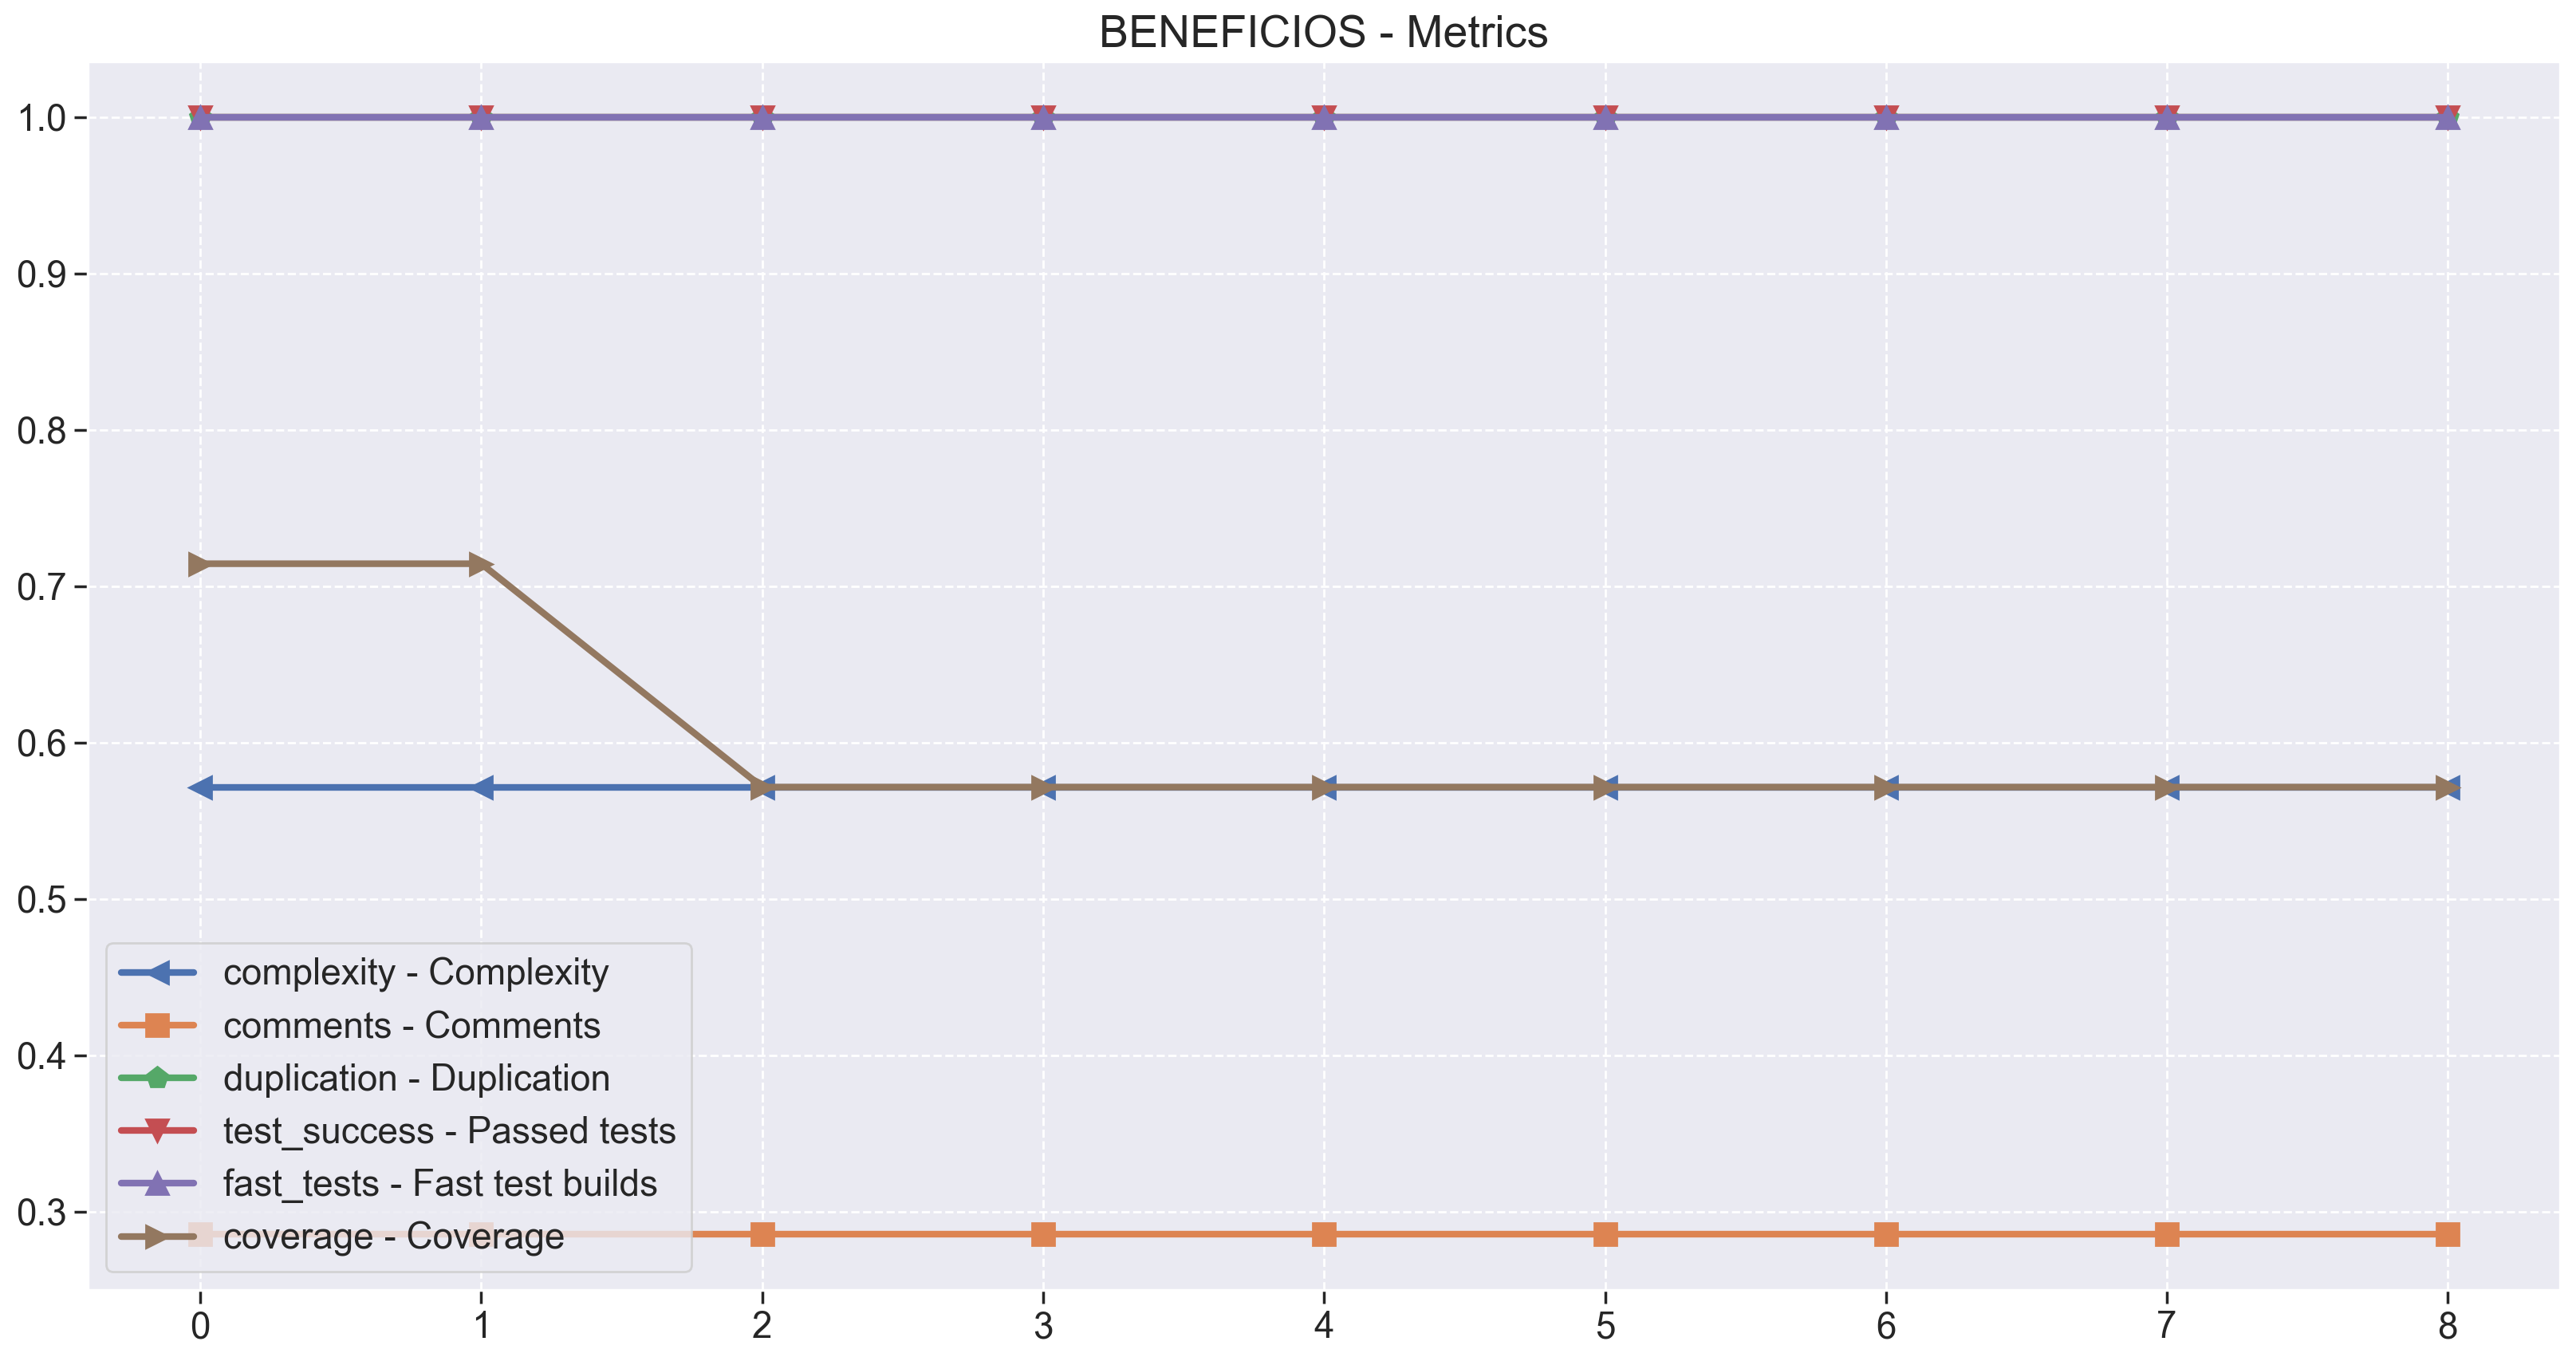

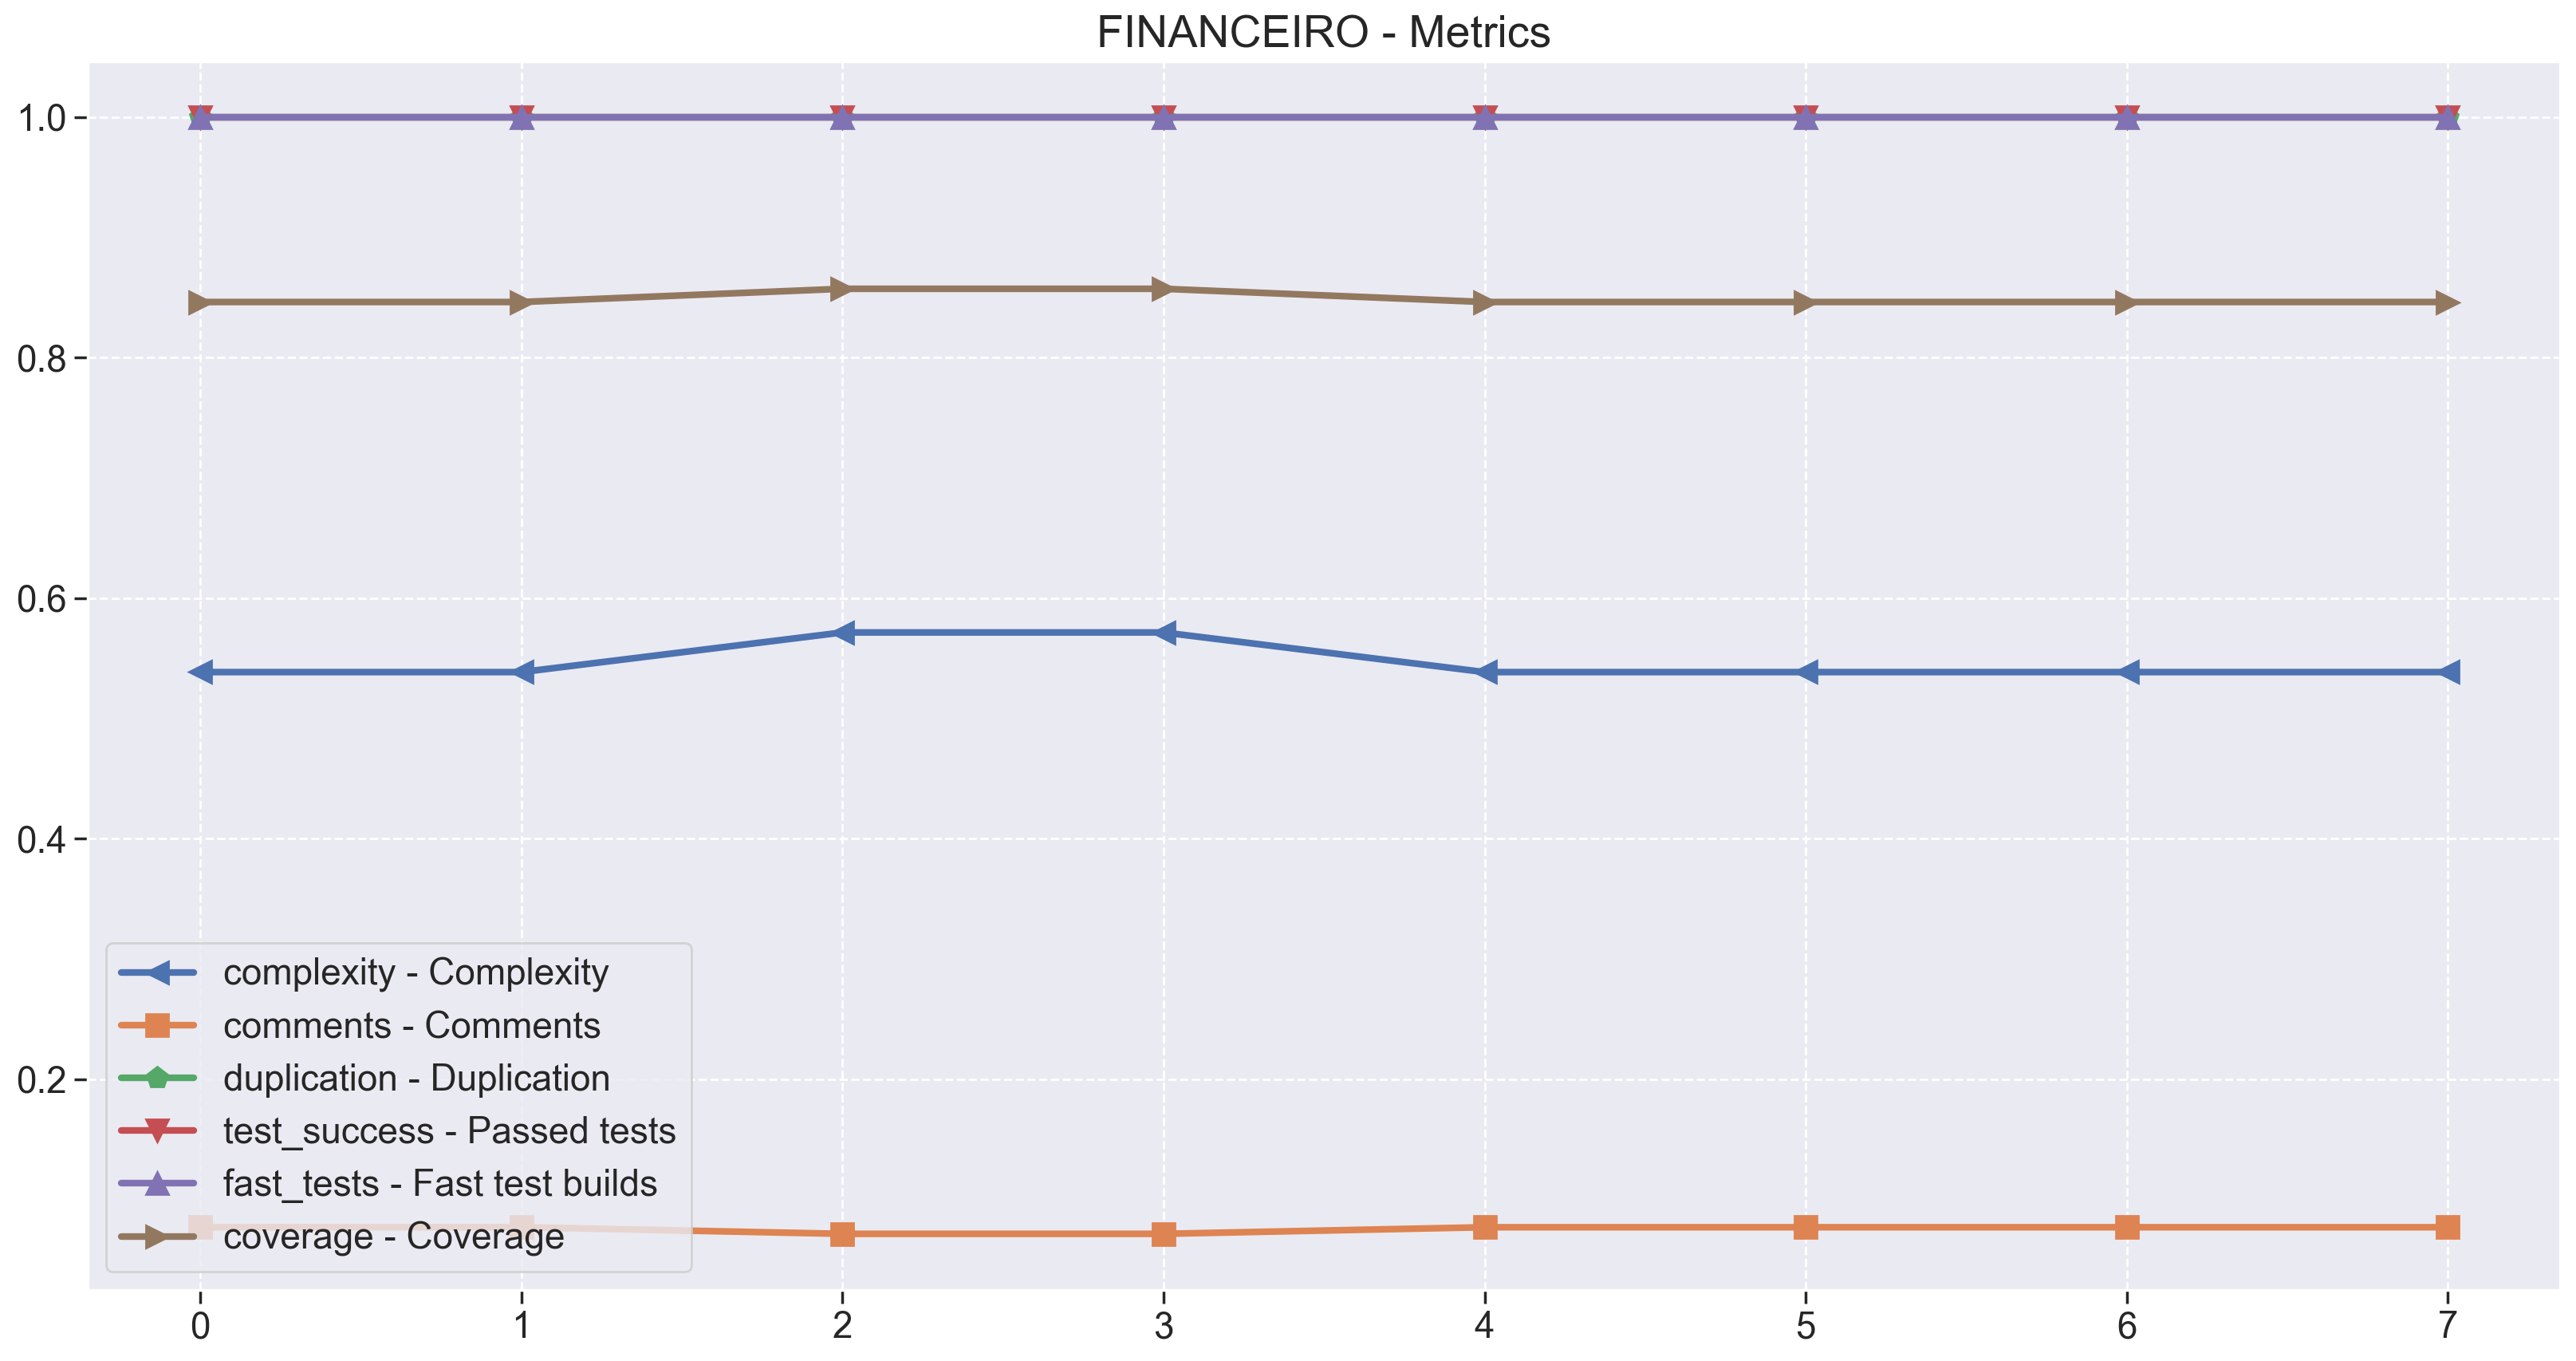

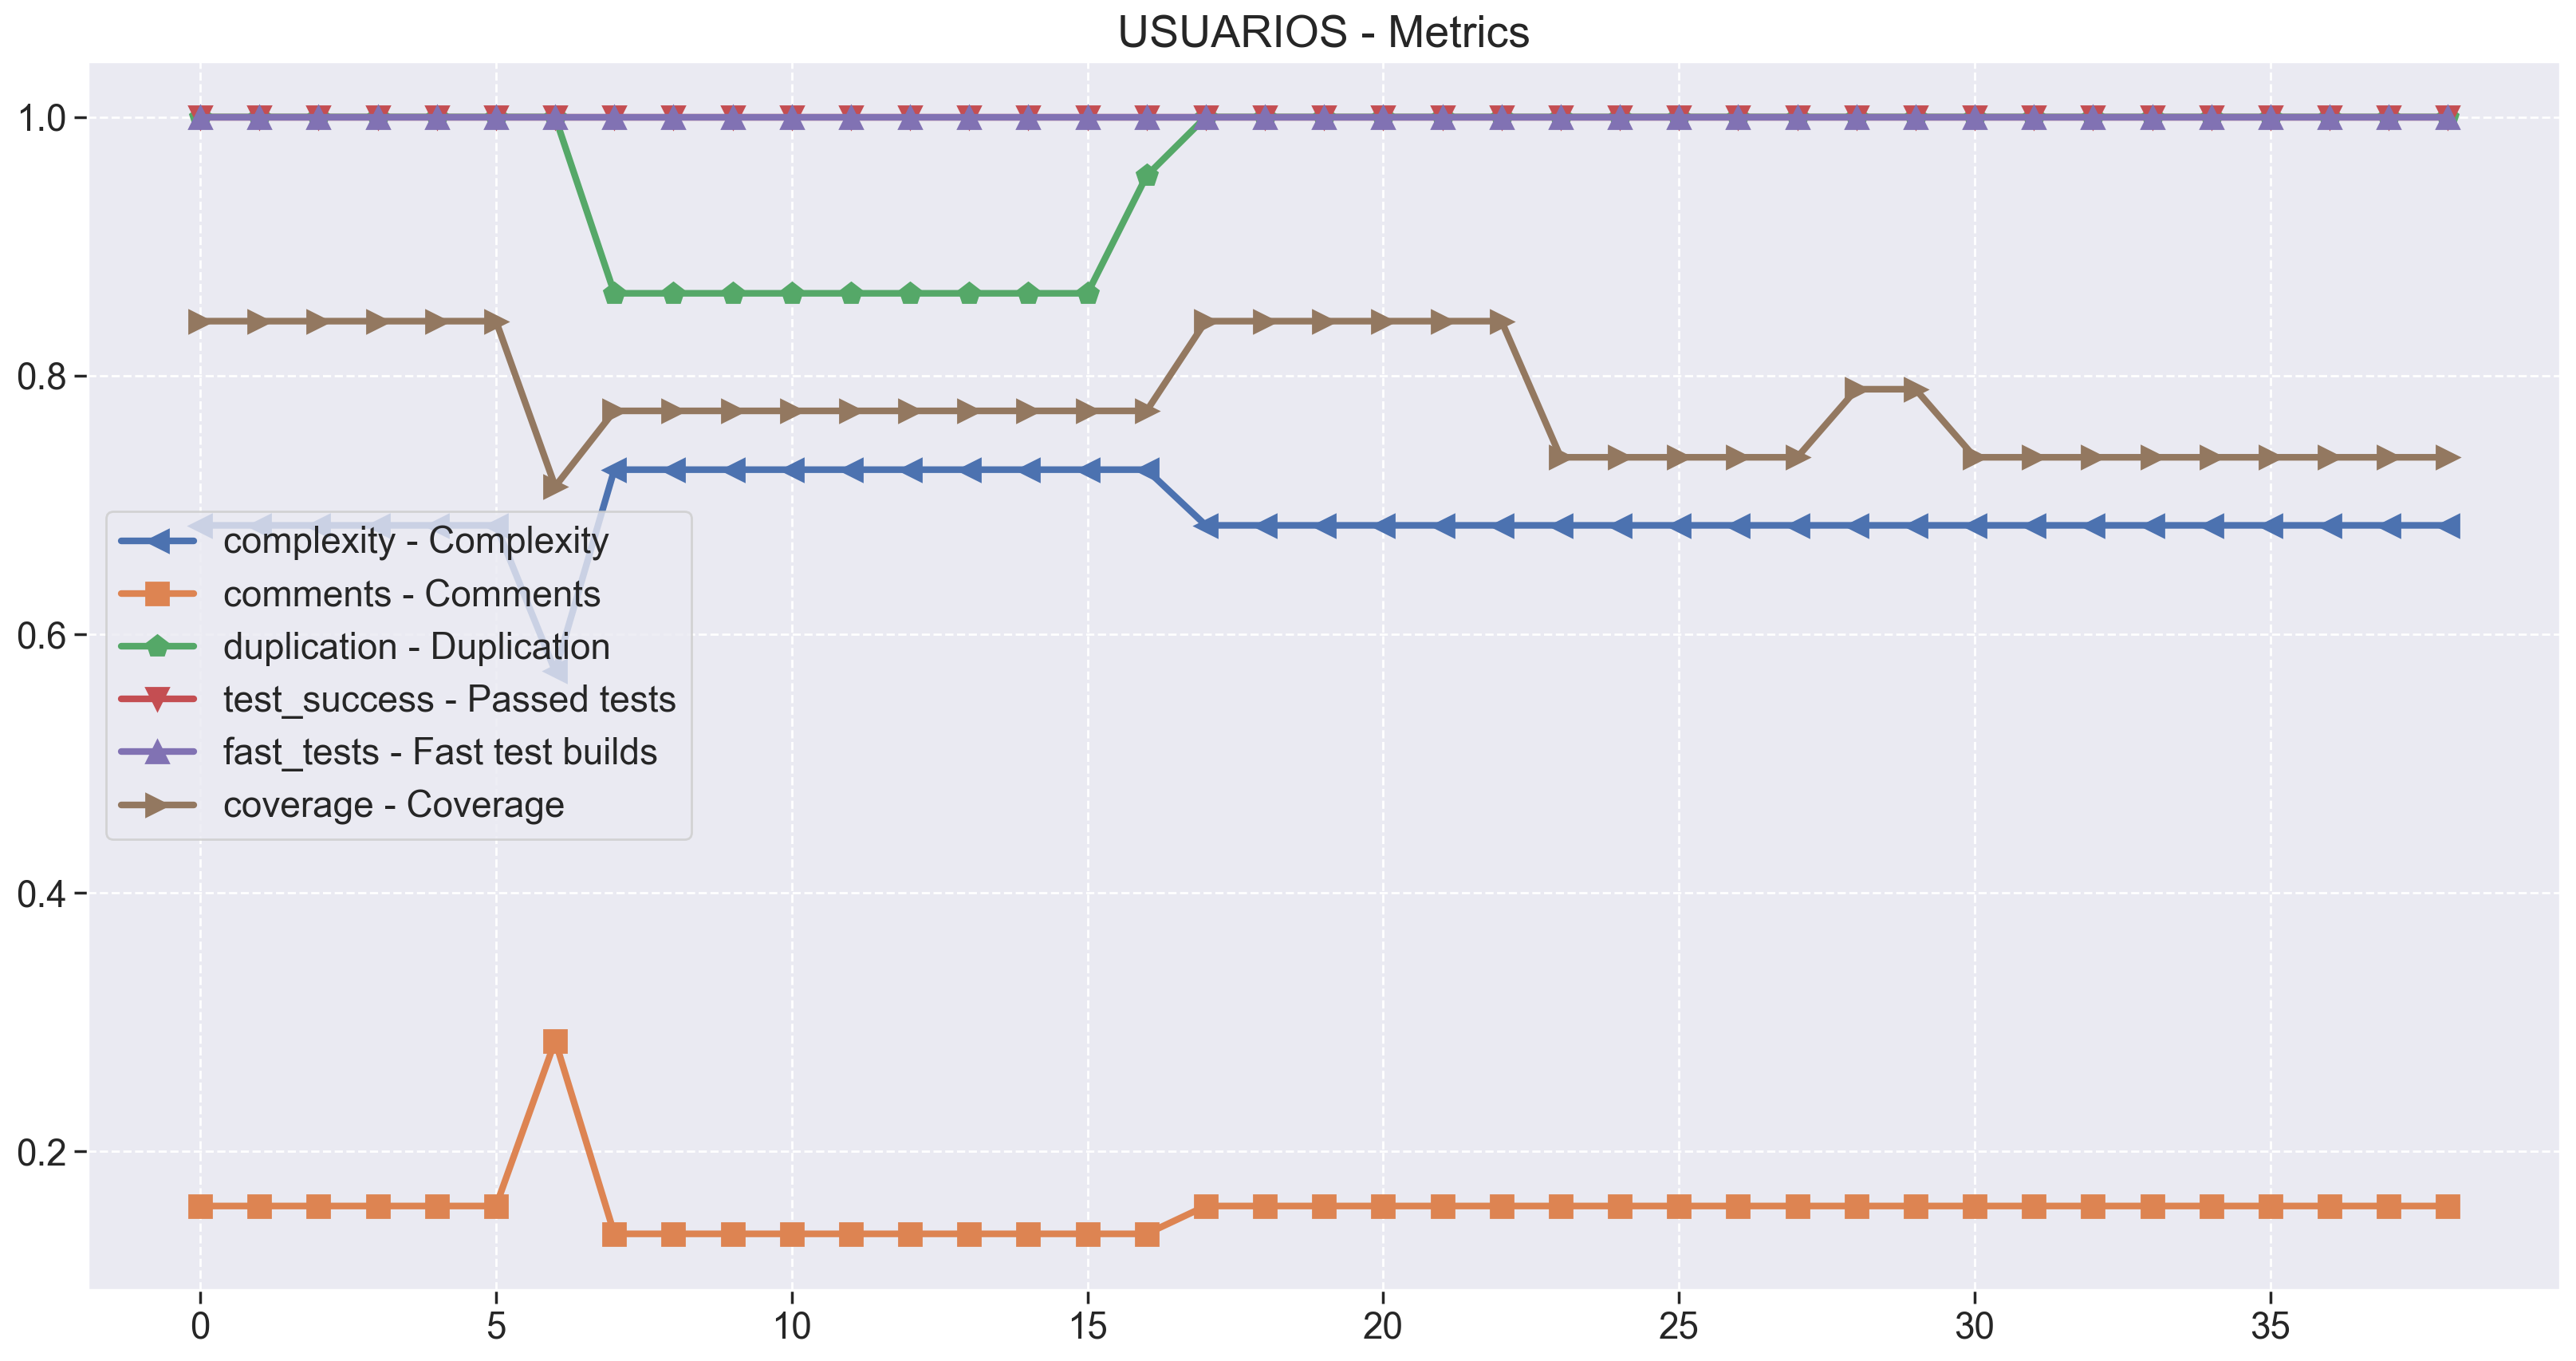

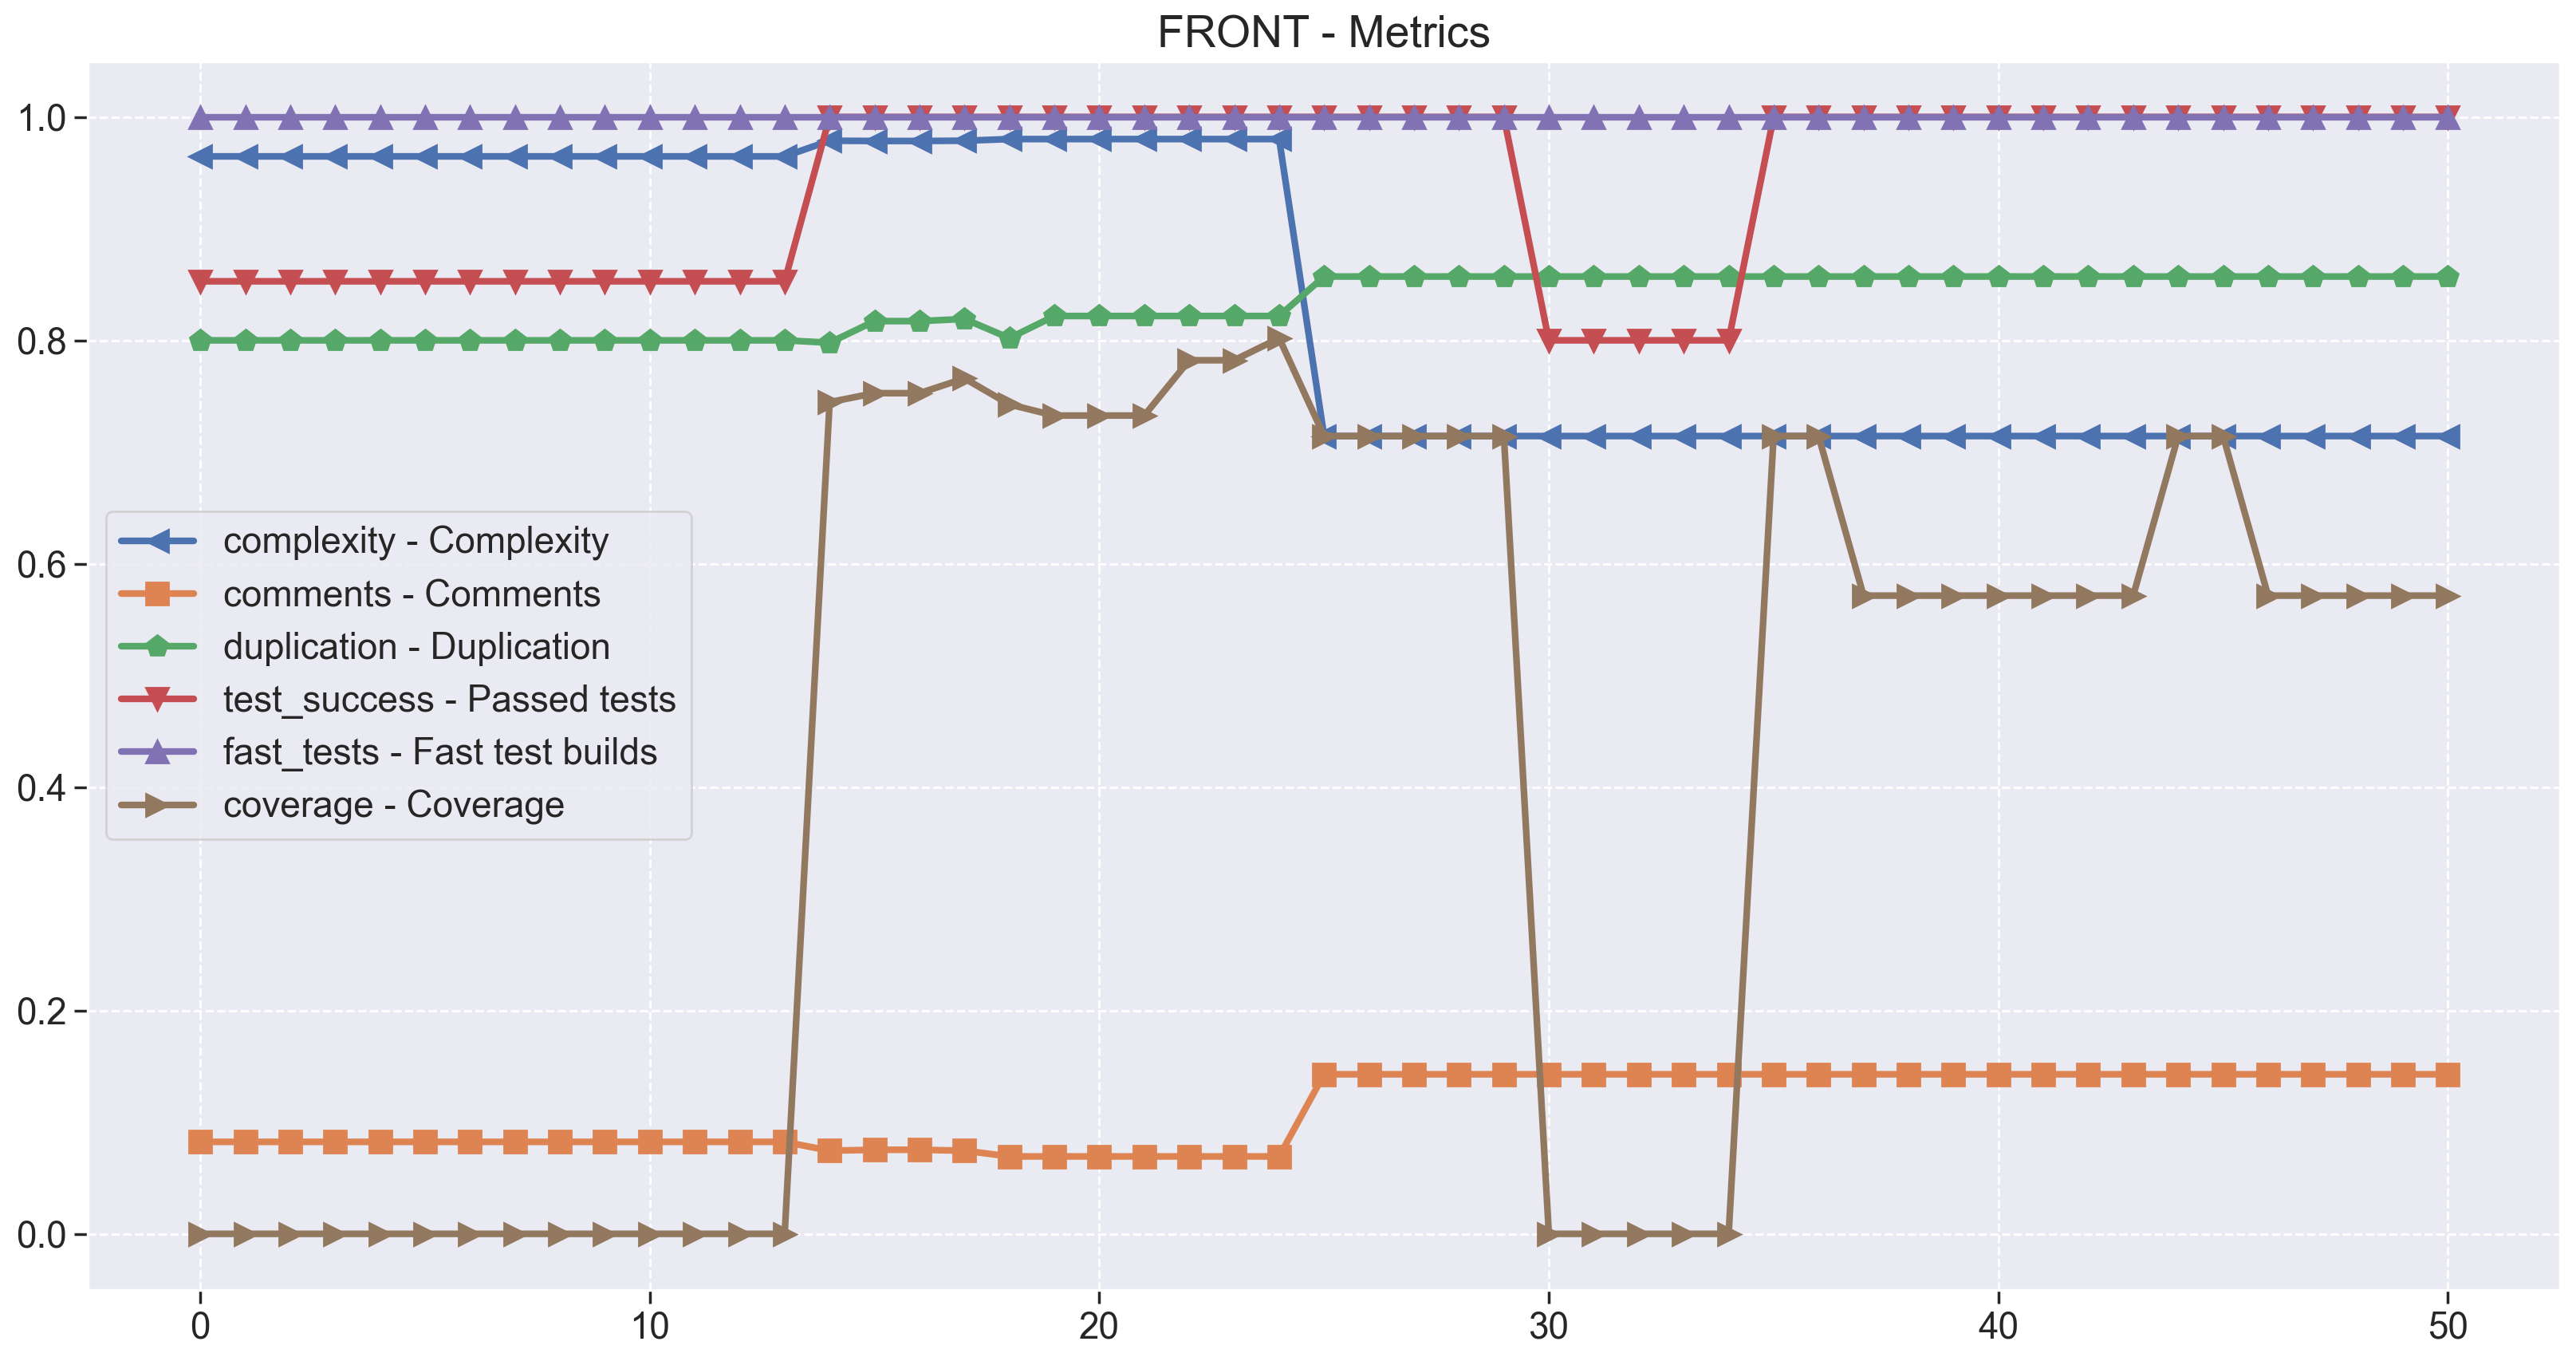

In [27]:
for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))

    plt.plot(data['complexity'], linewidth=3, marker='<', markersize=10, label="complexity - Complexity")
    plt.plot(data['comments'], linewidth=3, marker='s', markersize=10, label="comments - Comments")
    plt.plot(data['duplication'], linewidth=3, marker='p', markersize=10, label="duplication - Duplication")
    plt.plot(data['test_success'], linewidth=3, marker='v', markersize=10, label="test_success - Passed tests")
    plt.plot(data['fast_tests'], linewidth=3, marker='^', markersize=10, label="fast_tests - Fast test builds")
    plt.plot(data['coverage'], linewidth=3, marker='>', markersize=10, label="coverage - Coverage")

    plt.title(f"{name} - Metrics", fontsize=20)
    plt.legend(loc='best')
    plt.show()

## Quality factor and aspect aggregation

In [28]:
psc1 = 1
psc2 = 1
pc1 = 0.5
pc2 = 0.5
pm1 = 0.33
pm2 = 0.33
pm3 = 0.33
pm4 = 0.25
pm5 = 0.25
pm6 = 0.5


# Here you will need to create the code_quality and testing_status metrics for each repository.

for name, data in metrics.items():
    data['code_quality'] = ((data['complexity']*pm1) + (data['comments']*pm2) + (data['duplication']*pm3)) * psc1
    data['testing_status'] = ((data['test_success']*pm4) + (data['fast_tests']*pm5) + (data['coverage']*pm6)) * psc2

### Code Quality visualization

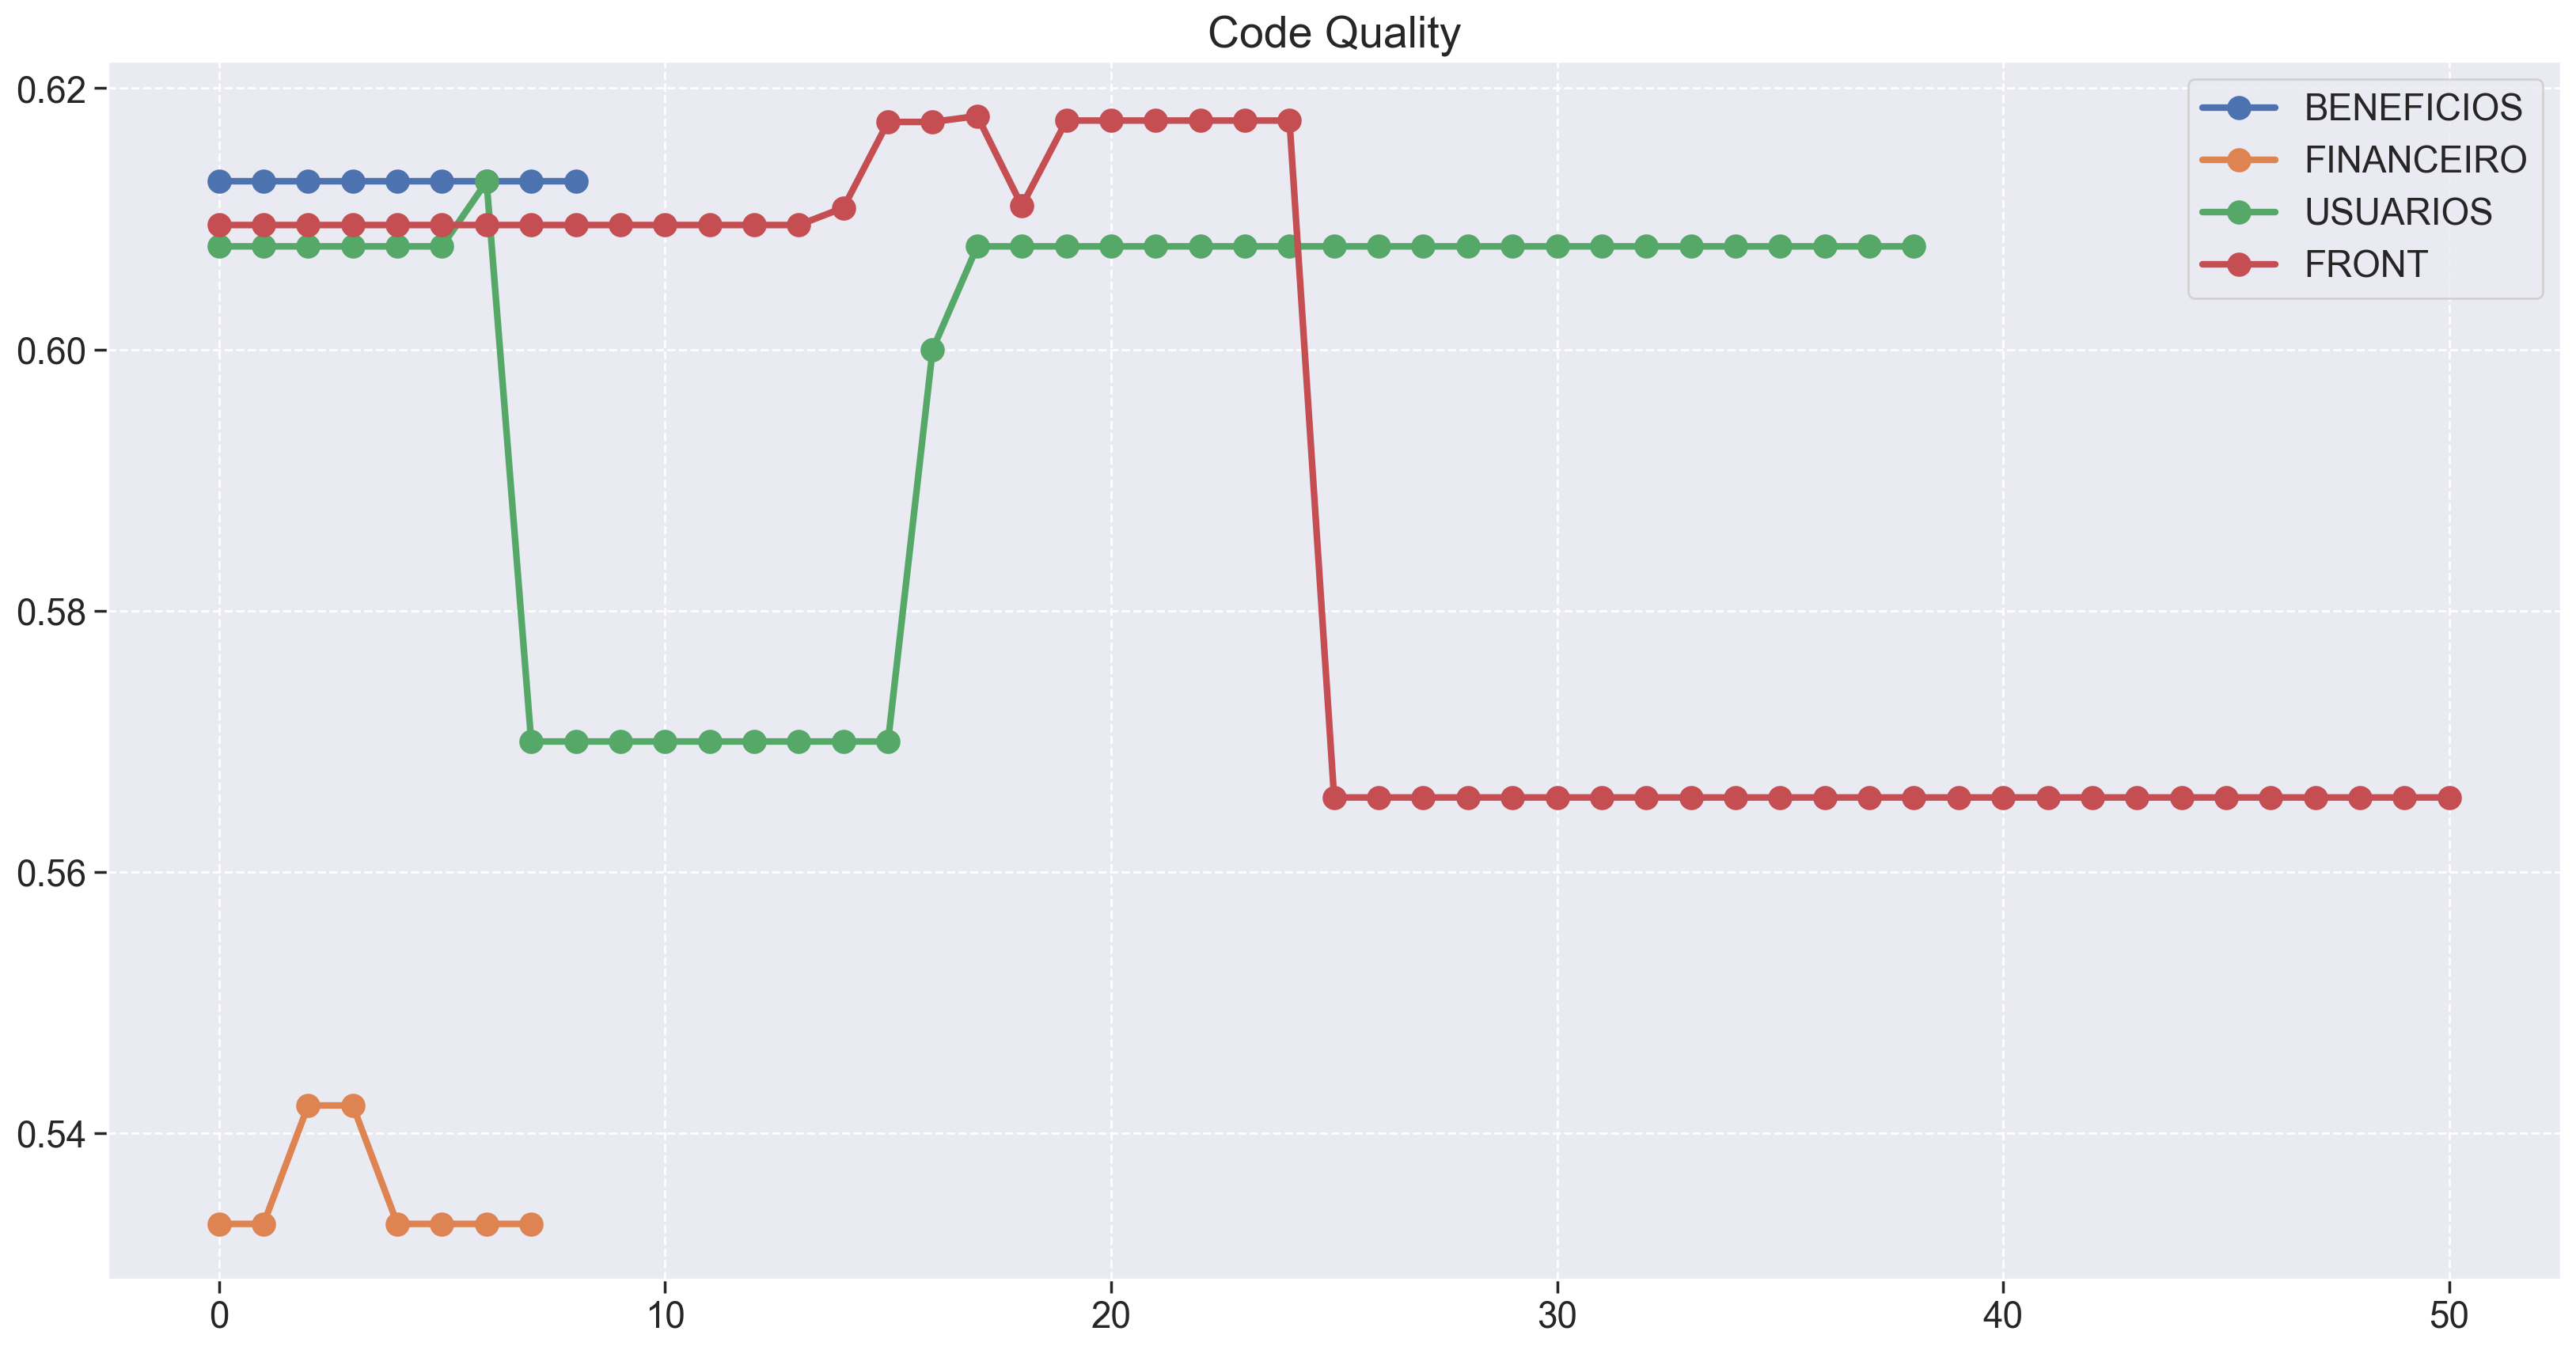

In [29]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['code_quality'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Code Quality", fontsize=20)
plt.legend(loc='best')
plt.show()

### Testing Status visualization

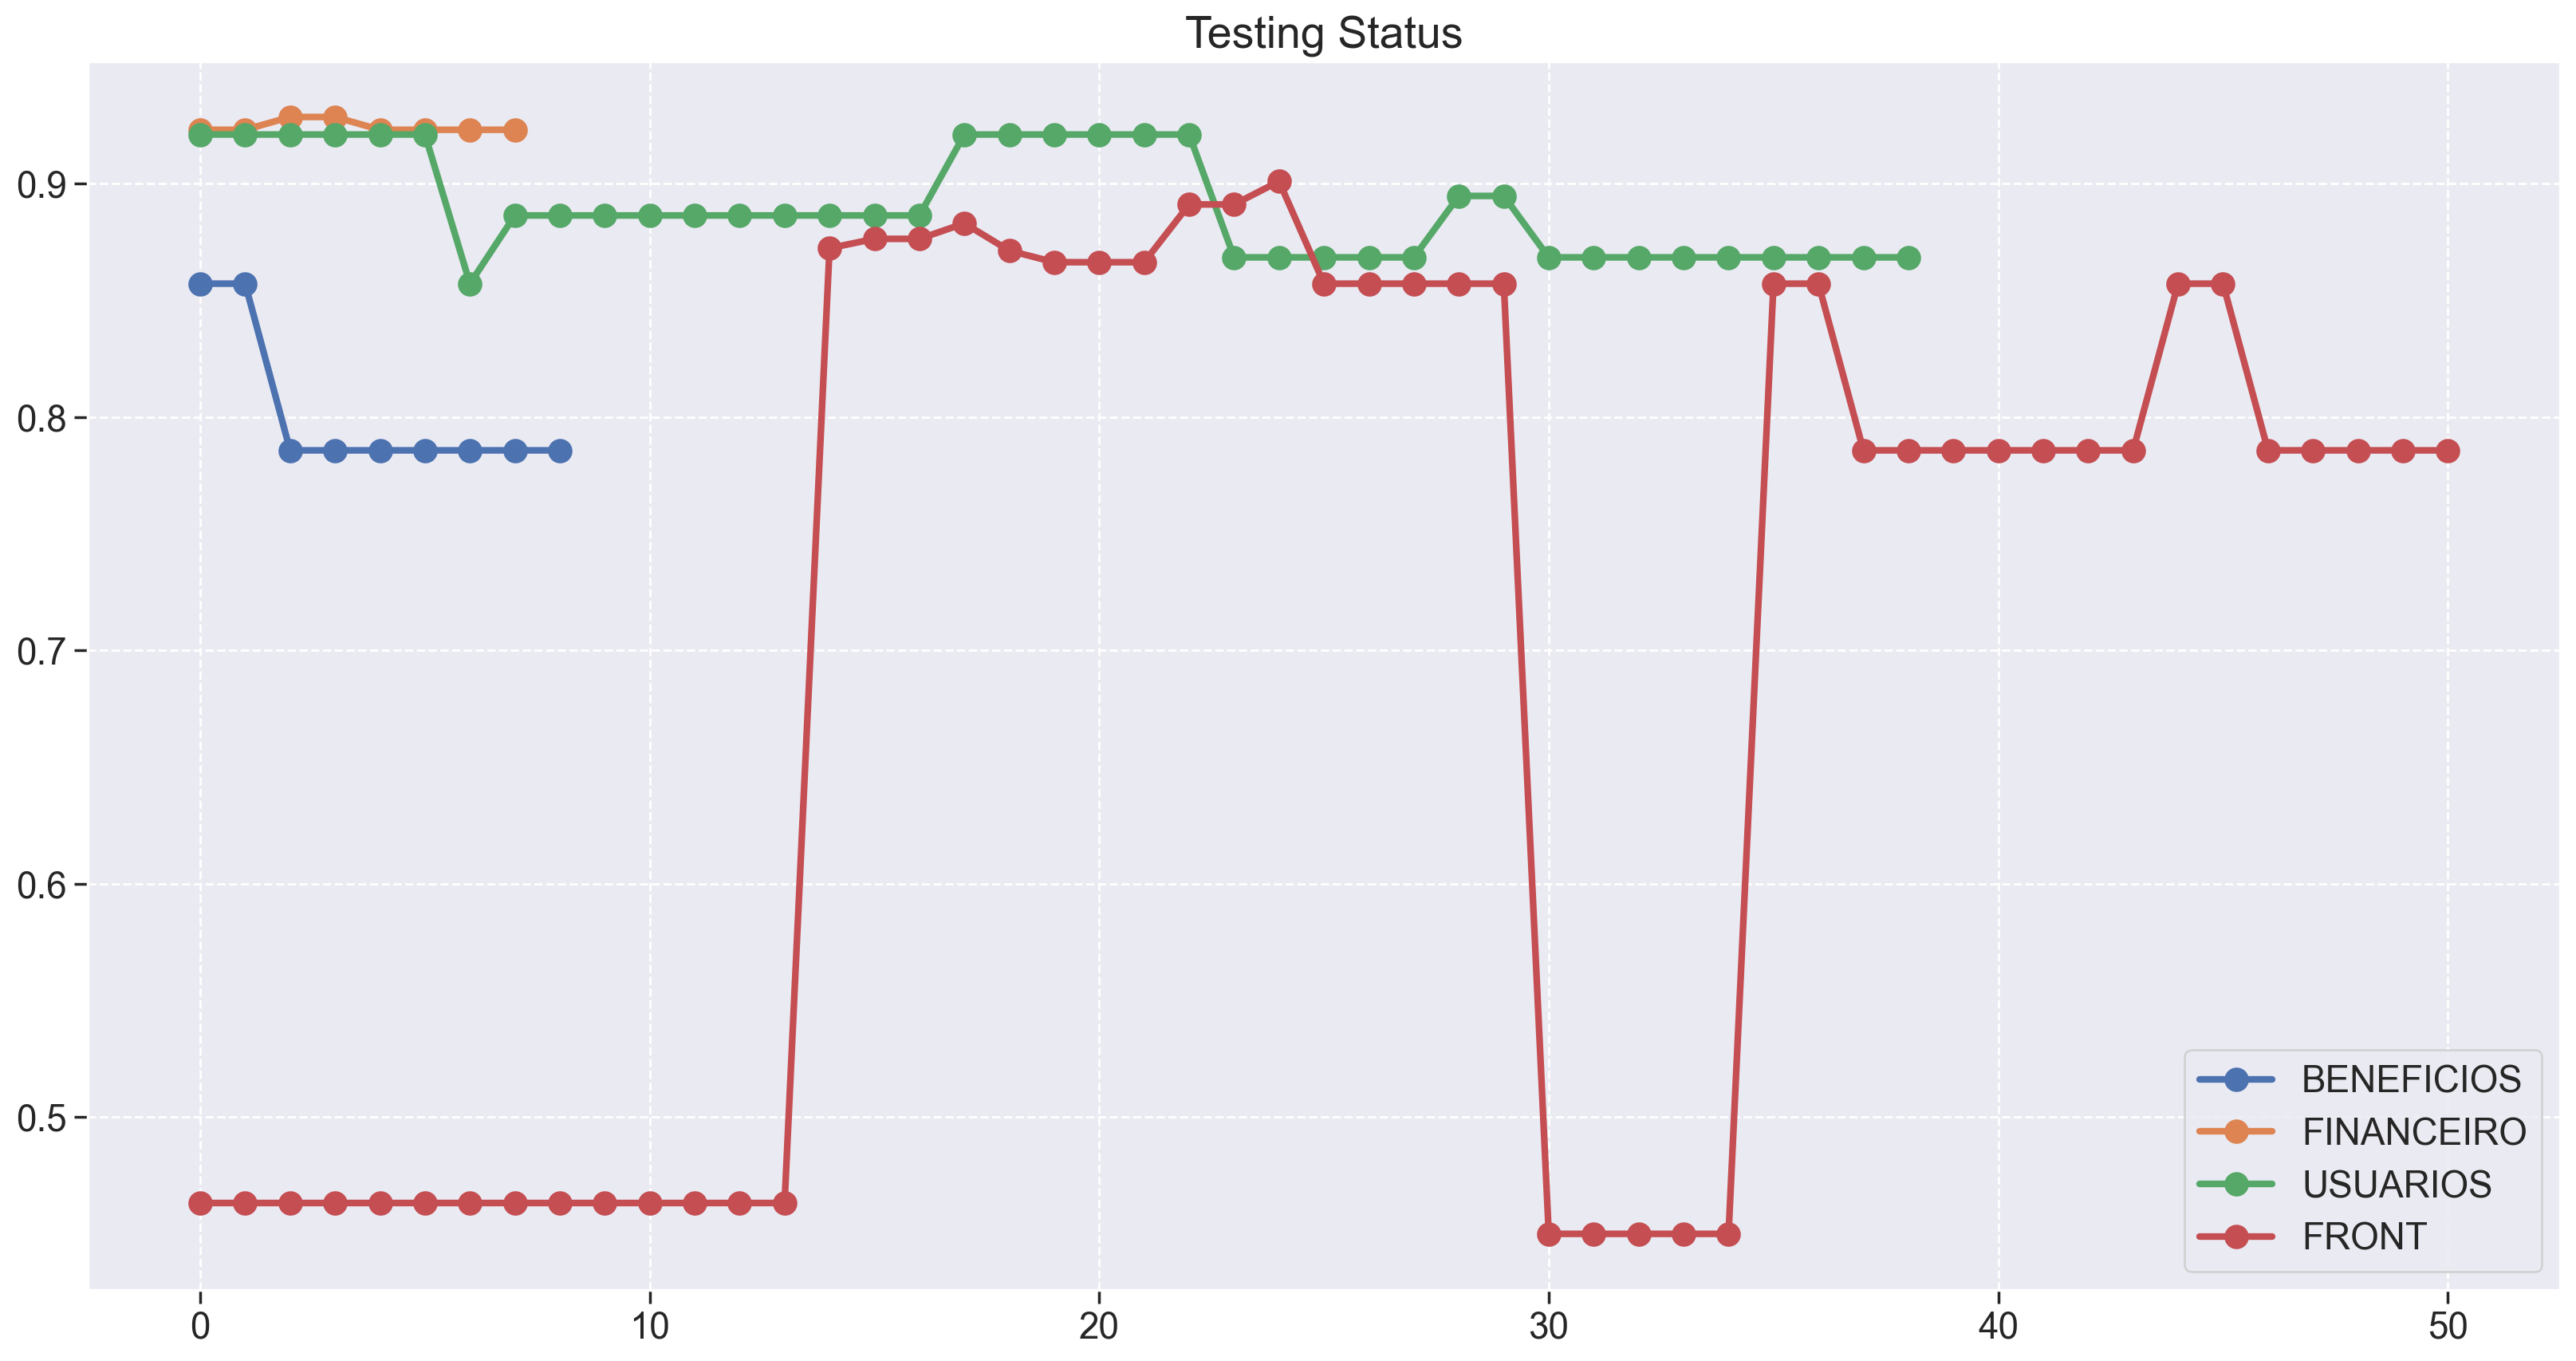

In [30]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['testing_status'], linewidth=3, marker='o', markersize=10, label=name)

plt.title("Testing Status", fontsize=20)
plt.legend(loc='best')
plt.show()

### Aggregations

In [31]:
for name, data in metrics.items():
    data['Maintainability'] = data['code_quality'] * pc1
    data['Reliability'] = data['testing_status'] * pc2
    data['total'] = data['Maintainability'] + data['Reliability']

## Repositories analysis

In [32]:
def get_characteristc_stats(repo_series):
    return {
        'mean': repo_series.mean(),
        'mode': repo_series.mode(),
        'median': repo_series.median(),
        'std': repo_series.std(),
        'var': repo_series.var(),
        'min': repo_series.min(),
        'max': repo_series.max()
    }

In [33]:
def analysis(metrics, name):
    maintainability_stats = pd.DataFrame(get_characteristc_stats(metrics["Maintainability"]),
                                     columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])

    reliability_stats = pd.DataFrame(get_characteristc_stats(metrics["Reliability"]),
                                 columns=['mean', 'mode', 'median', 'std', 'var', 'min', 'max'])


    print("Maintainability Stats")
    print(maintainability_stats.to_string(index=False))

    print("Reliability Stats")
    print(reliability_stats.to_string(index=False))

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['Maintainability'], linewidth=3, marker='o', markersize=10, label="Maintainability")
    plt.plot(metrics['Reliability'], linewidth=3, marker='*', markersize=10, label="Reliability")

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Maintainability and Reliability', fontsize=20)
    plt.legend(loc='best')
    plt.show()

    fig = plt.figure(figsize=(20, 10))

    plt.plot(metrics['total'], linewidth=3, marker='X', markersize=5)

    plt.ylim(0.1,1.1)
    plt.title(f'{name} - Total', fontsize=20)
    plt.show()

### Analysis loop in each repo

BENEFICIOS
Maintainability Stats
    mean     mode   median  std  var      min      max
0.306429 0.306429 0.306429  0.0  0.0 0.306429 0.306429
Reliability Stats
    mean     mode   median      std      var      min      max
0.400794 0.392857 0.392857 0.015749 0.000248 0.392857 0.428571


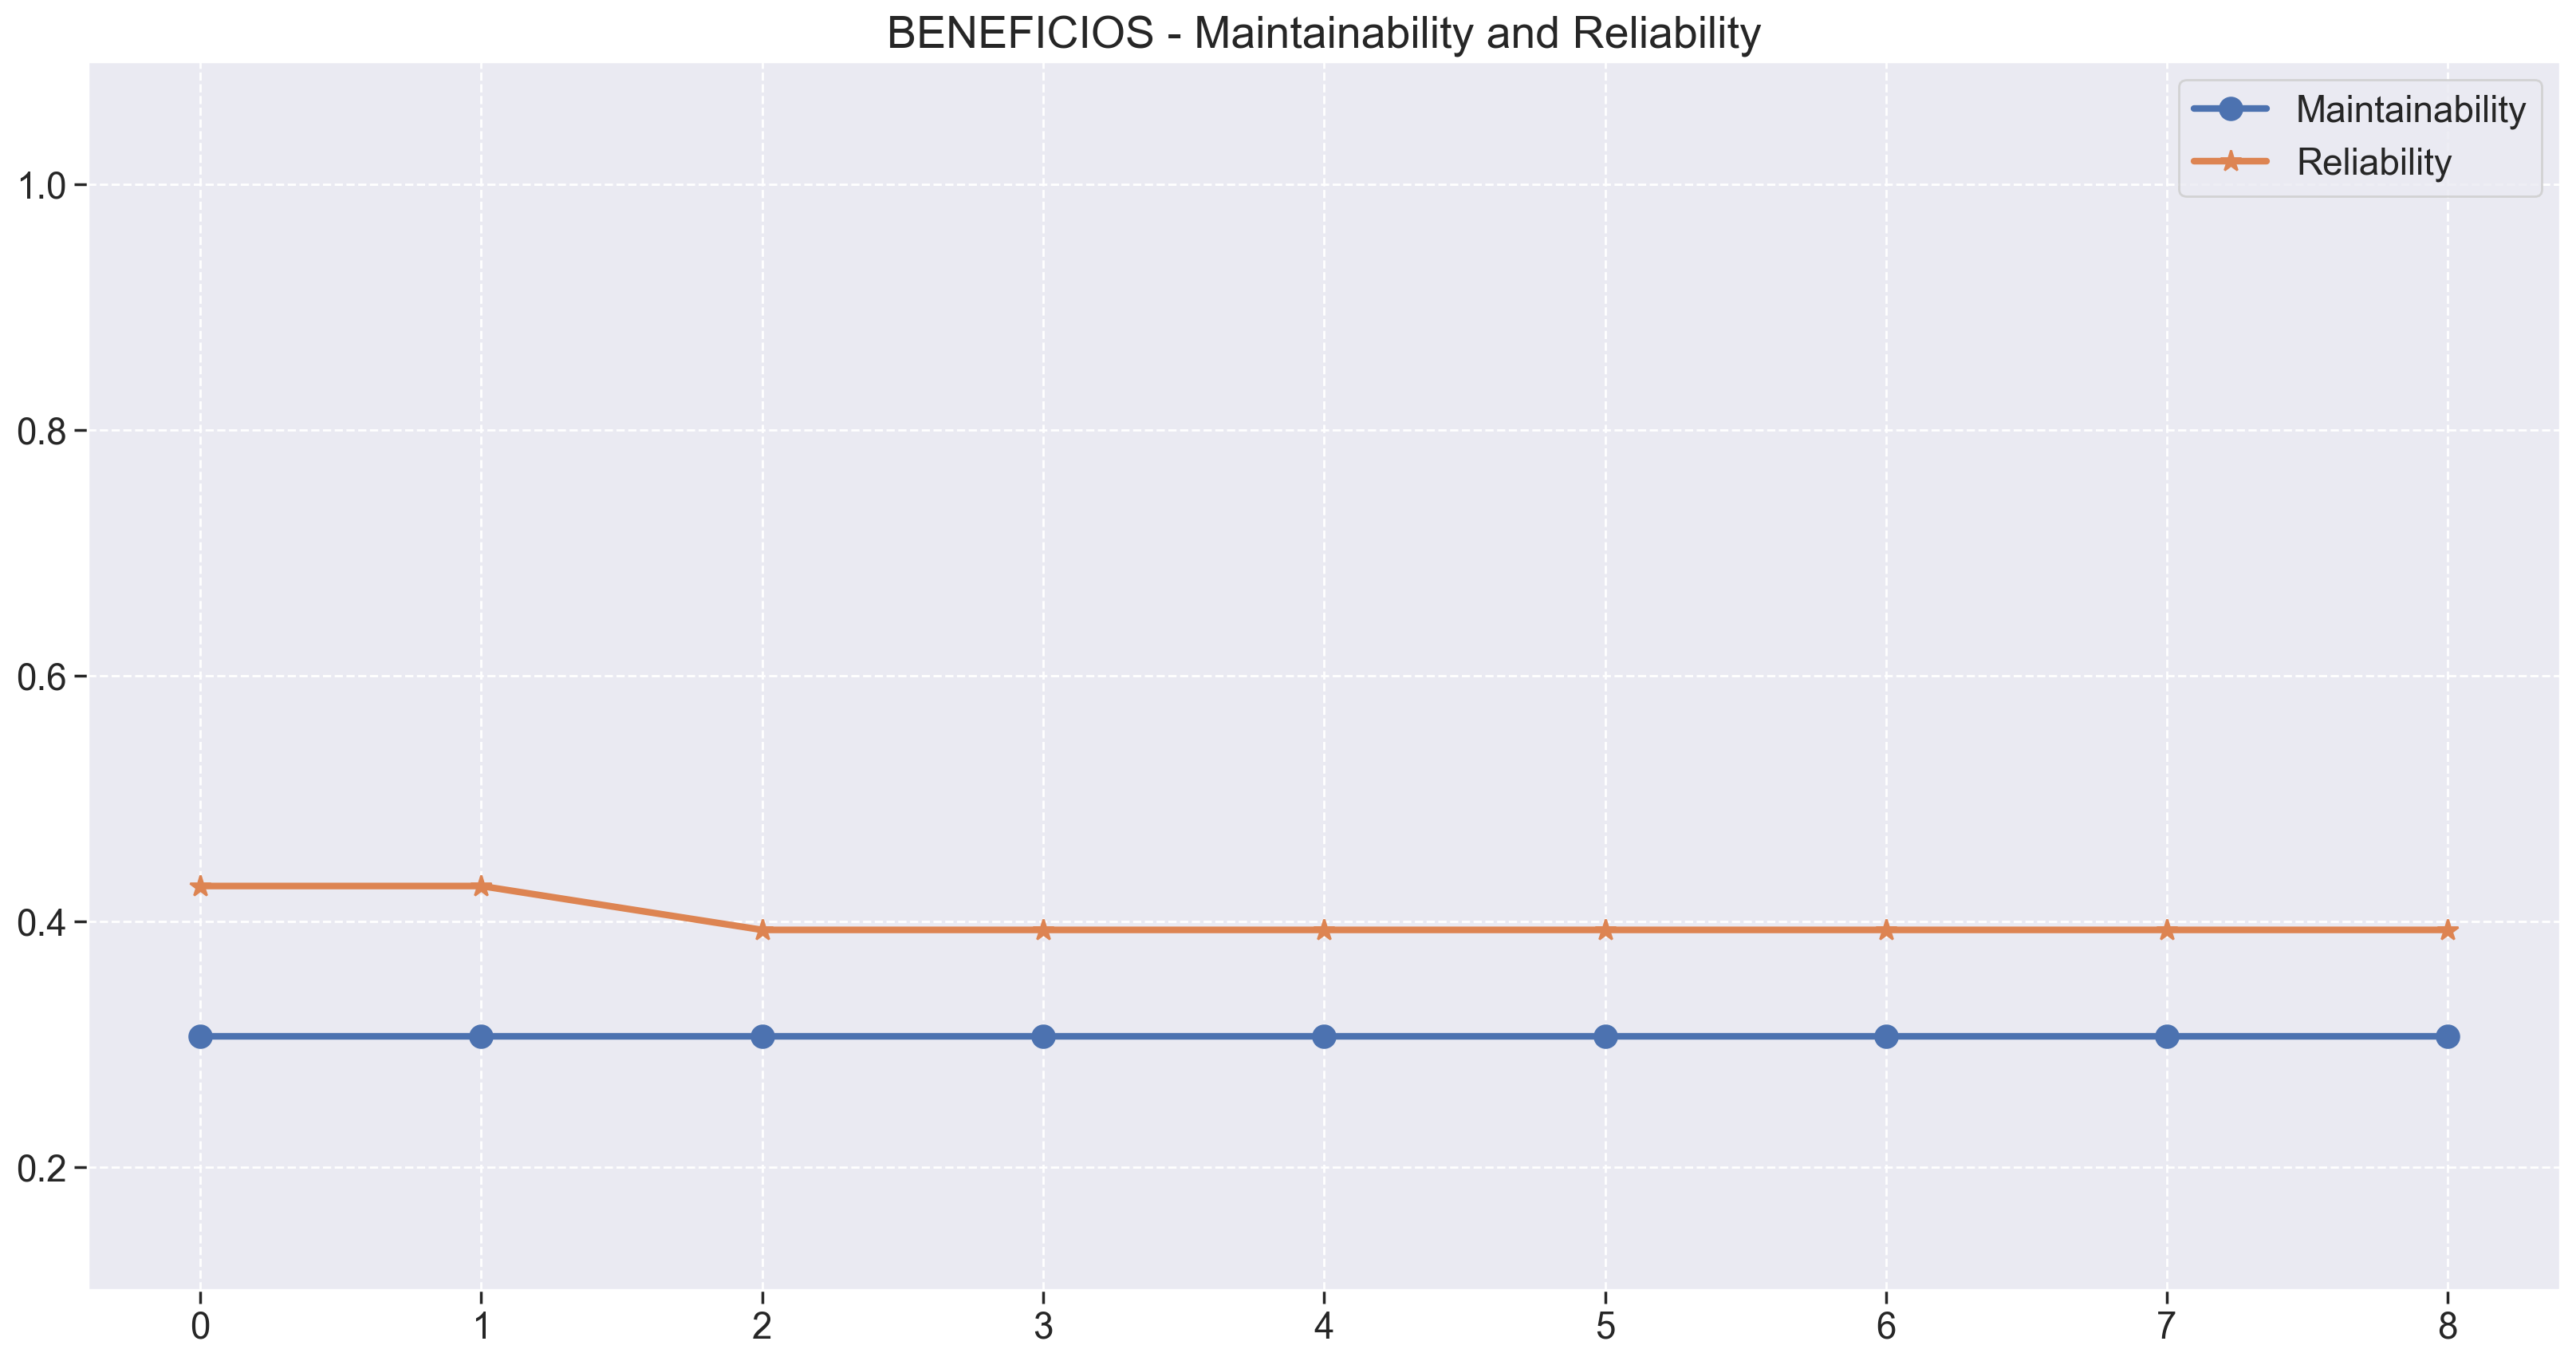

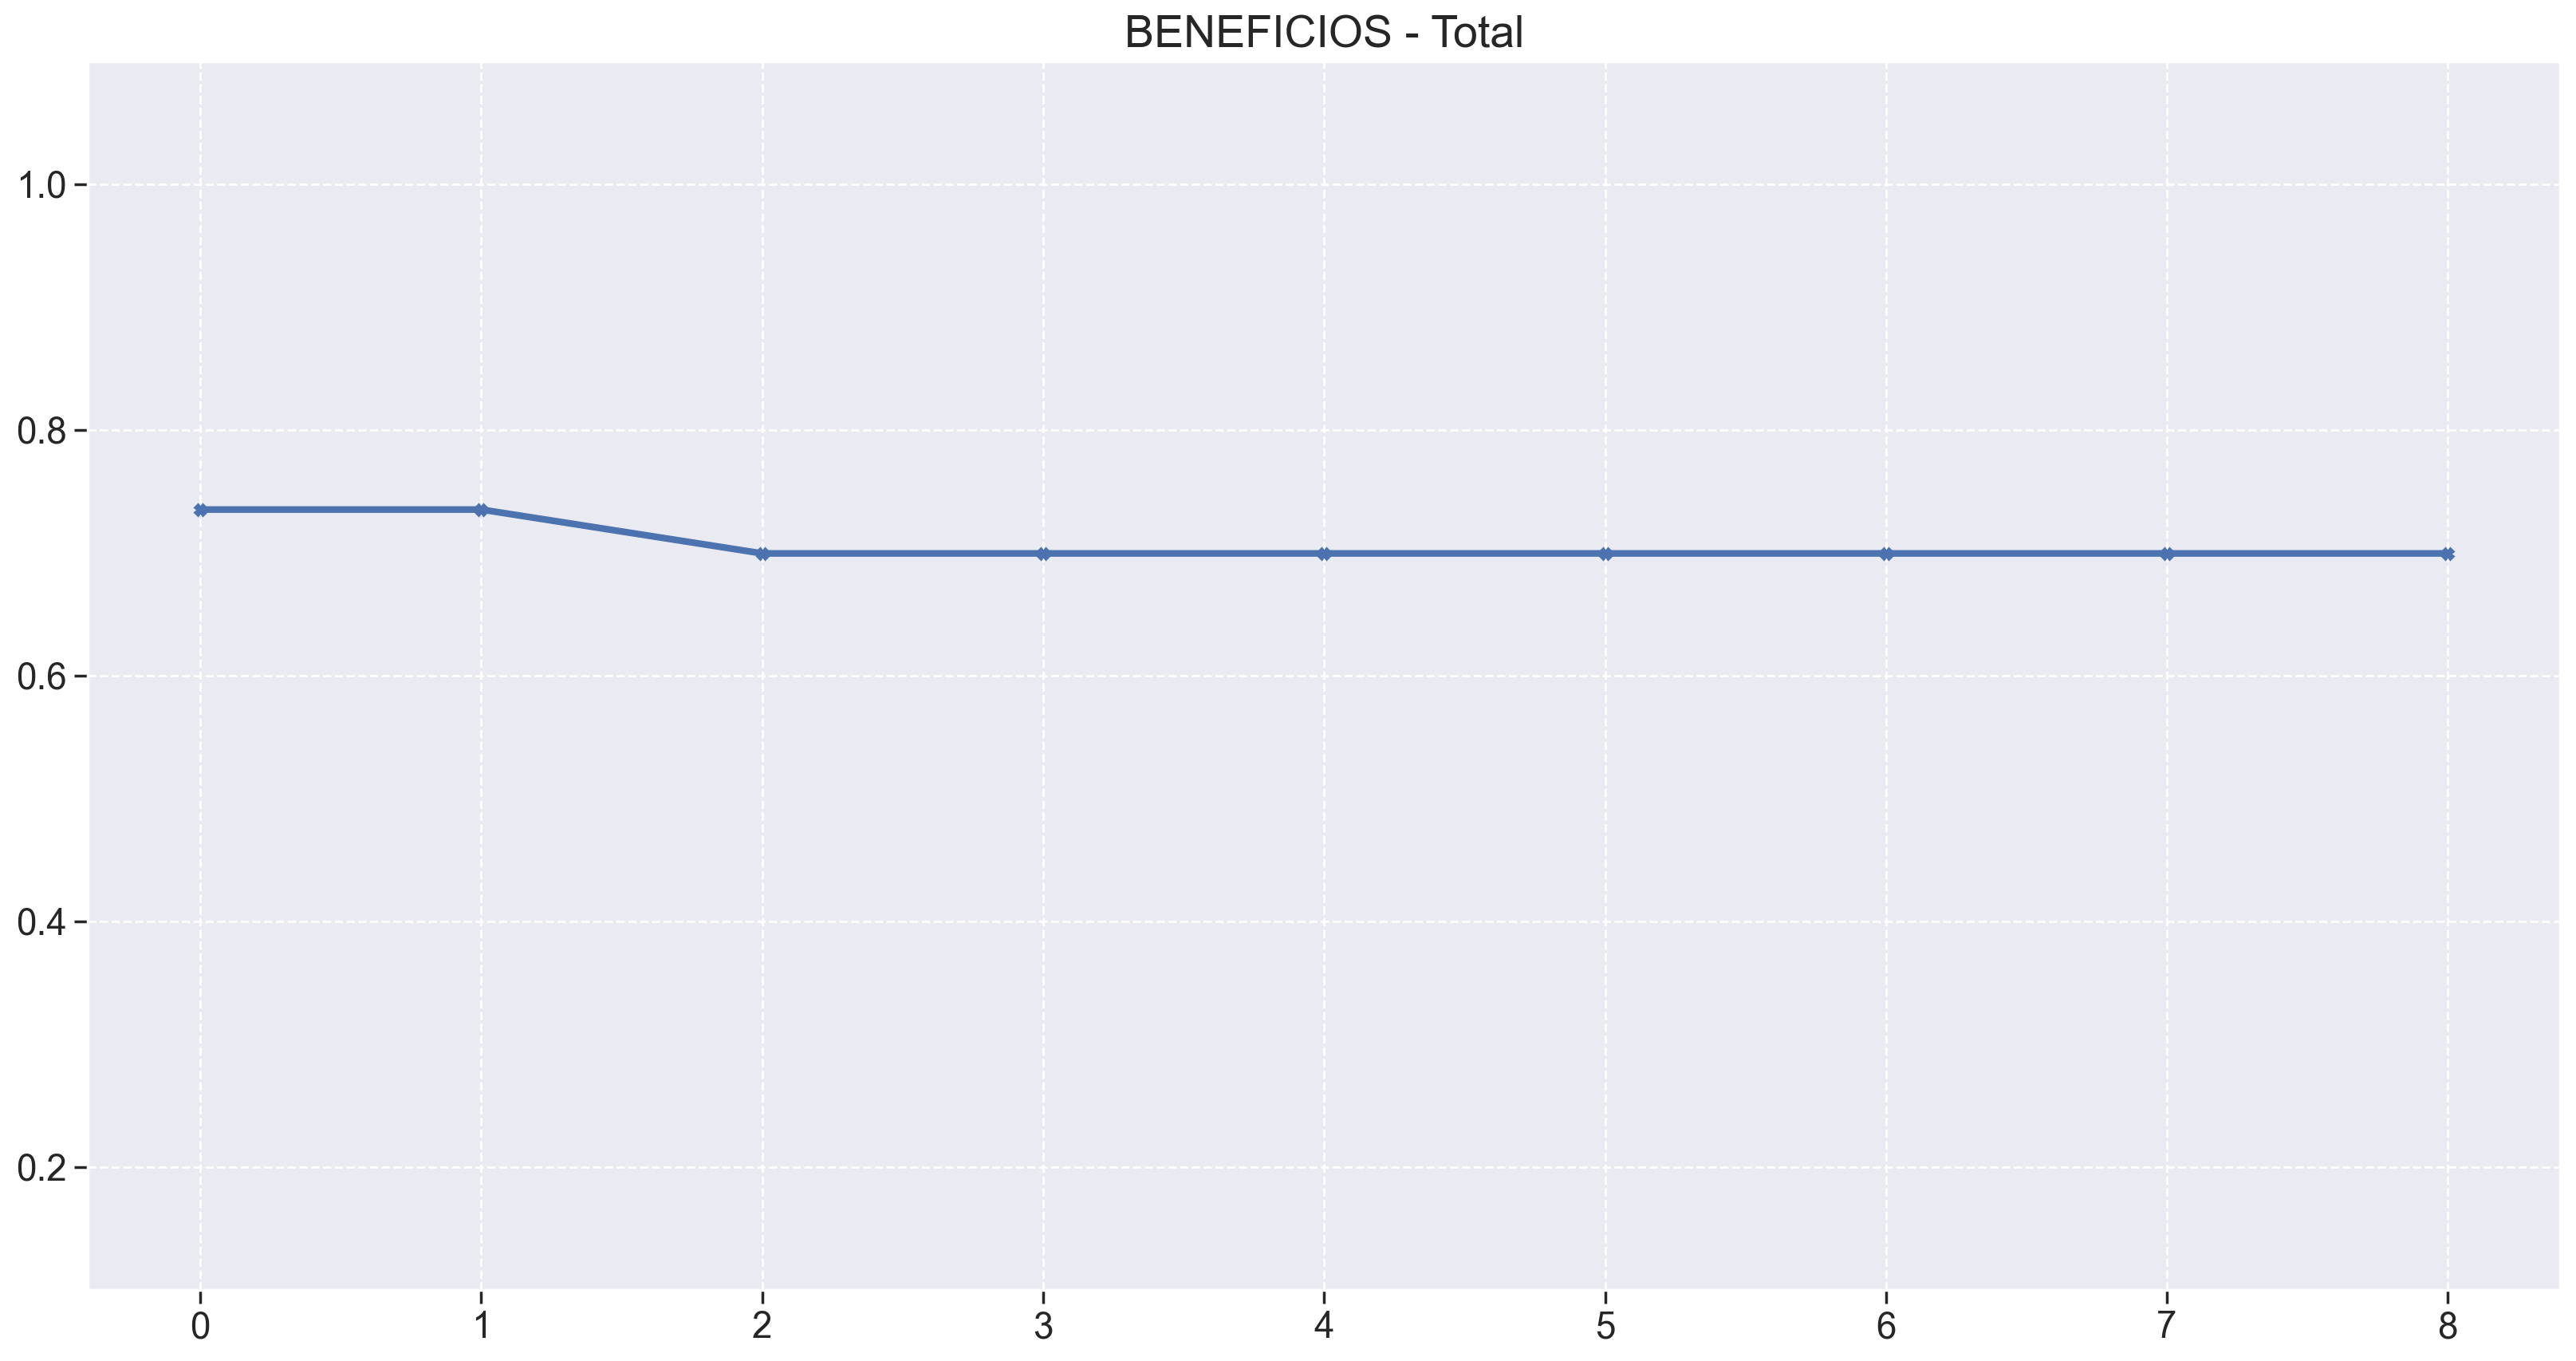

FINANCEIRO
Maintainability Stats
    mean     mode   median      std      var      min      max
0.267672 0.266538 0.266538 0.002098 0.000004 0.266538 0.271071
Reliability Stats
    mean     mode   median      std      var      min      max
0.462225 0.461538 0.461538 0.001272 0.000002 0.461538 0.464286


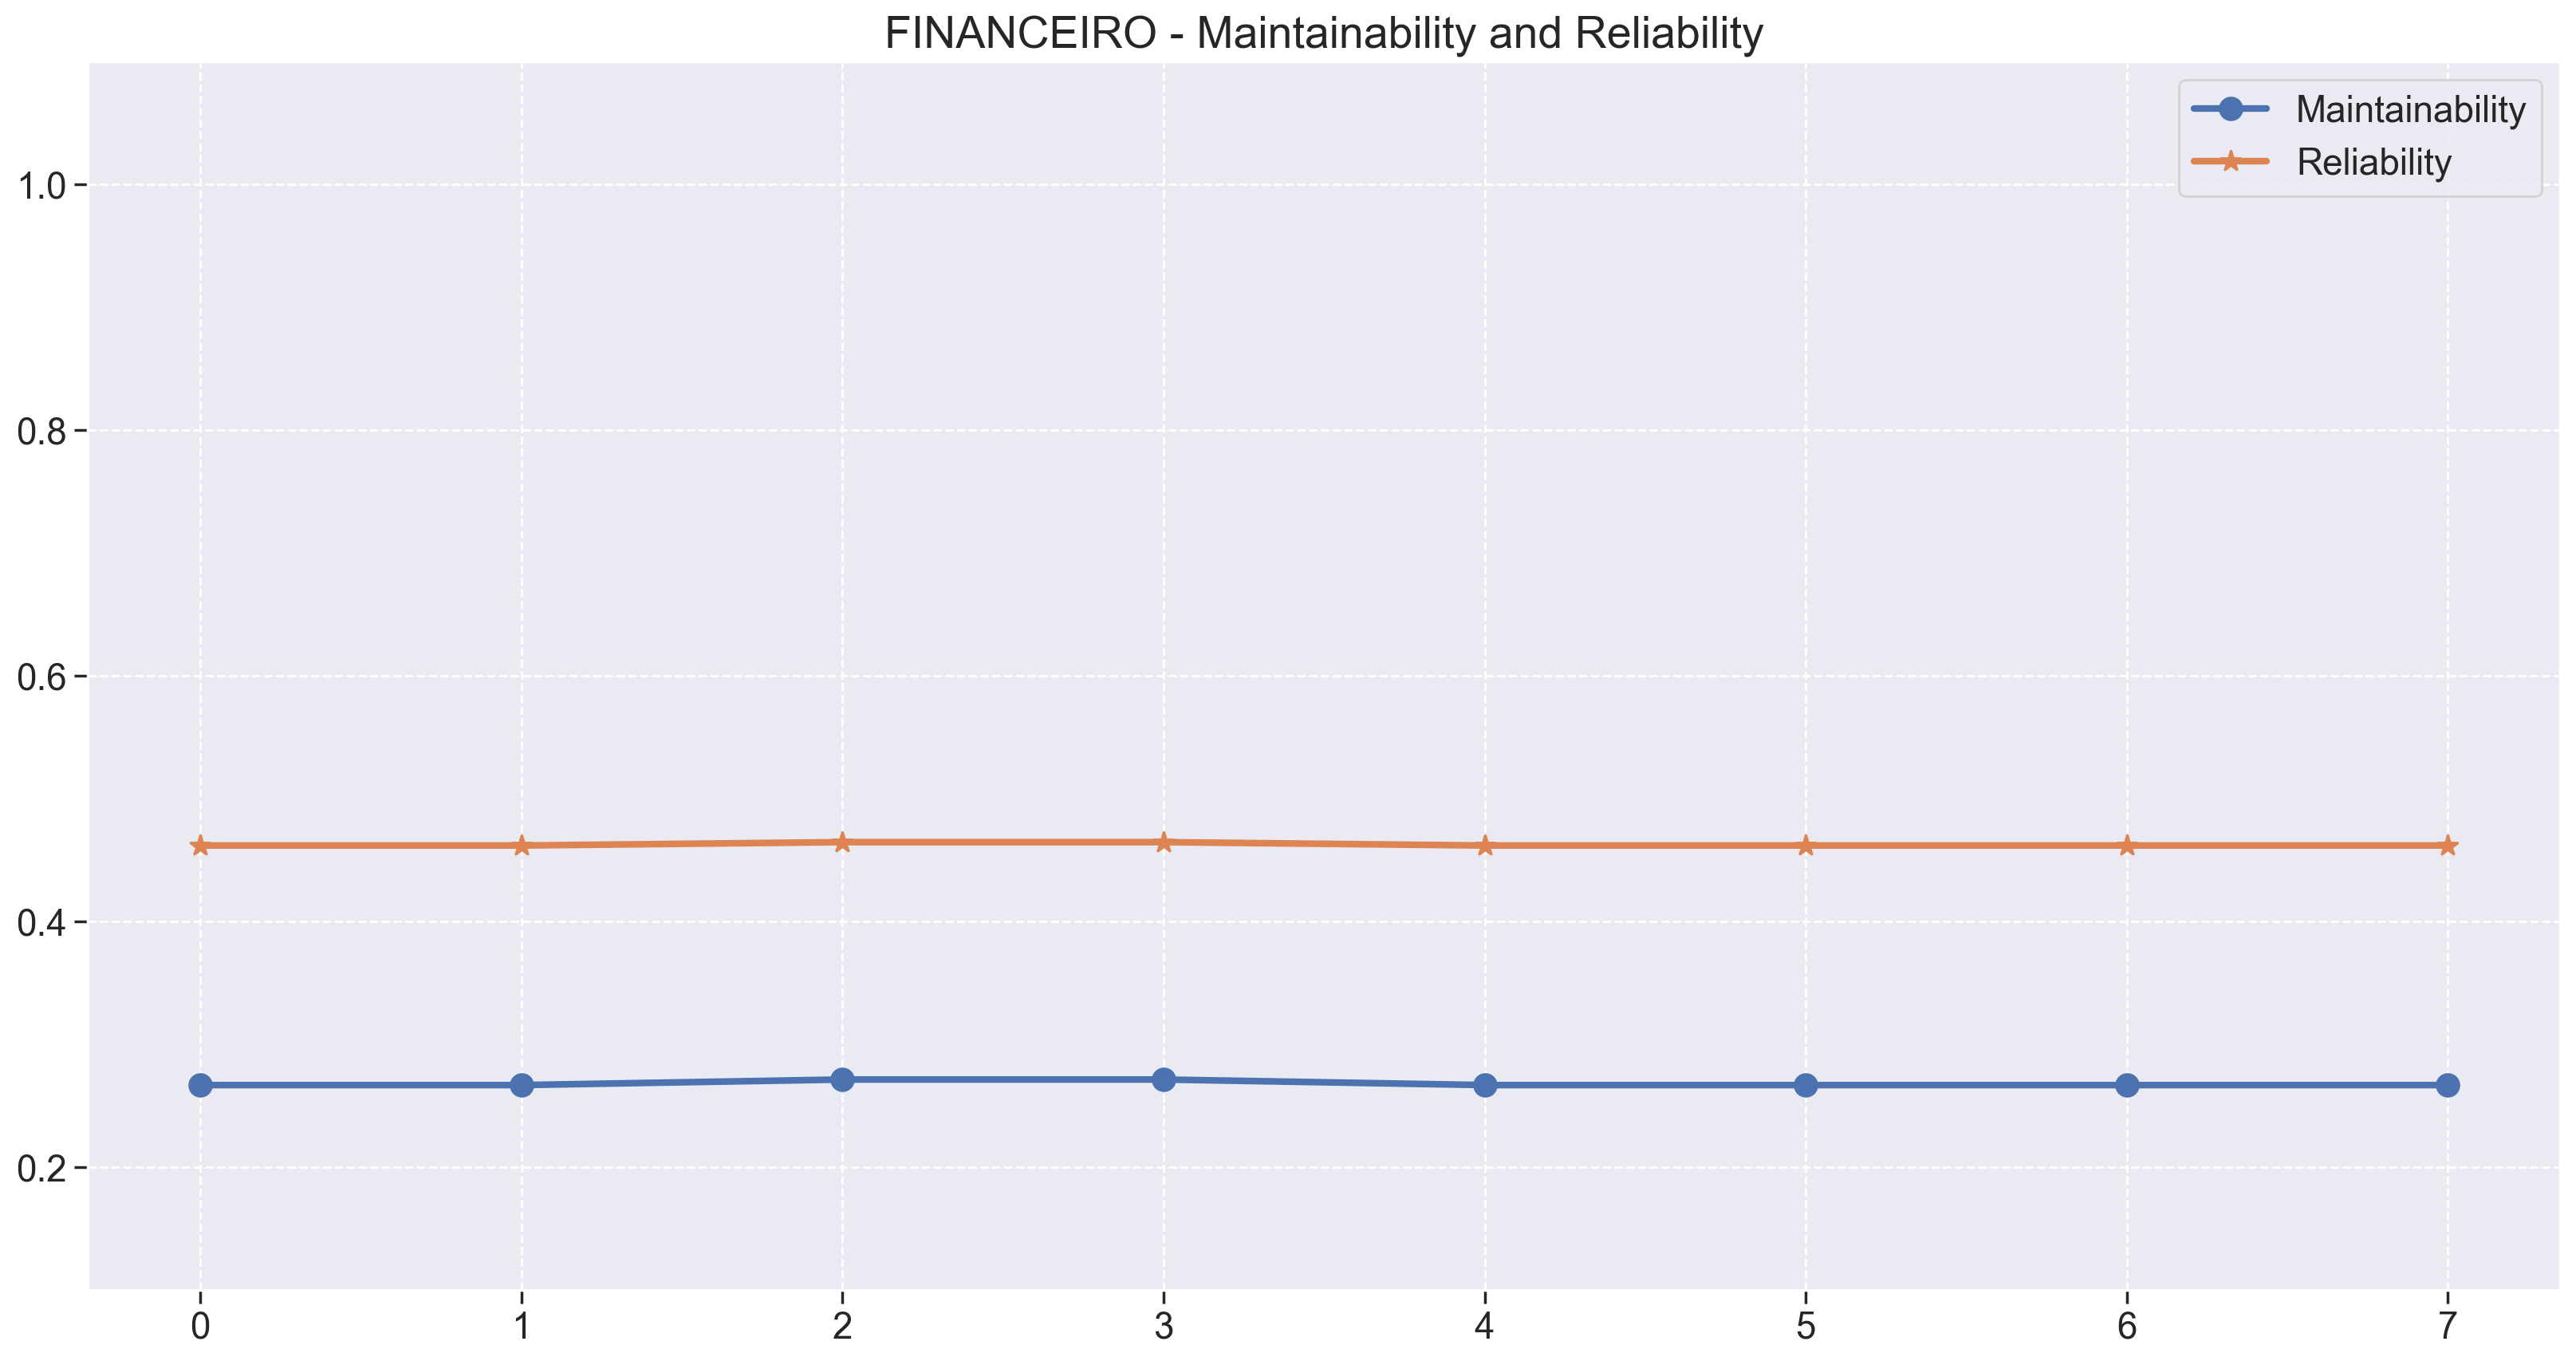

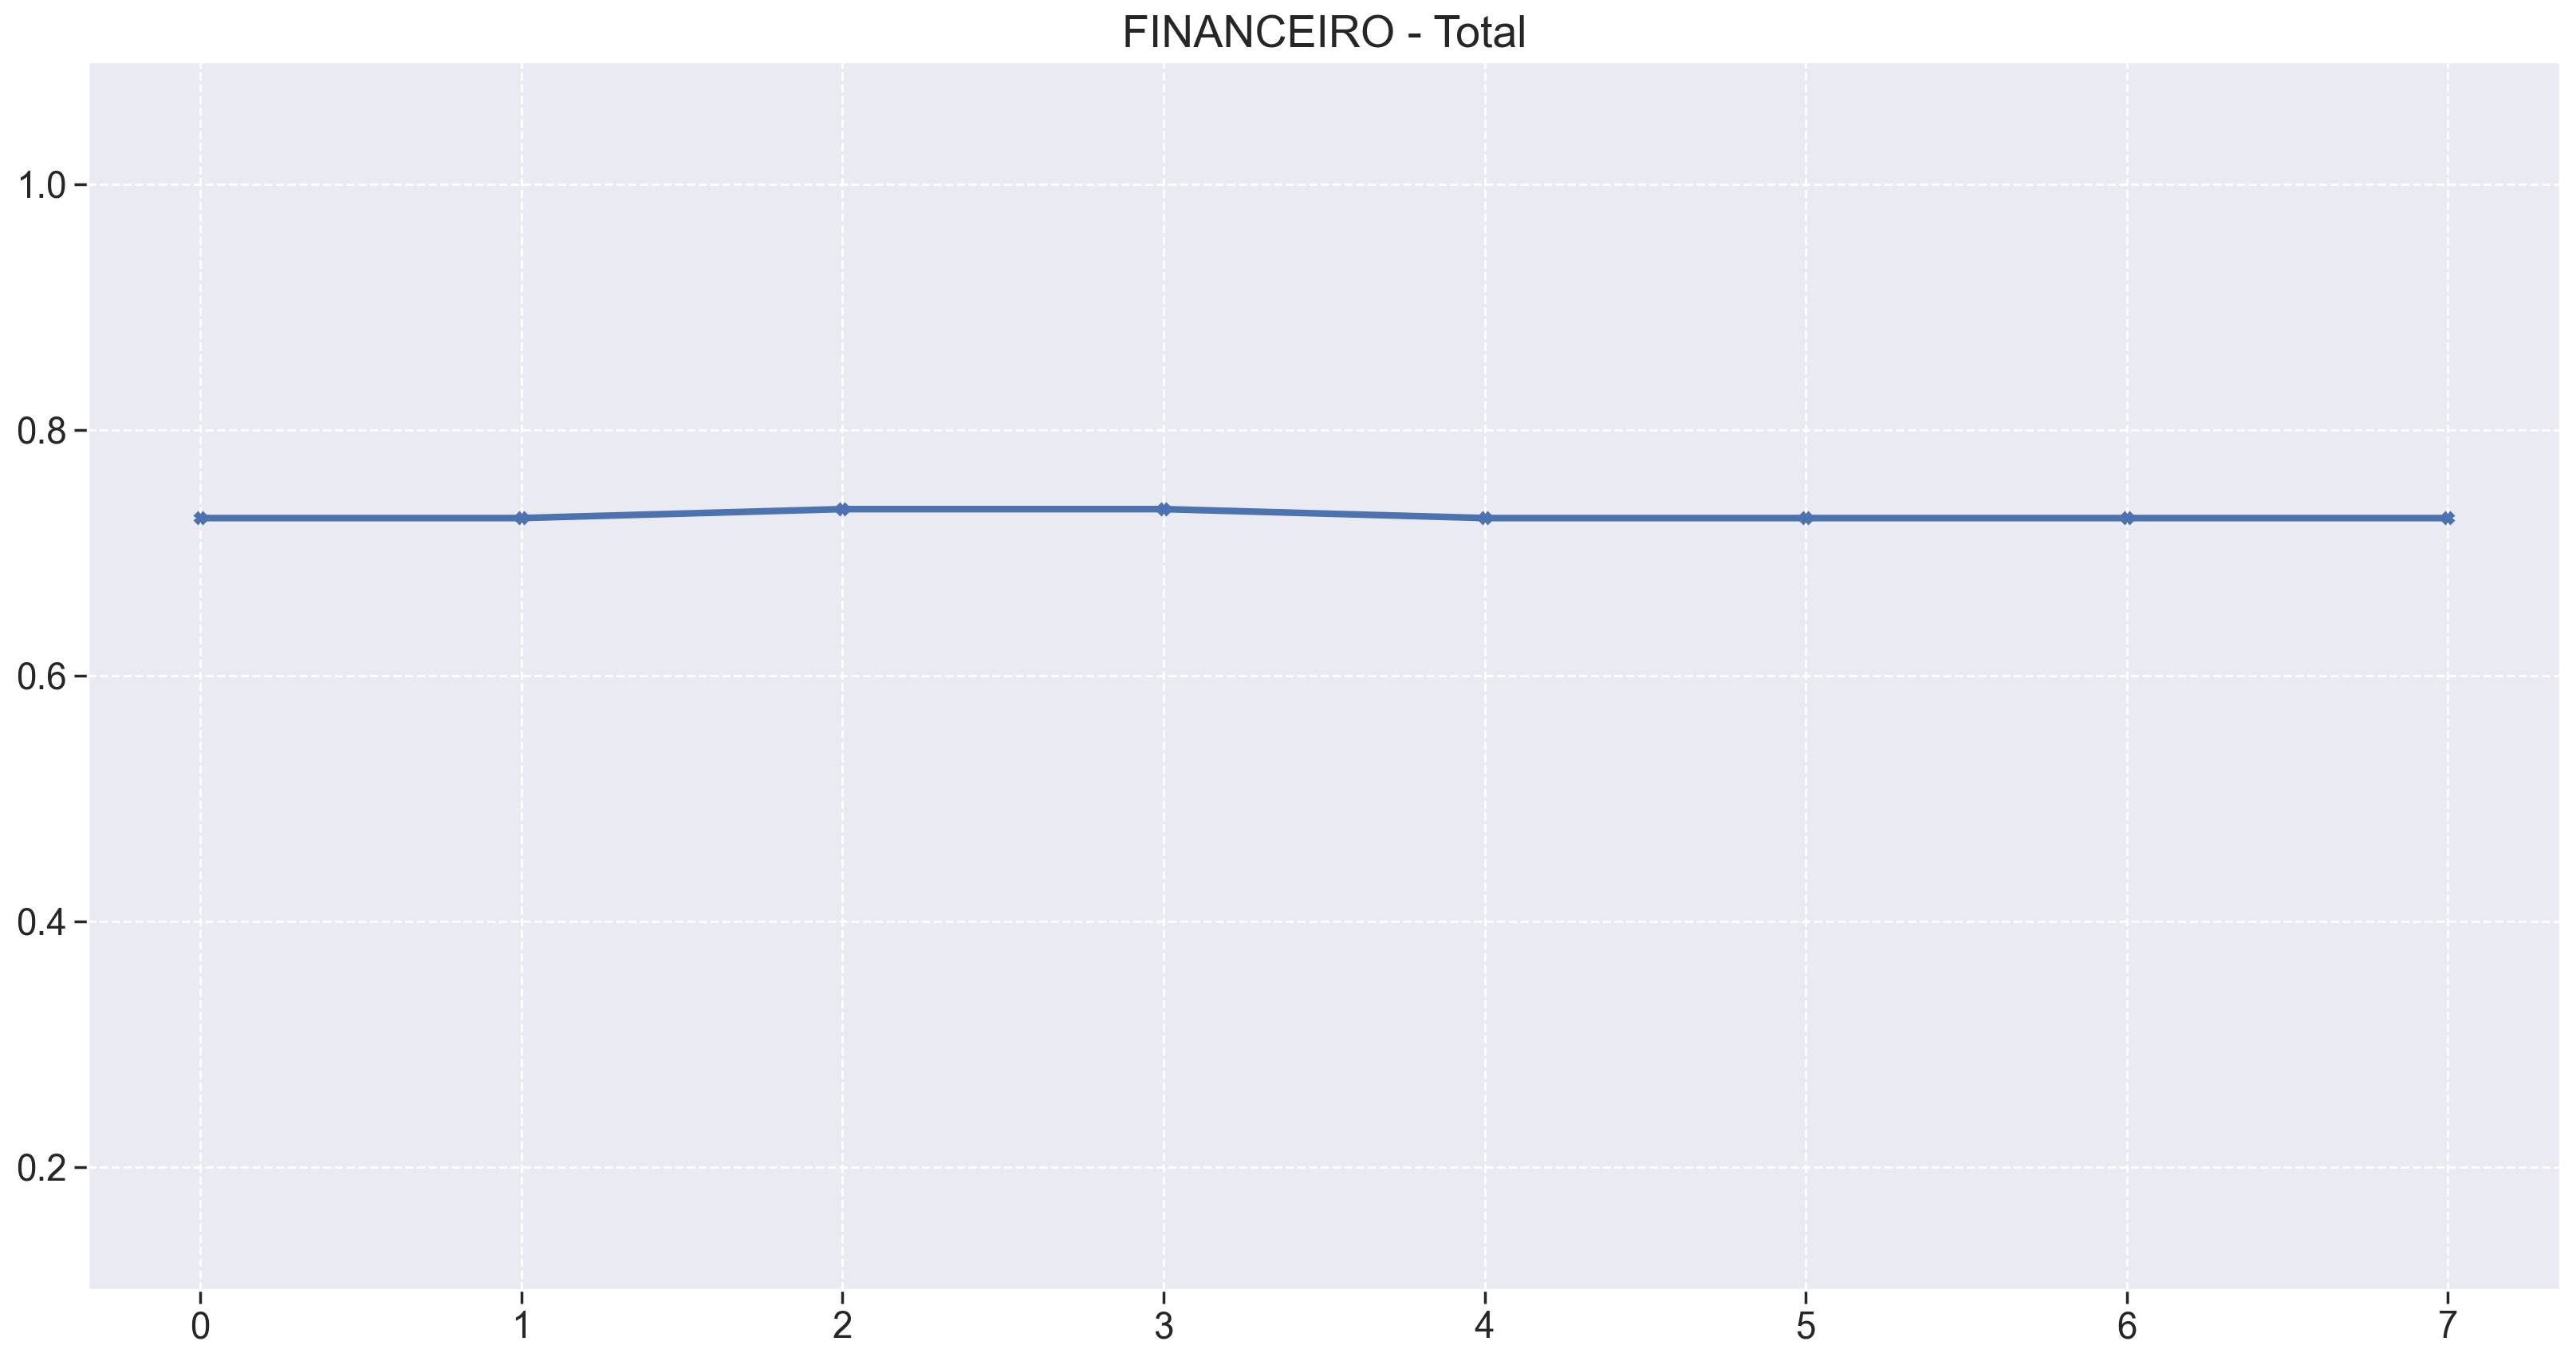

USUARIOS
Maintainability Stats
    mean     mode   median      std      var   min      max
0.299537 0.303947 0.303947 0.008102 0.000066 0.285 0.306429
Reliability Stats
    mean     mode   median      std      var      min      max
0.445138 0.434211 0.443182 0.011281 0.000127 0.428571 0.460526


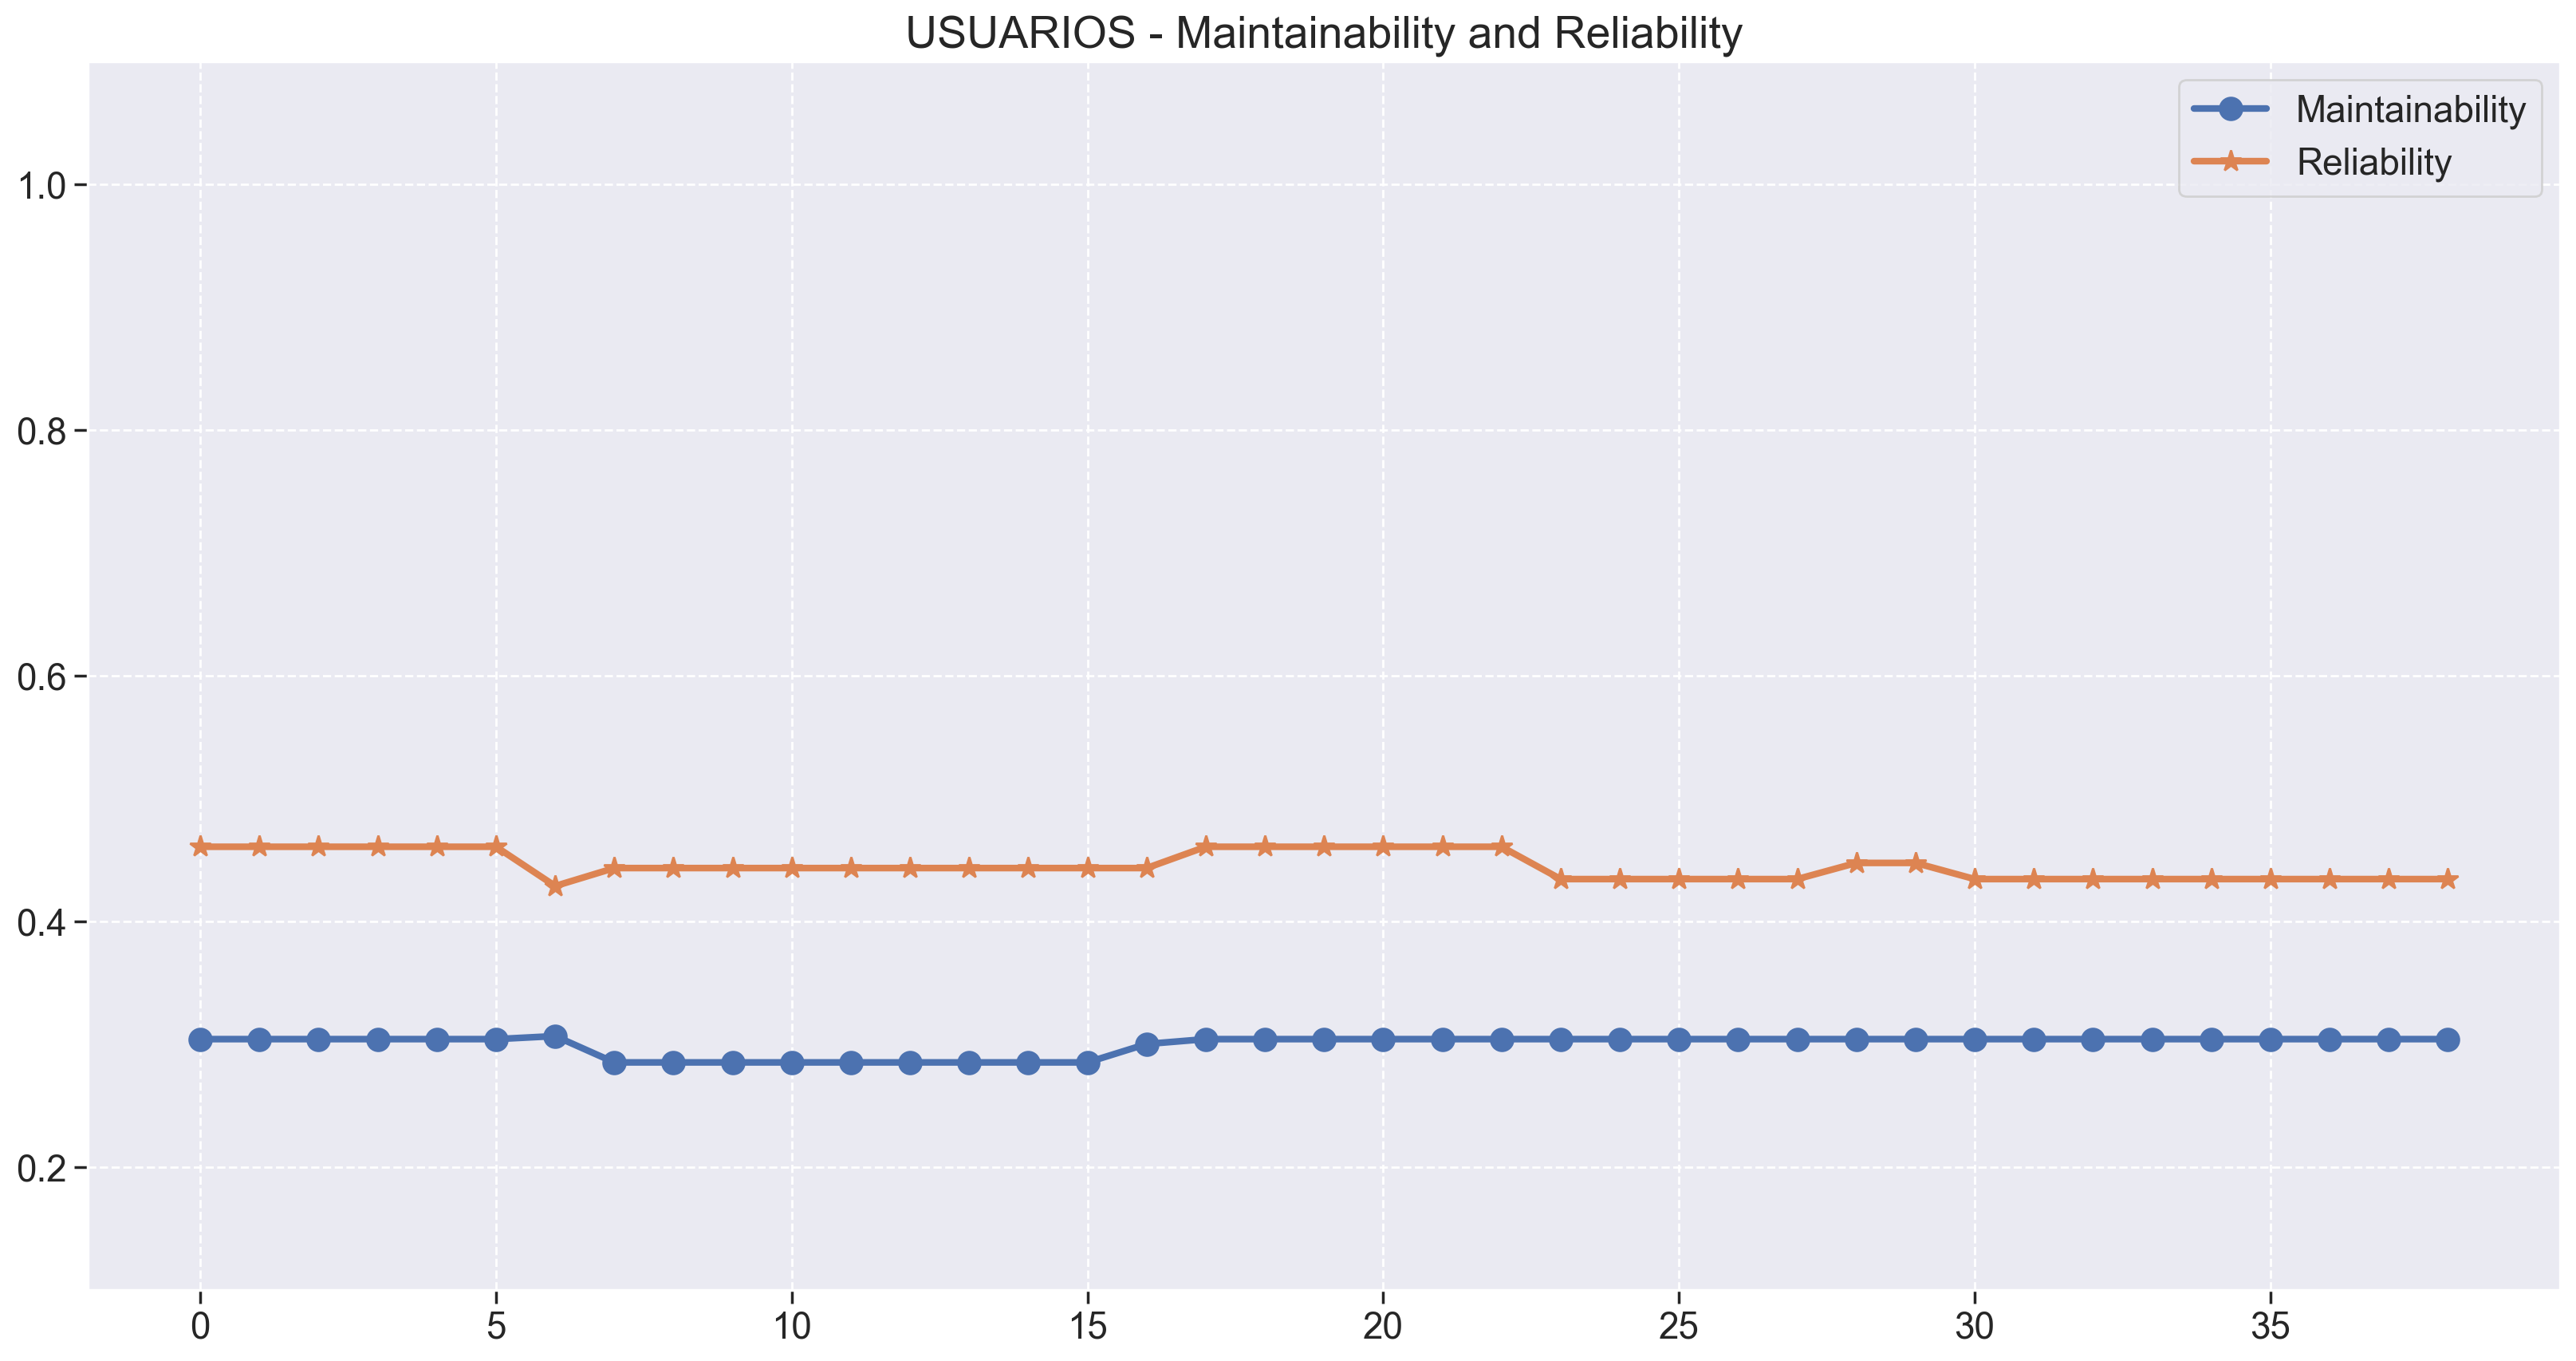

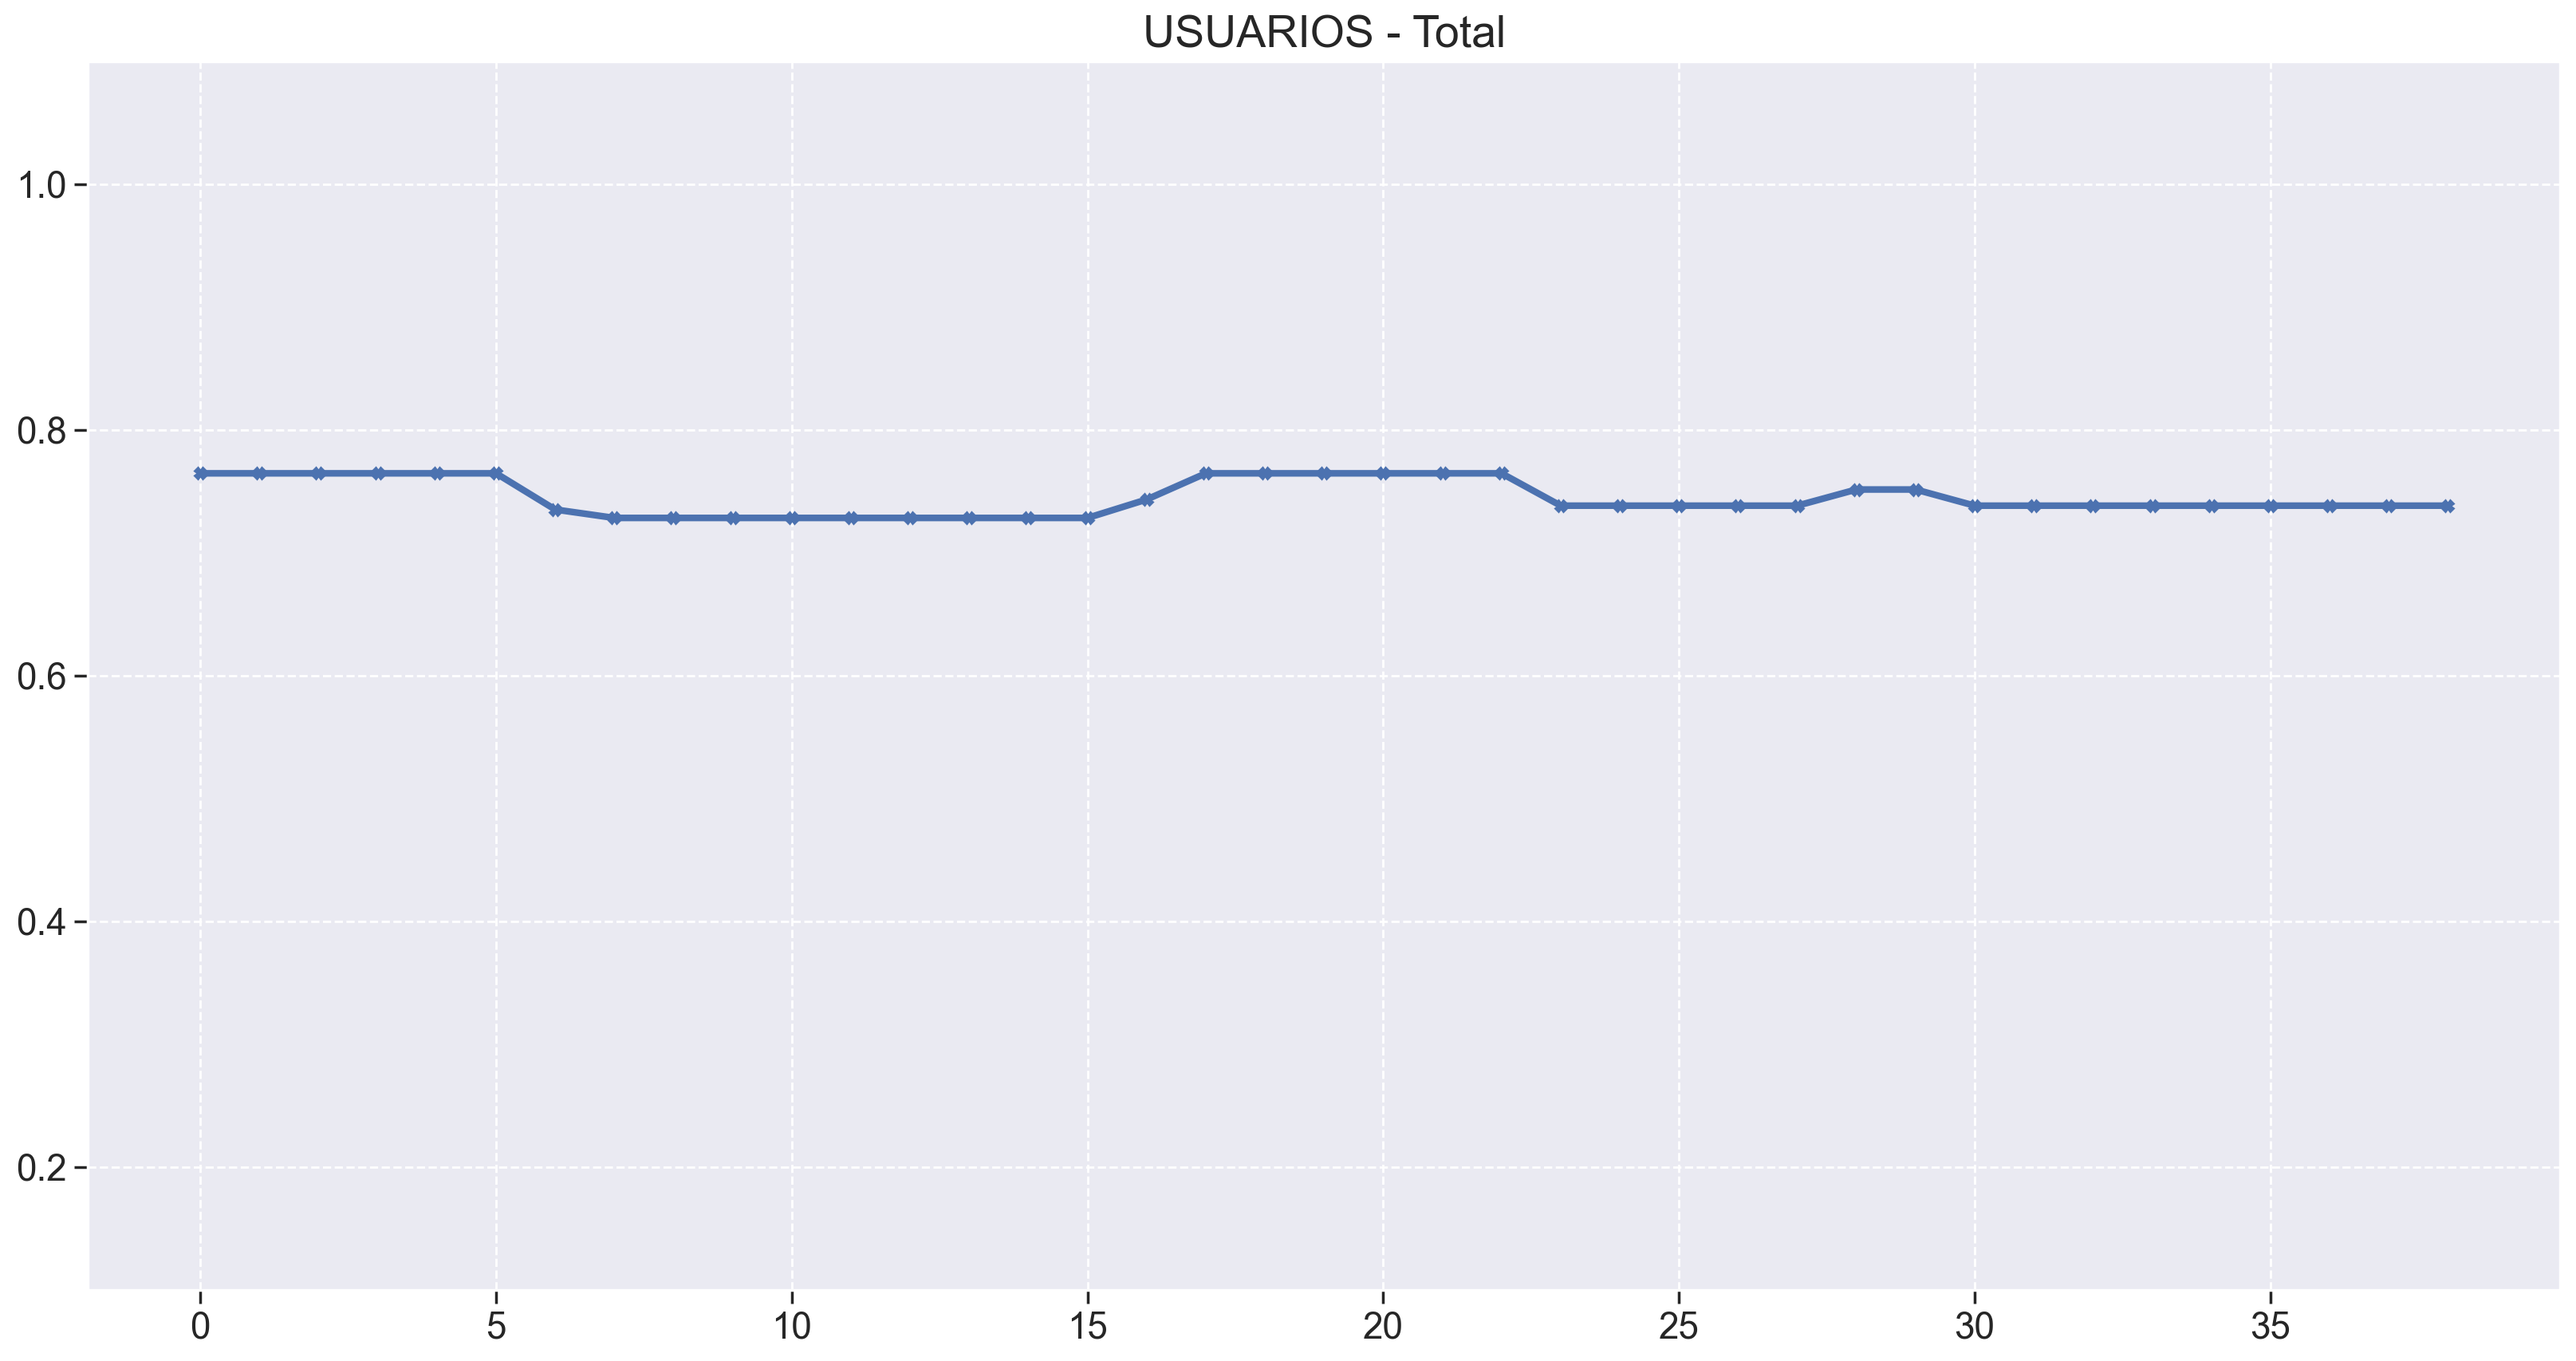

FRONT
Maintainability Stats
   mean     mode   median      std      var      min      max
0.29433 0.282857 0.282857 0.011892 0.000141 0.282857 0.308936
Reliability Stats
    mean     mode   median      std      var   min      max
0.348425 0.231607 0.392857 0.093768 0.008793 0.225 0.450495


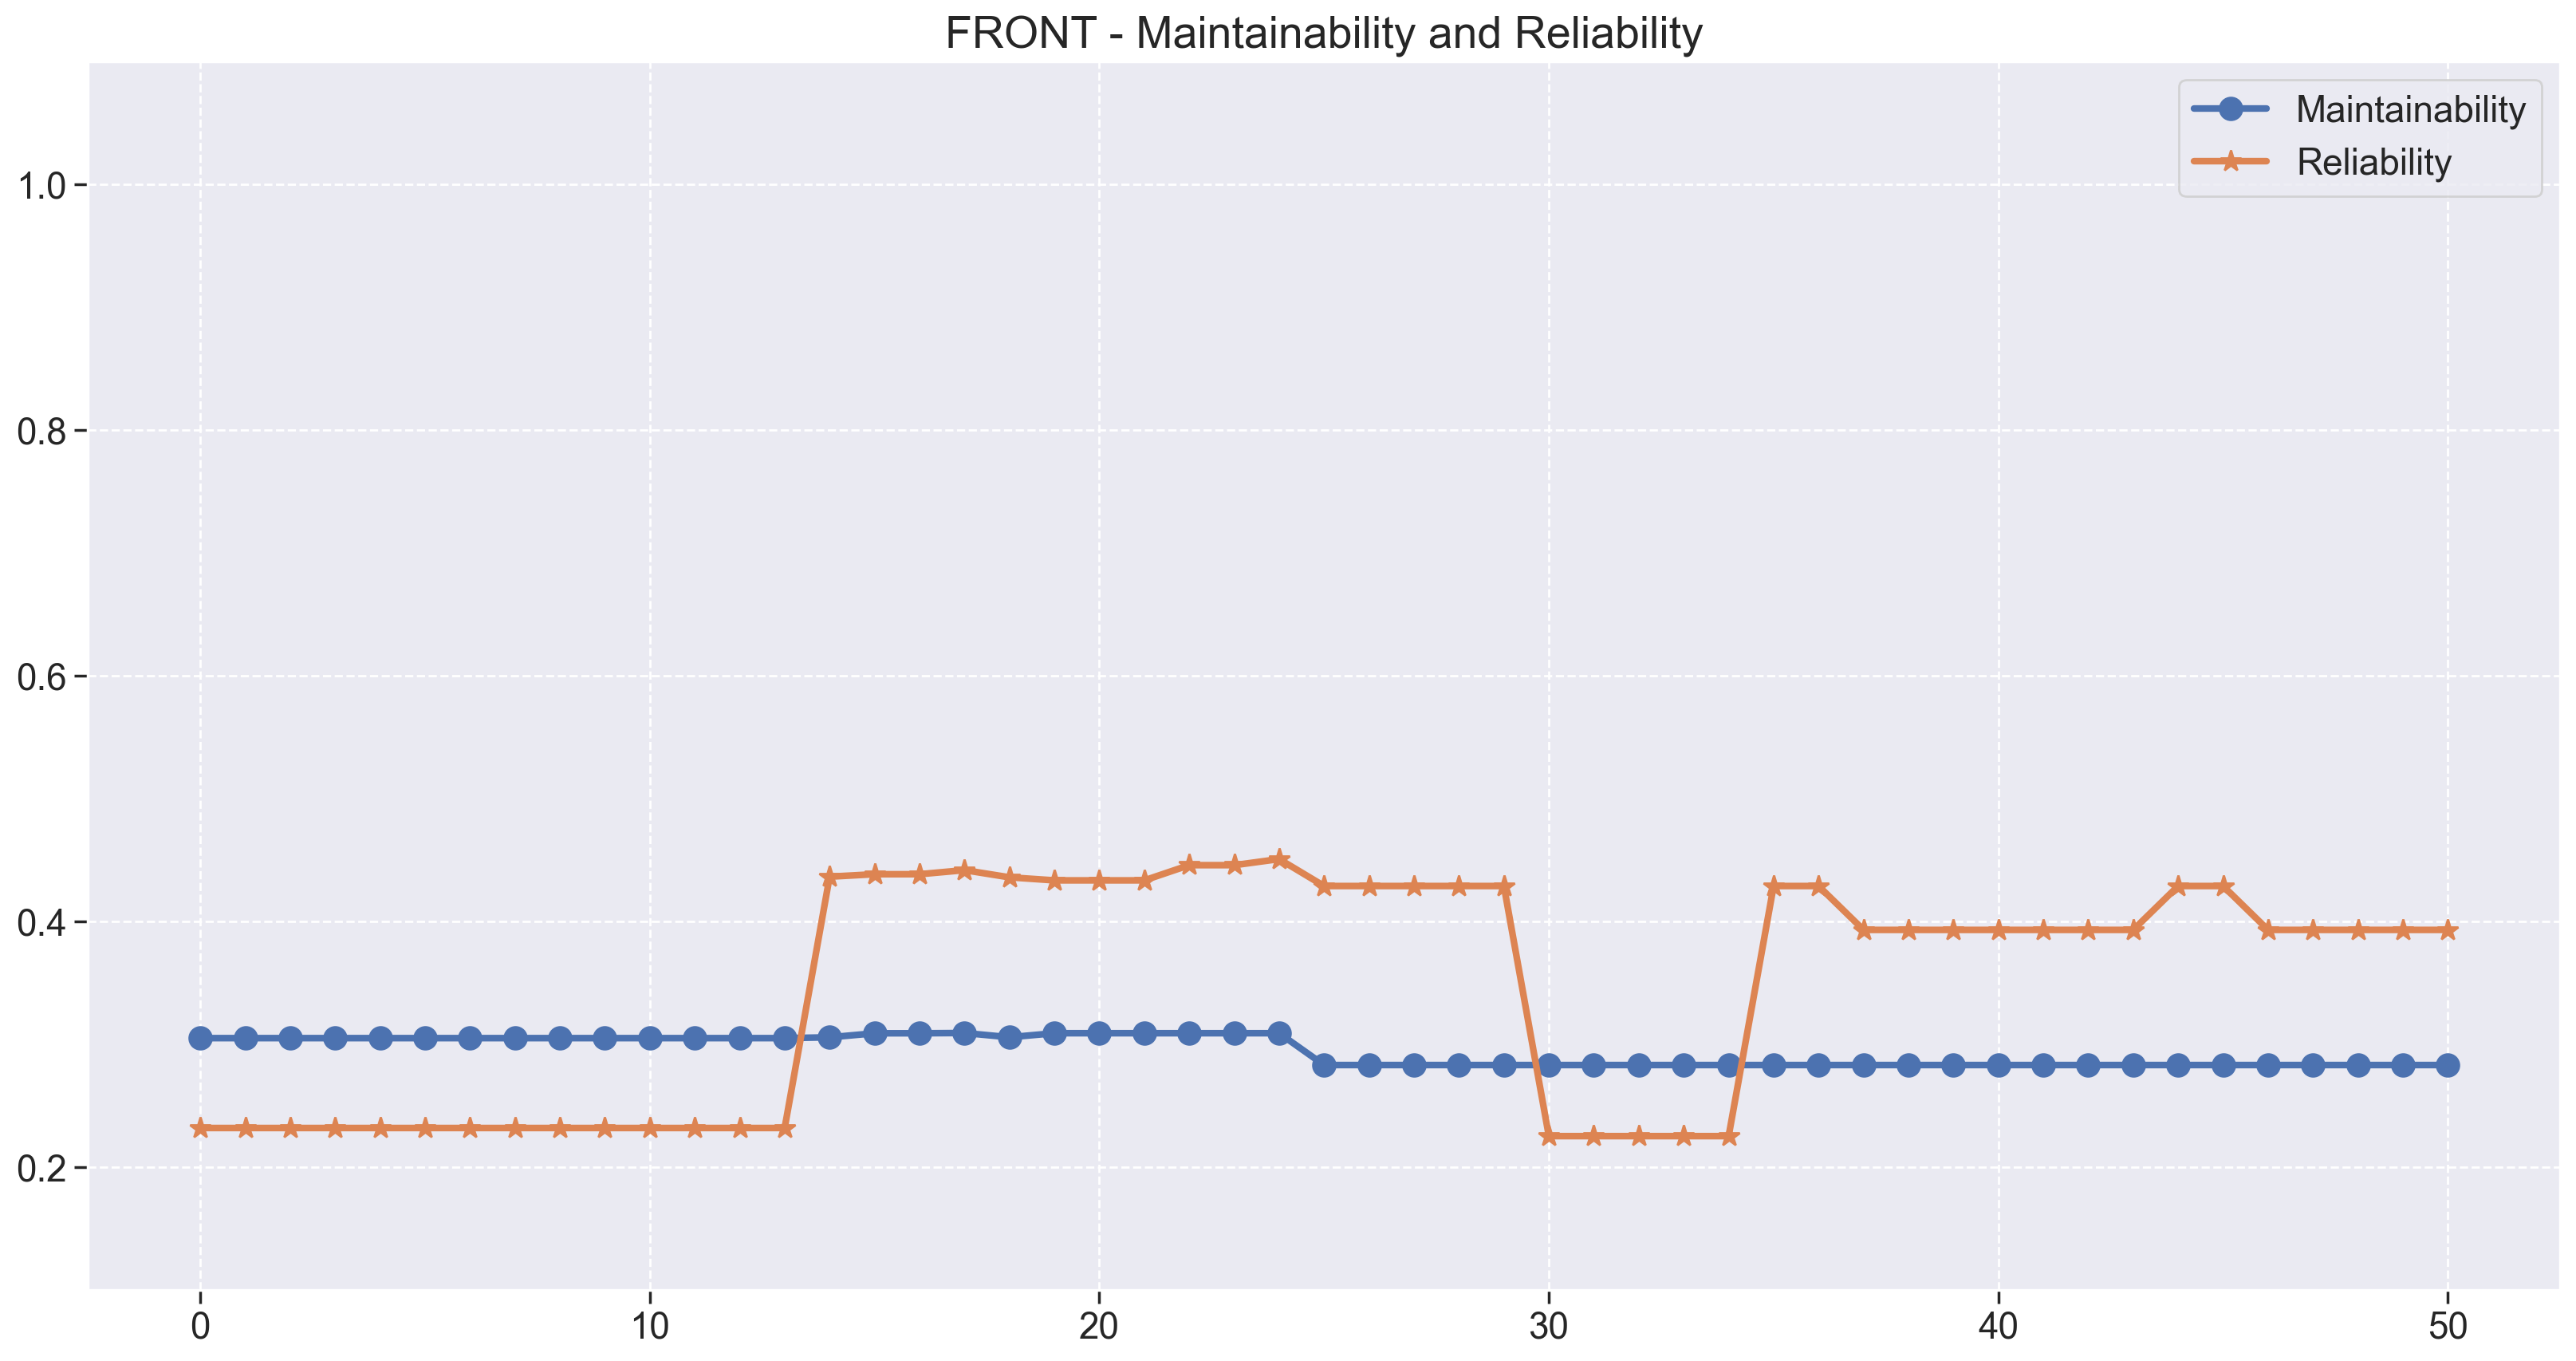

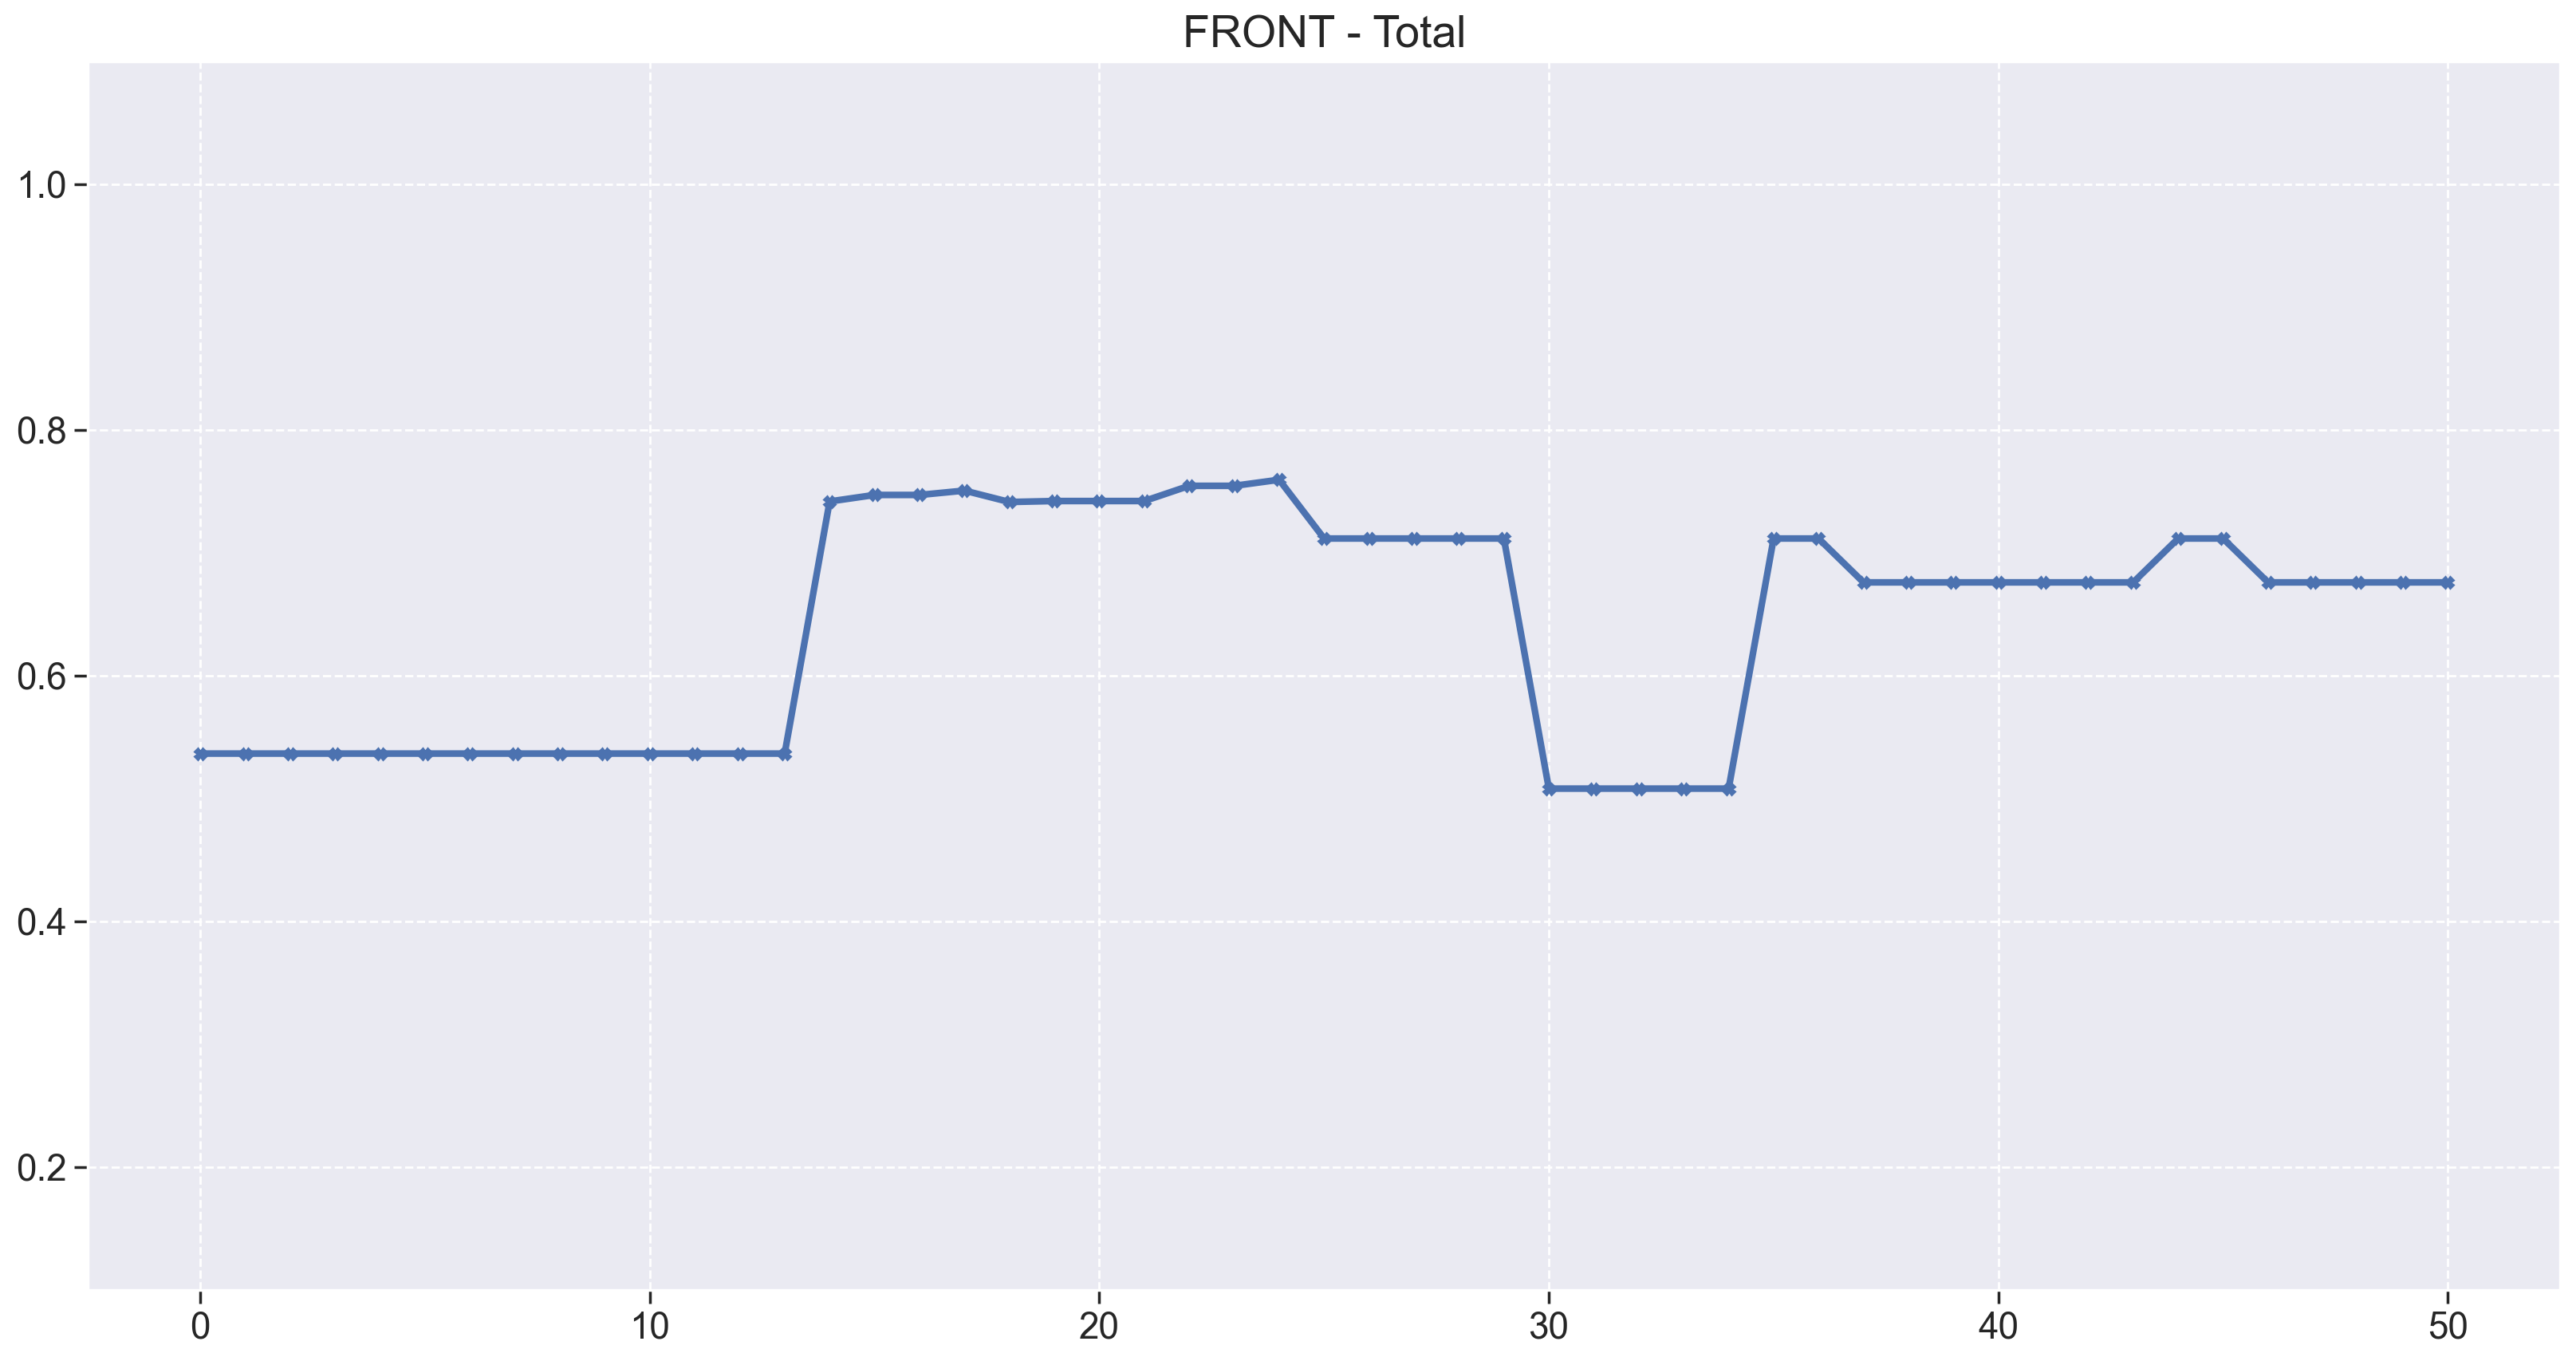

In [34]:
for name, data in metrics.items():
    print(name)
    
    analysis(data, name)

### Quality characteristic indicator

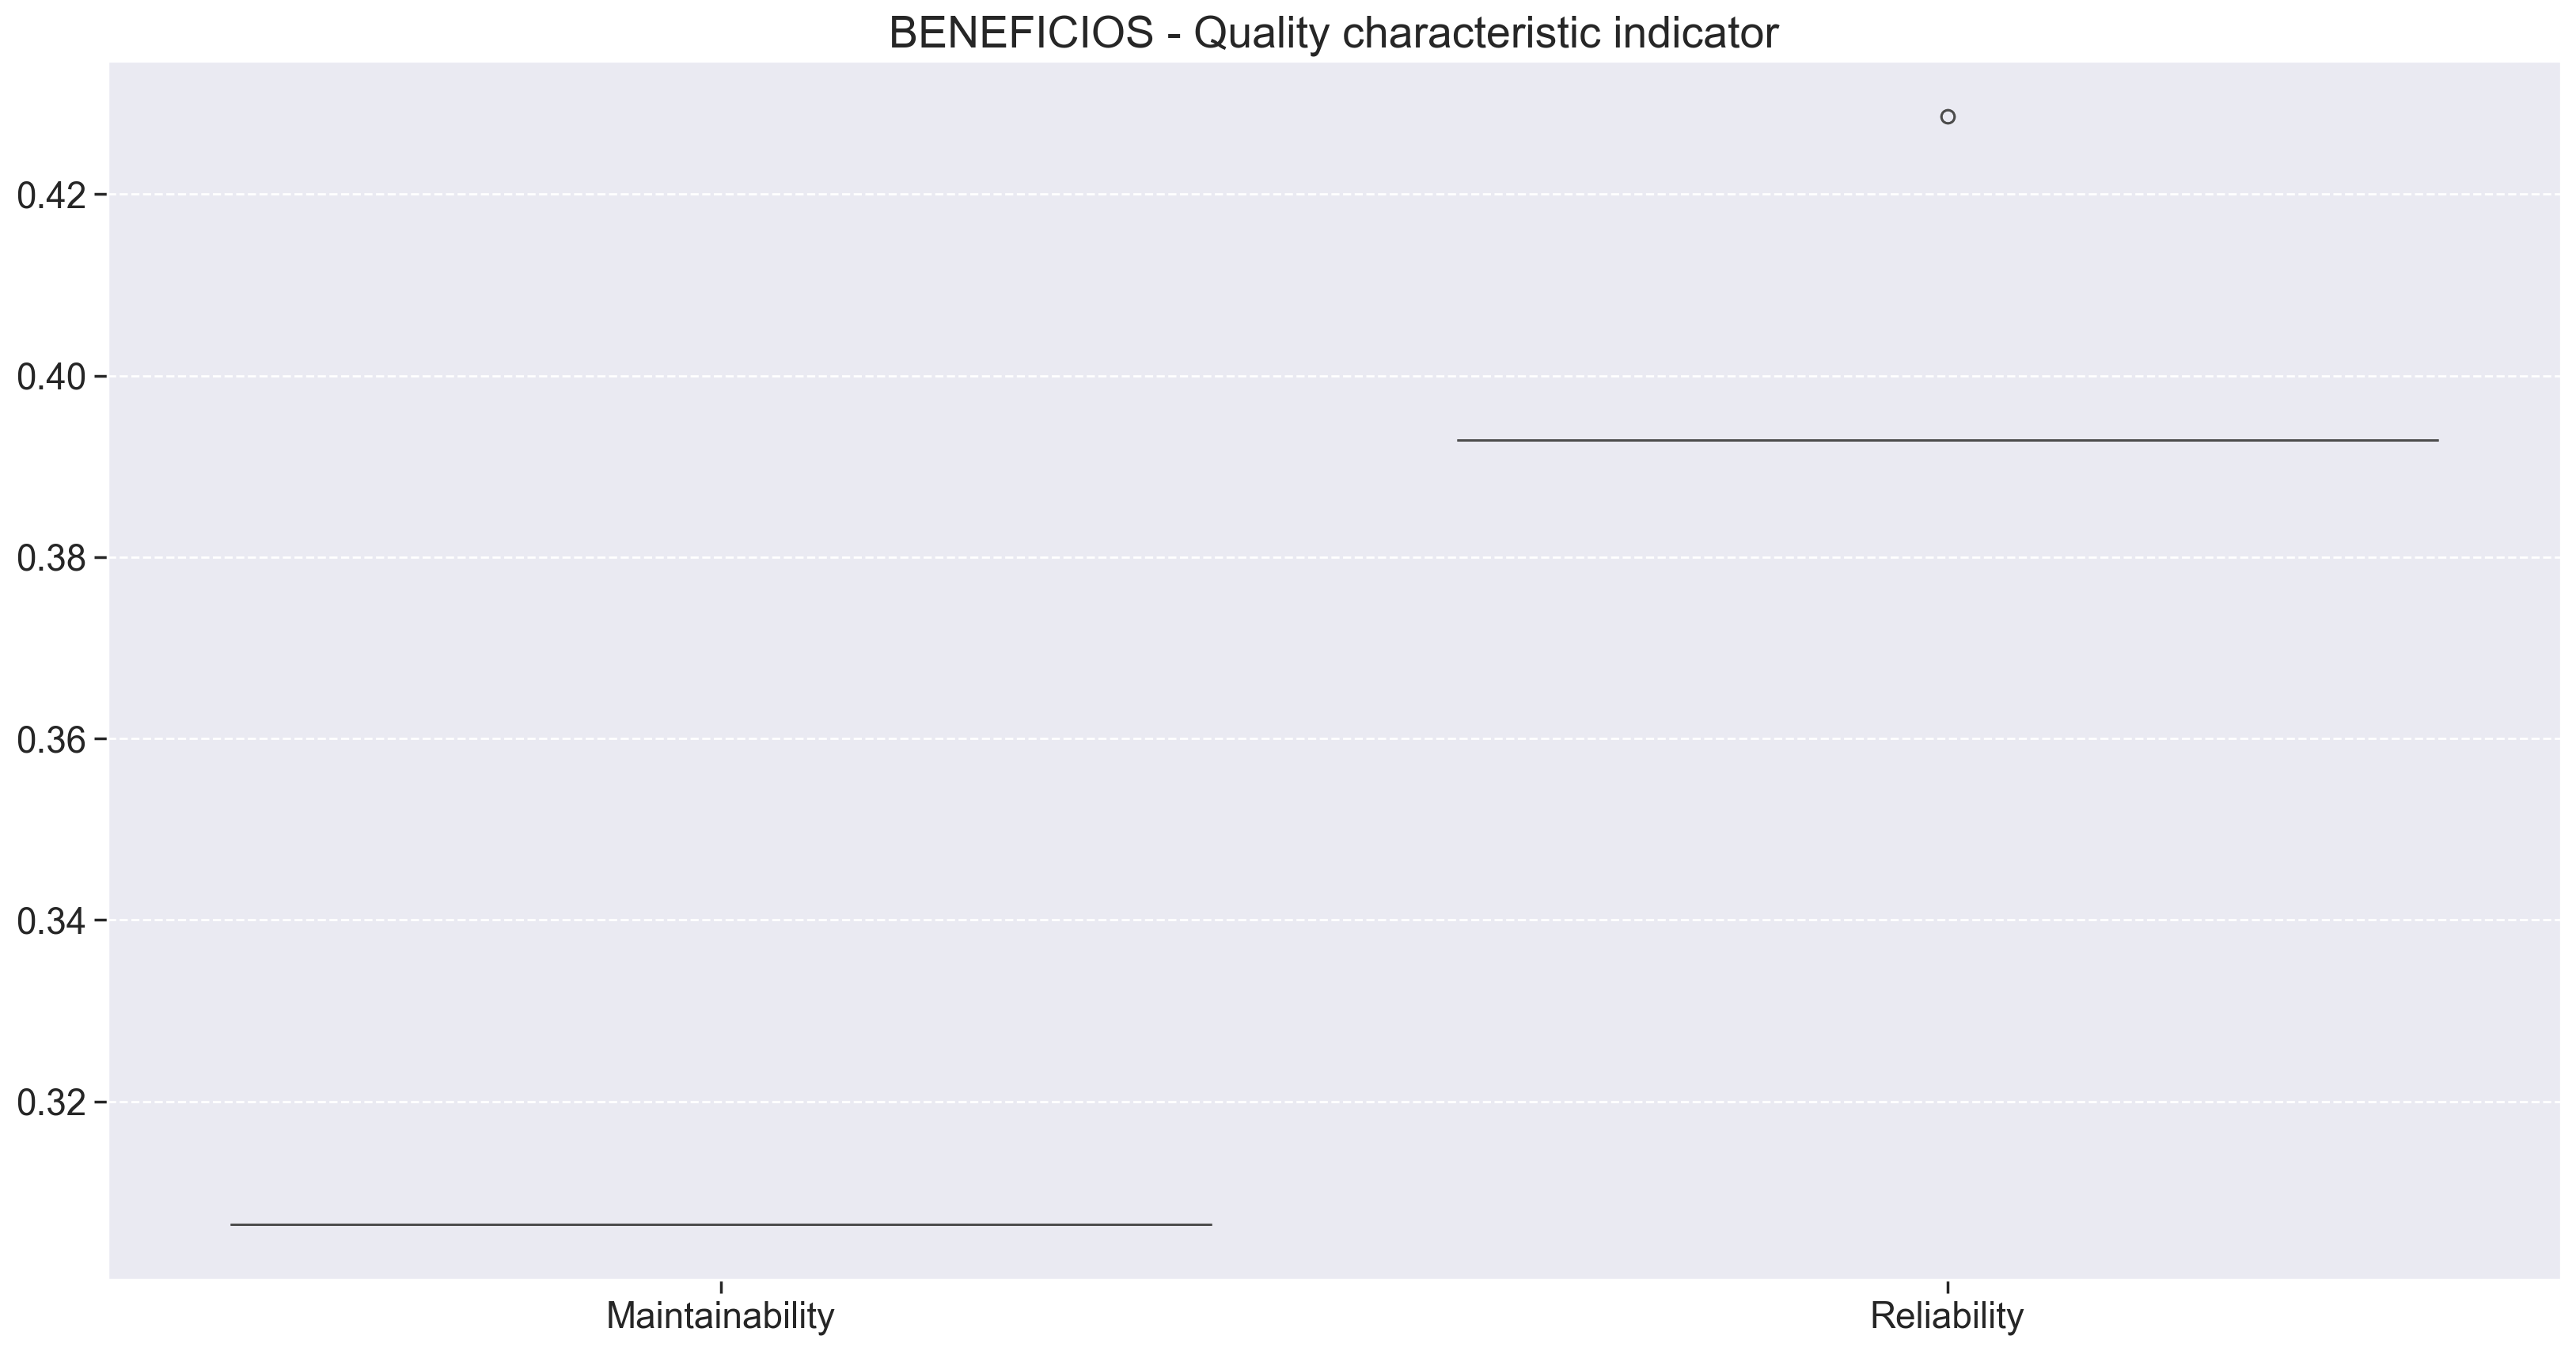

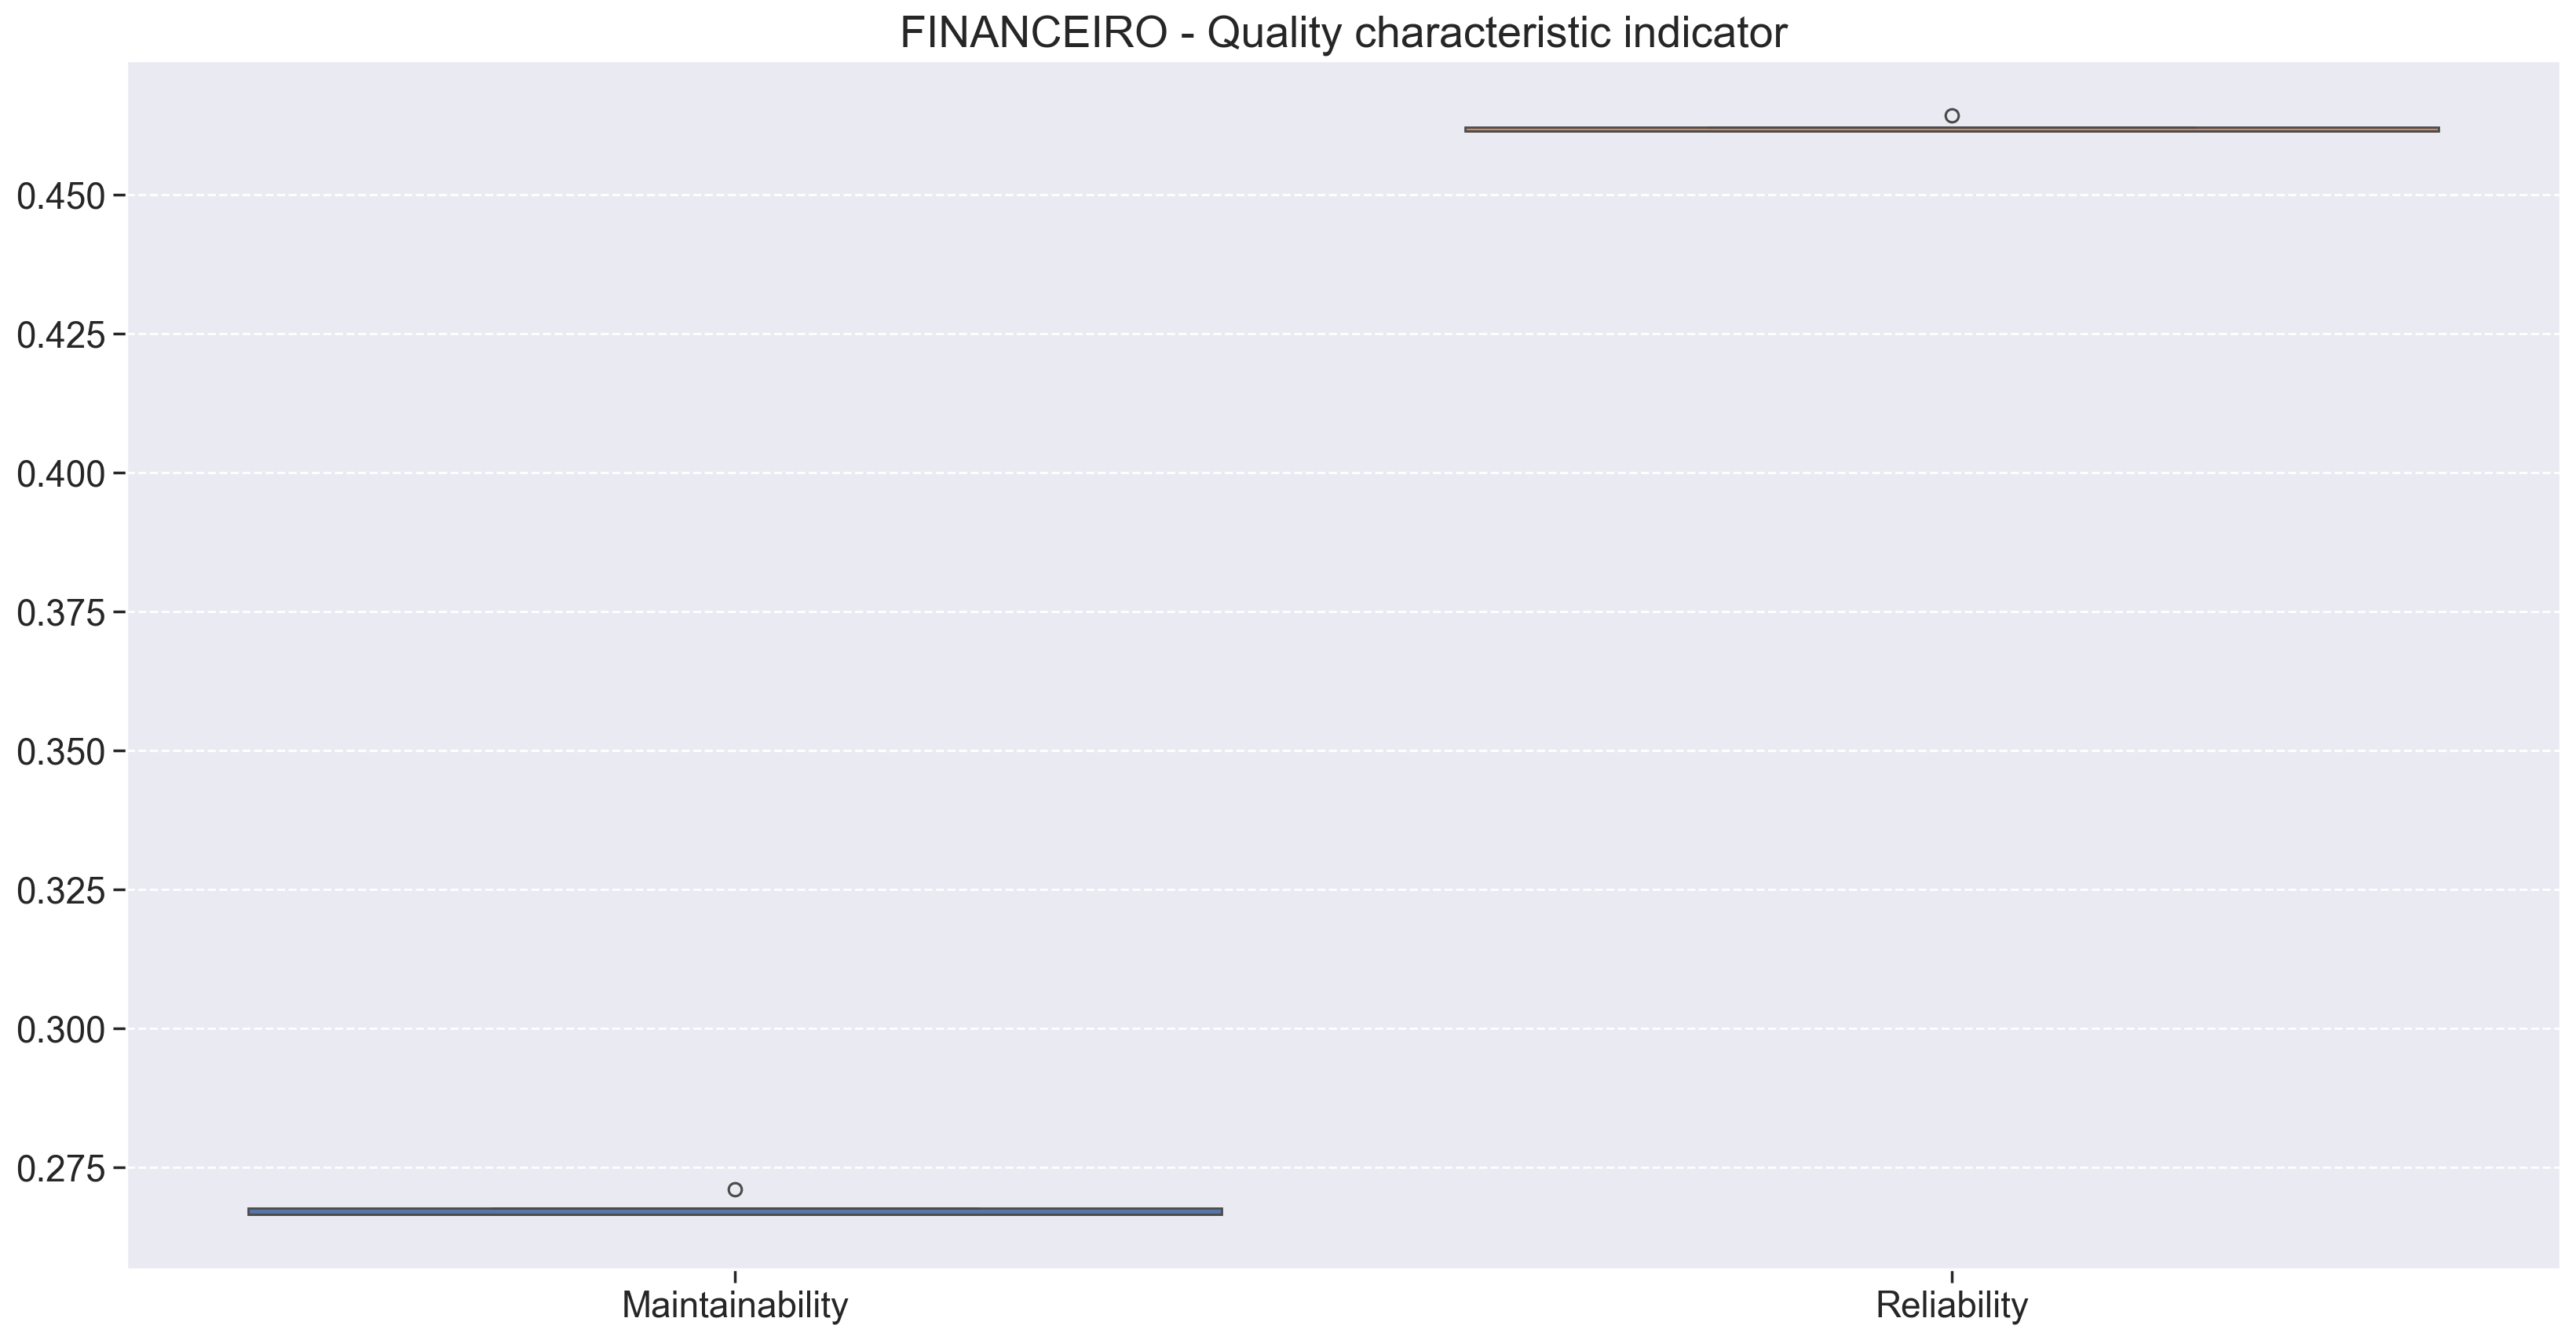

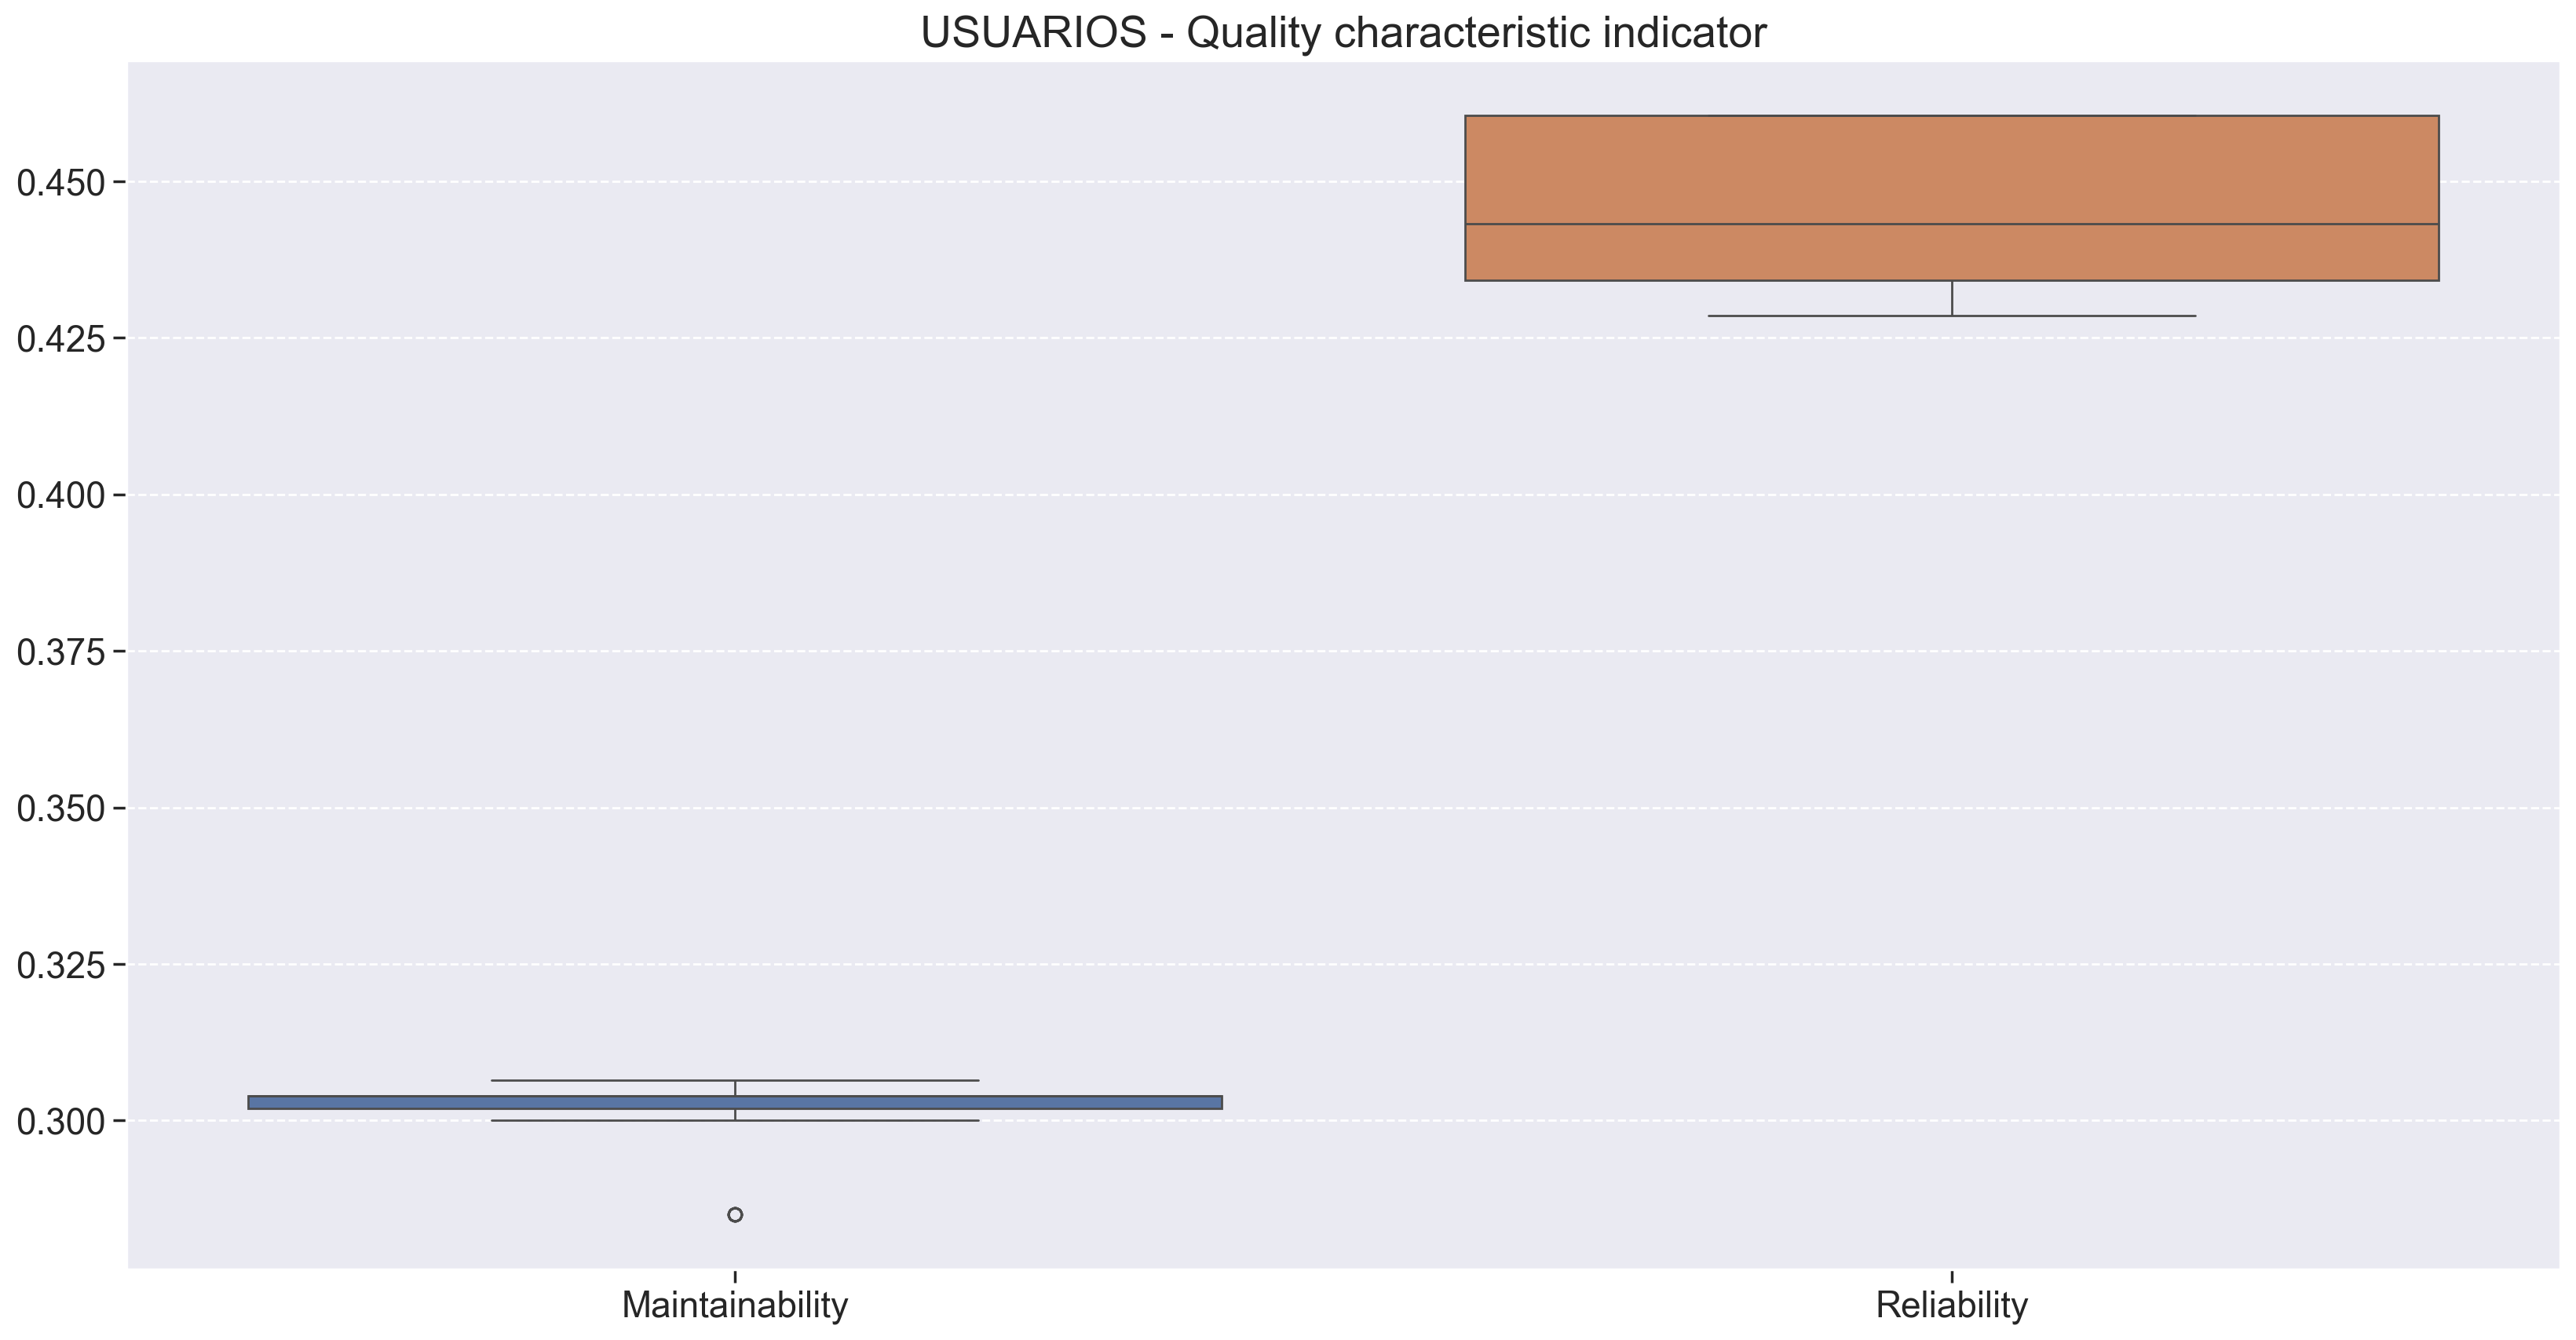

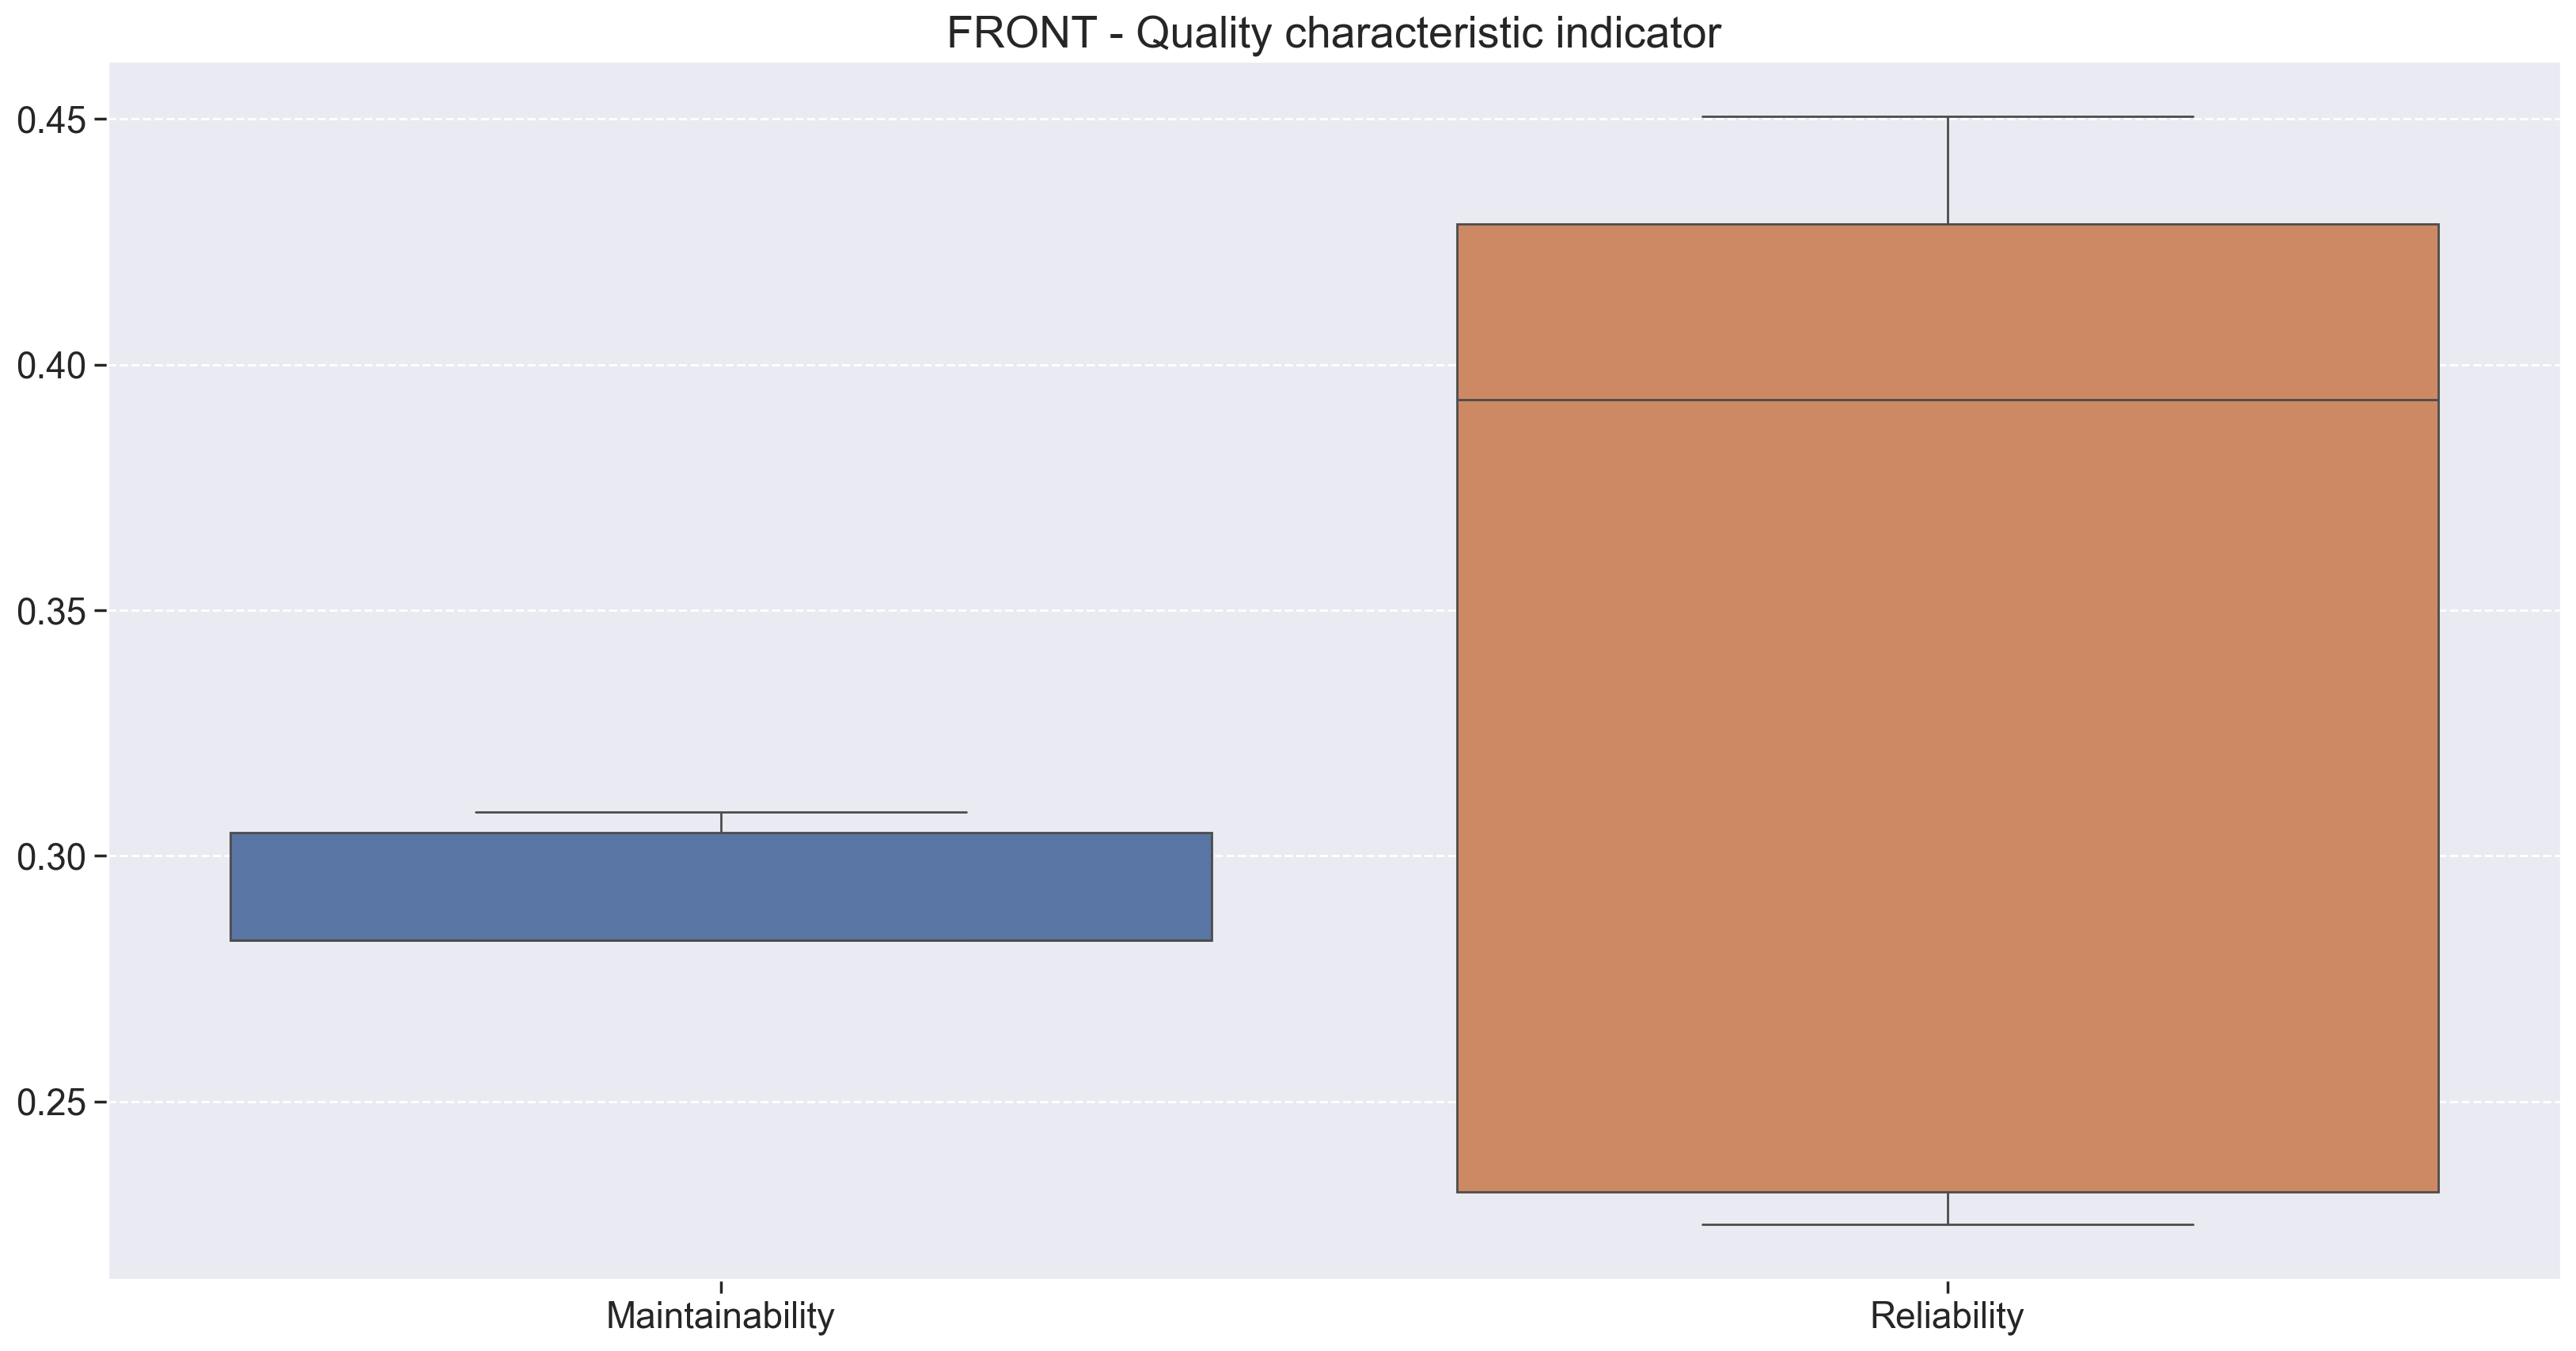

In [35]:

for name, data in metrics.items():
    fig = plt.figure(figsize=(20, 10))
    sns.boxplot(data=data[['Maintainability','Reliability']])

    plt.title(f"{name} - Quality characteristic indicator", fontsize=20)
    plt.show()

### Quality indicator visualization

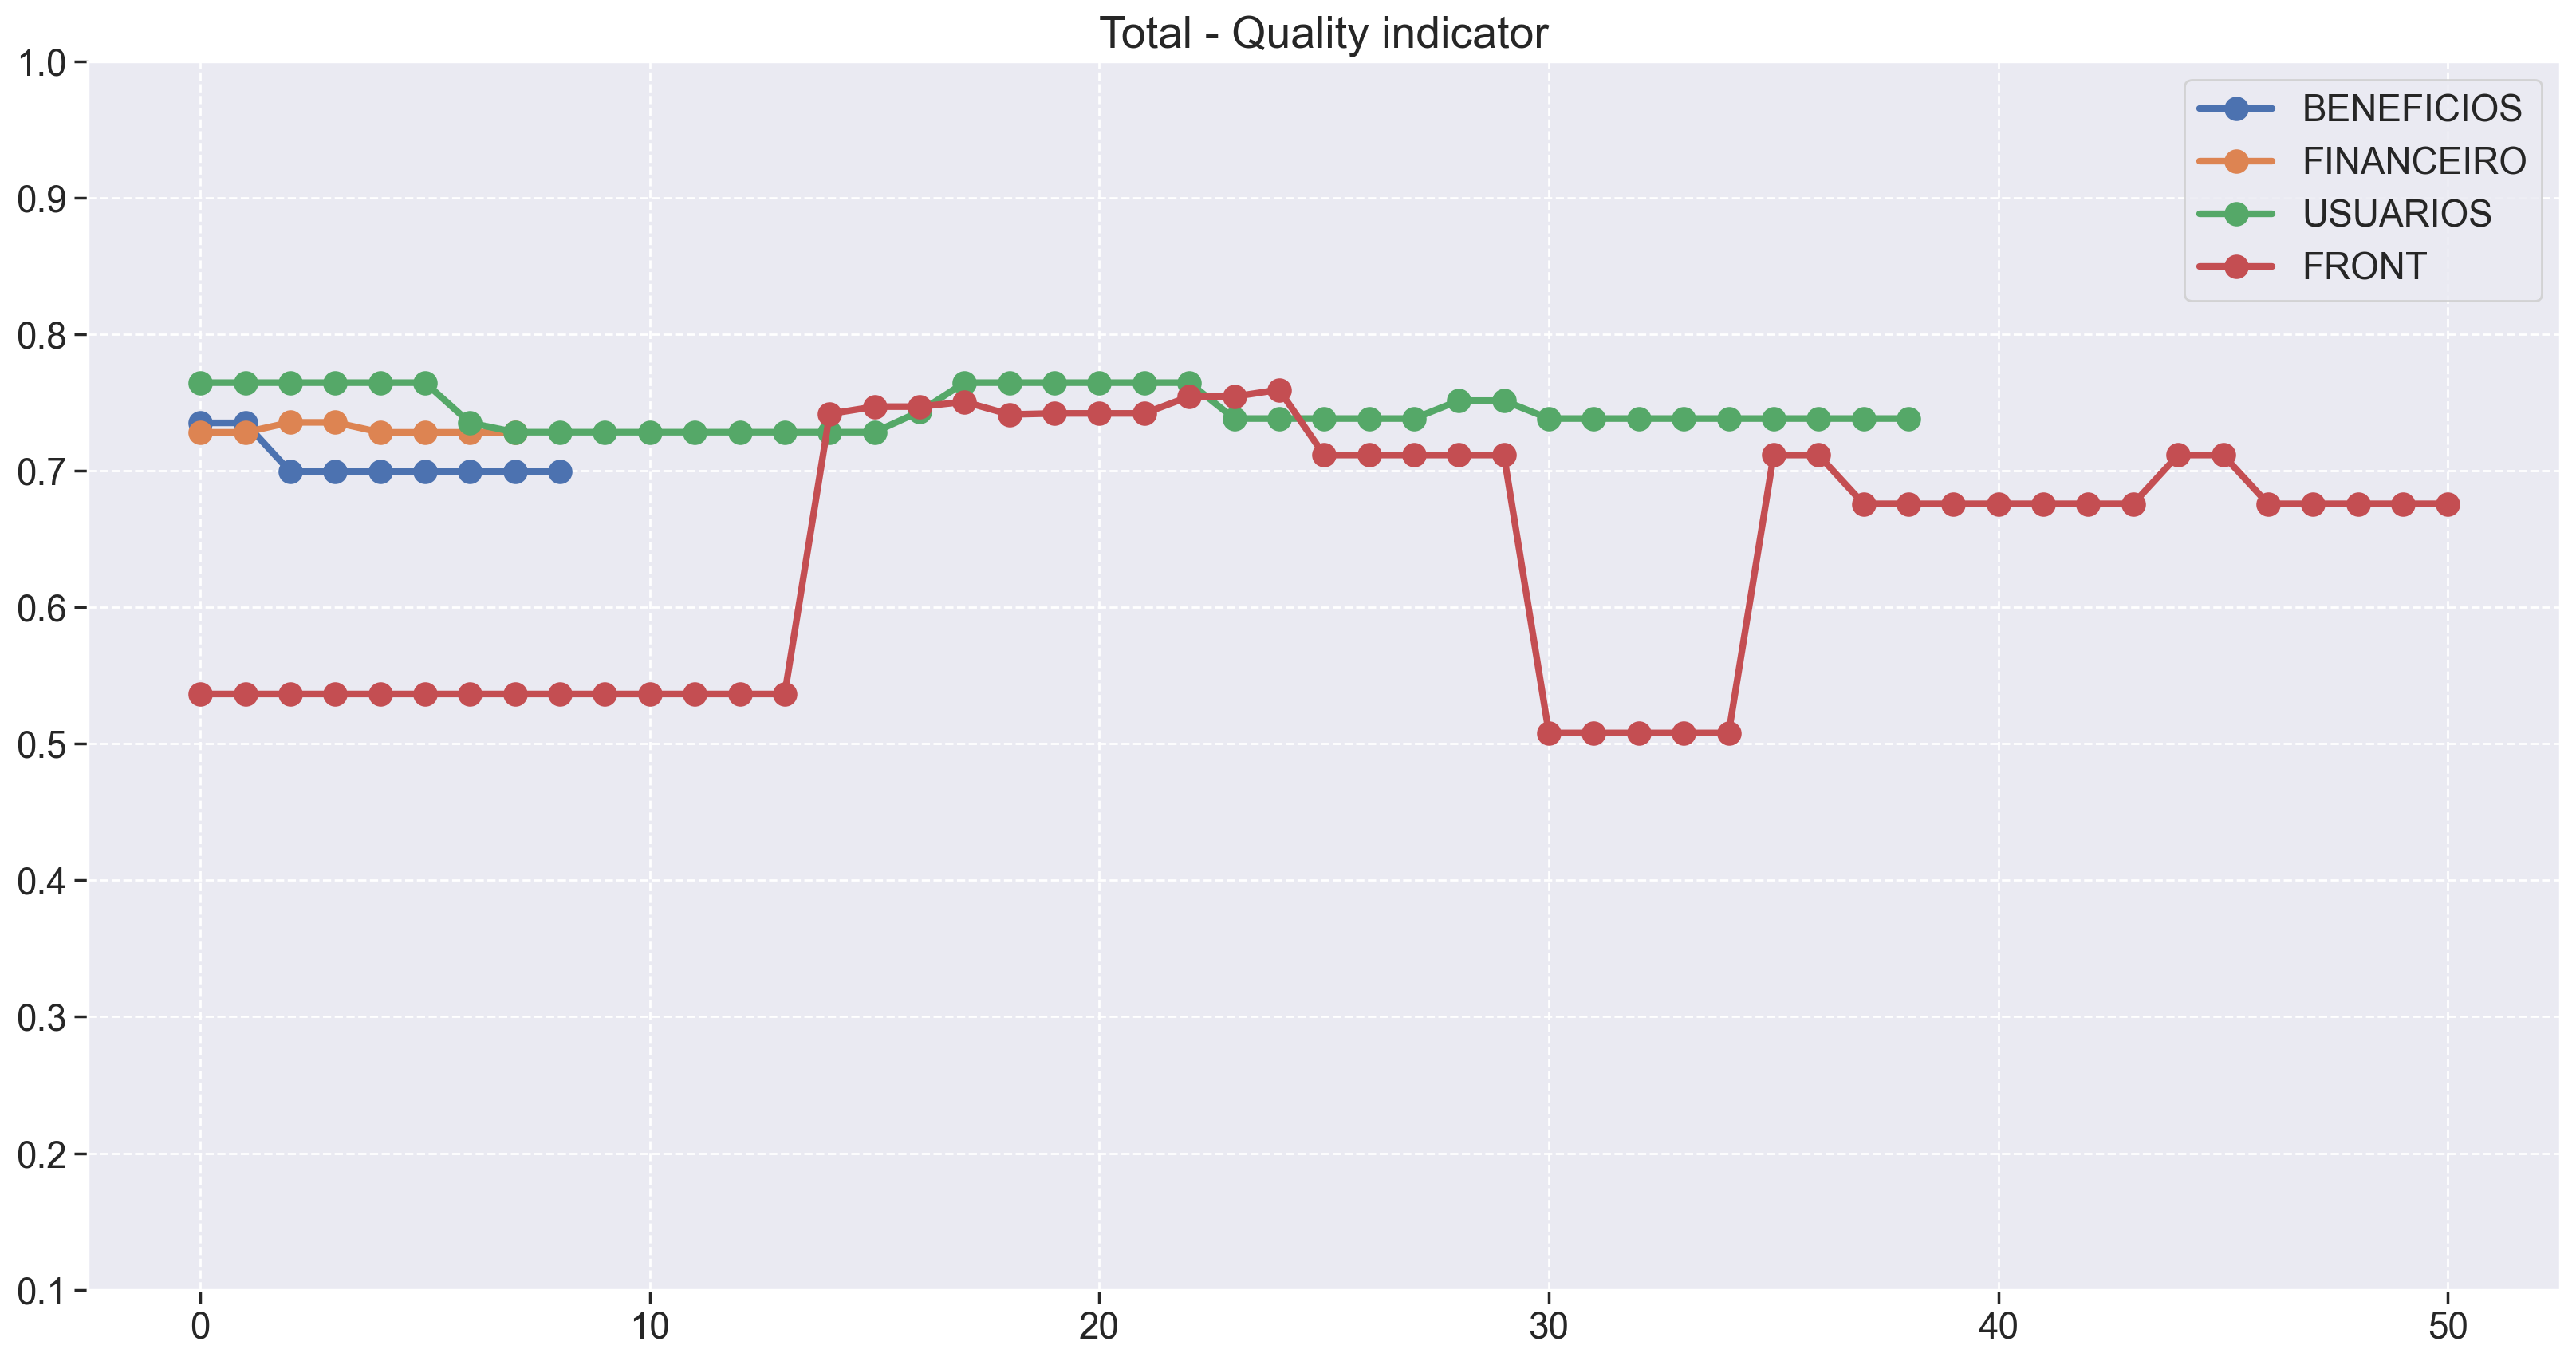

In [36]:
fig = plt.figure(figsize=(20, 10))

for name, data in metrics.items():
    plt.plot(data['total'], linewidth=3, marker='o', markersize=10, label=name)

plt.ylim(.1,1)
plt.title("Total - Quality indicator", fontsize=20)
plt.legend(loc='best')
plt.show()

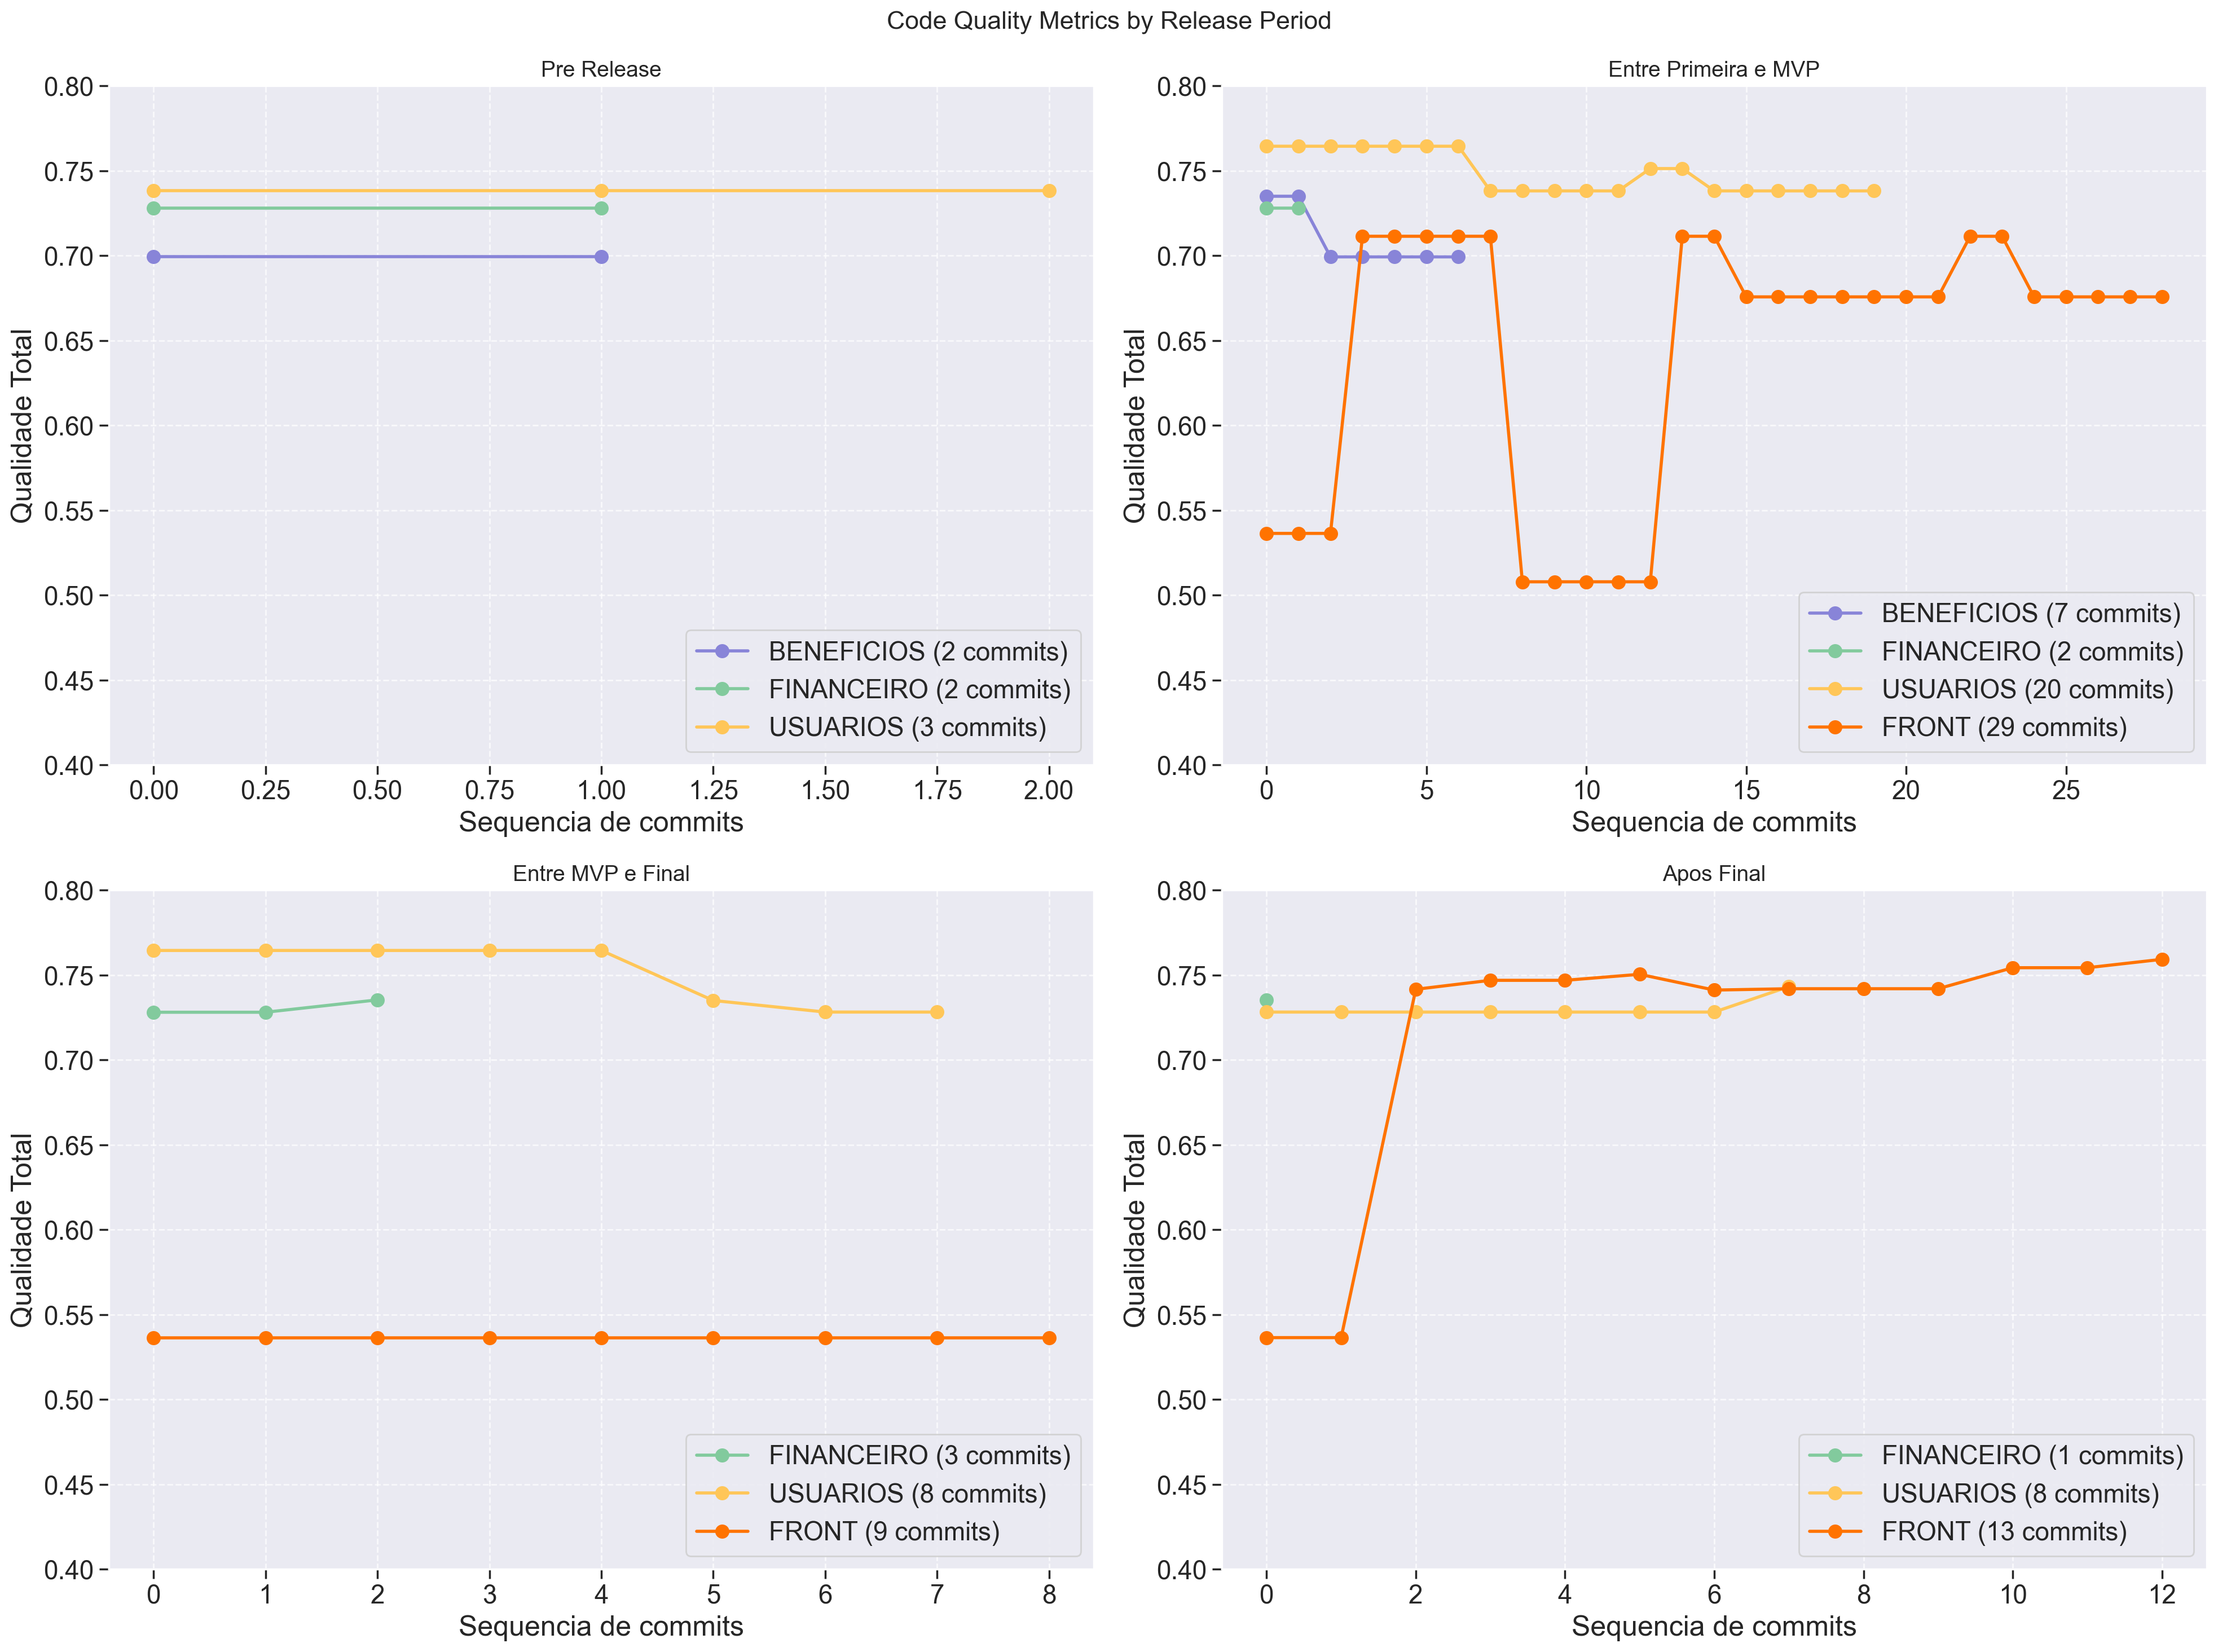

In [37]:

release_dates = {
    "1ª versão": pd.Timestamp("2024-12-08"),
    "MVP": pd.Timestamp("2025-01-25"),
    "Final": pd.Timestamp("2025-02-09")
}

def extract_date(version):
    parts = version.split('-')[:3] 
    return pd.Timestamp(f"{parts[2]}-{parts[0]}-{parts[1]}")  

metrics_splitted = {}

for name, df in metrics.items():
    df = df.copy()  
    df["date"] = df["version"].apply(extract_date)  

    metrics_splitted[name] = {
        "Pre Release": df[df["date"] < release_dates["1ª versão"]],
        "Entre Primeira e MVP": df[(df["date"] >= release_dates["1ª versão"]) & (df["date"] < release_dates["MVP"])],
        "Entre MVP e Final": df[(df["date"] >= release_dates["MVP"]) & (df["date"] < release_dates["Final"])],
        "Apos Final": df[df["date"] >= release_dates["Final"]]
    }

# newData = pd.DataFrame

# print(metrics_splitted)
# print(metrics_splitted)  # OR
graph = {
    'Pre Release' : {},
    'Entre Primeira e MVP' : {},
    'Entre MVP e Final' : {},
    'Apos Final' : {}
}
# # Para cada conjunto de releases
for idx, (name, subsets) in enumerate(metrics_splitted.items()):
    # Concatenando os dados de 'code_quality' para cada release do mesmo nome
    for release in subsets.keys():
        if('total' in subsets[release]):
        # else:
        #     metrics_splitted[name][release]['total'] = 20
        
            if release == 'Pre Release':
                graph['Pre Release'][name] = subsets[release]['total']
                # axs[0].plot(subsets[release]['code_quality'], label=name, linewidth=3, marker='o', markersize=5)
            elif release == 'Entre Primeira e MVP':
                graph['Entre Primeira e MVP'][name] = subsets[release]['total']

                # axs[1].plot(subsets[release]['code_quality'], label=name, linewidth=3, marker='o', markersize=5)
            elif release == 'Entre MVP e Final':
                graph['Entre MVP e Final'][name] = subsets[release]['total']
                # axs[2].plot(subsets[release]['code_quality'], label=name, linewidth=3, marker='o', markersize=5)
            elif release == 'Apos Final':
                graph['Apos Final'][name] = subsets[release]['total']
                # axs[3].plot(subsets[release]['code_quality'], label=name, linewidth=3, marker='o', markersize=5)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('Code Quality Metrics by Release Period', fontsize=16)

# Define colors for each repository
colors = {
    'BENEFICIOS': '#8884d8',
    'FINANCEIRO': '#82ca9d',
    'USUARIOS': '#ffc658',
    'FRONT': '#ff7300'
}

axes = axes.ravel()

# Plot each release period

for idx, (period, data) in enumerate(graph.items()):
    ax = axes[idx]
    
    for repo, series in data.items():
        if not series.empty:
            ax.plot(range(len(series)), series.values, 
                   marker='o',
                   linewidth=2,
                   markersize=8,
                   label=f"{repo} ({len(series)} commits)",
                   color=colors[repo])
    
    ax.set_title(period, fontsize=14)
    ax.set_xlabel('Sequencia de commits')
    ax.set_ylabel('Qualidade Total')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_ylim(0.4, 0.8)  # Adjusted based on new value ranges
    ax.legend(loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


# Análise da Qualidade por Período de Release



## Pre Release
- BENEFICIOS: Manteve uma qualidade constante devido a aplicação da atividade do lean.
- FINANCEIRO: Manteve uma qualidade constante devido a aplicação da atividade do lean.
- USUARIOS: Manteve uma qualidade constante devido a aplicação da atividade do lean.
- FRONT: Sem commits neste período.

## Entre Primeira e MVP
- BENEFICIOS: Queda de qualidade devido a diminuição da cobertura de testes.
- FINANCEIRO: Qualidade estagnada, sem melhorias.
- USUARIOS: Grande volume de commits (20) tendo uma pequena queda na qualidade, devido a geração de código sem testes.
- FRONT: Apresentou dois patamares:
  - Primeiros manteve a qualidade.
  - 2 Etapa teve uma queda devido a quebra de testes. 
  - Posteriormente, reduziu em relação ao início da release devido a geração de código sem testes.

## Entre MVP e Final
- BENEFICIOS: Sem commits neste período.
- FINANCEIRO: Pequena melhoria ao final.
- USUARIOS:
  - Manteve a mesma qualidade por 5 commits.
  - Posteriormente, caiu, indicando introdução de complexidade, etapa onde também foi dada a alteração do sistema de permissões.
- FRONT: Manteve-se com cobertura baixa devido a nova quebra de testes.

## Após Final
- BENEFICIOS: Sem atividade.
- FINANCEIRO: Apenas um commit, mantendo a qualidade.
- USUARIOS:
  - Obteve melhora após a correção de testes, bem como a redução a duplicidade de código gerada durante as releases.
- FRONT: Demonstrou tendência de melhoria:
  - Apos ter quebrado durante a correção do sistema de permissão, foram corrigidos os problemas e implementado novos teste.
  - Subiu gradualmente.
  
# Conclusões por Repositório

## BENEFICIOS
- Apresentou a melhor qualidade média (0.612857).
- Atividade concentrada nos períodos iniciais.

## FINANCEIRO
- Apresentou a menor qualidade média.
- Melhoria gradual, mas pouco significativa.
- Baixo número de commits.

## USUARIOS
- Qualidade consistente na maior parte do tempo.
- Queda notável após o MVP.
- Elevado número de commits em todos os períodos.
- Tentativa de recuperação da qualidade no final.

## FRONT
- Sem atividade inicial.
- Grande volume de commits após a primeira versão.
- Correção dos testes quebrados

## Export data

In [38]:
metrics_list = metrics.values()

metrics_df = pd.concat(metrics_list, ignore_index=True)

display(metrics_df)

current_datetime = datetime.datetime.now().strftime("%m-%d-%Y--%H-%M-%S")

metrics_df.to_excel('../data/fga-eps-mds-2024.2-SENTINELA--{}.xlsx'.format(current_datetime), index = False)

metrics_df.to_csv('../data/fga-eps-mds-2024.2-SENTINELA--{}.csv'.format(current_datetime), index = False)

,complexity,comments,duplication,test_success,fast_tests,coverage,repository,version,ncloc,code_quality,testing_status,Maintainability,Reliability,total
0,0.571429,0.285714,1.000000,1.000000,1.0,0.714286,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,01-19-2025-18-40-08,742,0.612857,0.857143,0.306429,0.428571,0.735000
1,0.571429,0.285714,1.000000,1.000000,1.0,0.714286,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,1-16-2025-2-42-51,742,0.612857,0.857143,0.306429,0.428571,0.735000
2,0.571429,0.285714,1.000000,1.000000,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-13-2024-13-54-25,742,0.612857,0.785714,0.306429,0.392857,0.699286
3,0.571429,0.285714,1.000000,1.000000,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-13-39-38,742,0.612857,0.785714,0.306429,0.392857,0.699286
4,0.571429,0.285714,1.000000,1.000000,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-13-41-38,742,0.612857,0.785714,0.306429,0.392857,0.699286
5,0.571429,0.285714,1.000000,1.000000,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-3-44-34,742,0.612857,0.785714,0.306429,0.392857,0.699286
6,0.571429,0.285714,1.000000,1.000000,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-17-2024-3-44-37,742,0.612857,0.785714,0.306429,0.392857,0.699286
7,0.571429,0.285714,1.000000,1.000000,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-7-2024-1-8-18,742,0.612857,0.785714,0.306429,0.392857,0.699286
8,0.571429,0.285714,1.000000,1.000000,1.0,0.571429,fga-eps-mds-2024.2-SENTINELA_BACKEND_BENEFICIOS,12-7-2024-1-8-4,742,0.612857,0.785714,0.306429,0.392857,0.699286
9,0.538462,0.076923,1.000000,1.000000,1.0,0.846154,fga-eps-mds-2024.2-SENTINELA_BACKEND_FINANCEIRO,01-26-2025-23-54-39,3274,0.533077,0.923077,0.266538,0.461538,0.728077
